In [ ]:
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [8]:
directory = "/Users/bryant.chhun/Desktop/Data/2019_04_08_TetraSpec_PSF_6"

sample = "/Pos0"

outfolder = "/Users/bryant.chhun/Desktop/Data/2019_04_08_TetraSpec_PSF_6/"

In [11]:
files = [name for name in os.listdir(directory+sample) 
              if os.path.isfile(os.path.join(directory+sample, name))]


In [10]:
inputChann = ['Zyla_405_Widefield','Zyla_488_Widefield', 'Zyla_561_Widefield', 'Zyla_637_Widefield']

In [14]:
# generate 3d tiff files (PSF files)

for chan in inputChann:
    tiffstack = []
    
    # pull out images that string match chan
    imglist_by_chan = [directory+sample+"/"+img for img in files if chan in img]
    imglist_by_chan.sort(reverse=False)
    
    # write sorted images to array
    for Image in imglist_by_chan:
        ar = tifffile.imread(Image)
        tiffstack.append(ar)
    tiffstack = np.asarray(tiffstack)
    if not os.path.exists(outfolder):
        os.makedirs(outfolder)
    outfilename = outfolder+"/"+chan+"_tiffstack.tif"
    # cv2.imwrite(outfilename, np.asarray(tiffstack))
    tifffile.imsave(outfilename, tiffstack)


In [ ]:
# load a 3d tiff file (bead stack)

# stack = tifffile.imread('/Users/bryant.chhun/Desktop/Data/2019_04_08_TetraSpec_PSF_6/Zyla_405_Widefield_tiffstack.tif')
# stack = tifffile.imread('/Users/bryant.chhun/Desktop/Data/2019_04_08_TetraSpec_PSF_6/Zyla_488_Widefield_tiffstack.tif')
# stack = tifffile.imread('/Users/bryant.chhun/Desktop/Data/2019_04_08_TetraSpec_PSF_6/Zyla_561_Widefield_tiffstack.tif')
stack = tifffile.imread('/Users/bryant.chhun/Desktop/Data/2019_04_08_TetraSpec_PSF_6/Zyla_637_Widefield_tiffstack.tif')



In [195]:
def trimBorders(playdata, radius):
    copydata = deepcopy(playdata)
    mindat = copydata.min()
    copydata[0:radius].fill(mindat)
    copydata[-radius:-1].fill(mindat)
    copydata[:,0:radius].fill(mindat)
    copydata[:,-radius:-1].fill(mindat)
    return copydata
    
def triscutData(playdata, size):
    copydata = deepcopy(playdata)
    copydata = np.delete(copydata, np.s_[-size:-1],0)
    copydata = np.delete(copydata, np.s_[-size:-1],1)
    copydata = np.delete(copydata, np.s_[0:size],0)
    copydata = np.delete(copydata, np.s_[0:size],1)
    return copydata

def IDSM(inputdata, PeakIntensity, radius):
    std_input = np.std(inputdata)
    max_data = inputdata.max()
    mean_data = inputdata.mean()
    
    playdata = deepcopy(inputdata)
    playdata = triscutData(playdata, 500)
    playdata = trimBorders(playdata, radius)
    extractedList = []
    
    while (max_data - mean_data > std_input * PeakIntensity):
        max_coord = np.unravel_index(playdata.argmax(), playdata.shape)
        
        # extract a radius around this location
        # check that the molecule is not at the edge
        if(playdata.shape[0] - radius > max_coord[0] > radius
            and playdata.shape[1] - radius > max_coord[1] > radius):
            extraction = deepcopy(playdata[ max_coord[0]-radius:max_coord[0]+radius+1 , max_coord[1]-radius:max_coord[1]+radius+1])
        else:
            print("edge molecule detected, replacing molecule but not extracting")
            playdata[ max_coord[0]-radius:max_coord[0]+radius+1 , max_coord[1]-radius:max_coord[1]+radius+1].fill(extractedList[-1].min())
            
        print("extracting molecule # = %s" % (len(extractedList)+1))
        print("max data = %s, mean_data = %s\nstd_input = %s, PI = %s\nmax-mean = %s, std*PI = %s\ncoord = (%s, %s)" % (max_data, mean_data, std_input, PeakIntensity, max_data - mean_data, std_input * PeakIntensity, max_coord[0], max_coord[1]))
        print("convergence = %s" % ((max_data - mean_data) - (std_input * PeakIntensity)))
        print("extraction shape = %s, extraction min = %s" % (extraction.shape, extraction.min()))
        print("\n")
        
        extractedList.append(extraction)
        
        playdata[ max_coord[0]-radius:max_coord[0]+radius+1 , max_coord[1]-radius:max_coord[1]+radius+1].fill(extraction.min())
            
        #update image data to reflect extracted set
        std_input = np.std(playdata)
        max_data = playdata.max()
        mean_data = playdata.mean()
            
    return extractedList

In [191]:
# create list of z-planes
# each list element is an ndarray of shape (N, x, y), where N is the number of single molecules extracted

newstack = []
for zidx in range(0, stack.shape[0]):
    print("=====================================")
    print("========== new z stack ==============")
    newstack.append(np.asarray(IDSM(stack[zidx], 9, 16)))



========== new z stack ==============
extracting molecule # = 1
max data = 4106, mean_data = 253.95547080039978
std_input = 66.61400803491965, PI = 9
max-mean = 3852.0445291996, std*PI = 599.5260723142768
coord = (868, 108)
convergence = 3252.5184568853233
extraction shape = (33, 33), extraction min = 368


extracting molecule # = 2
max data = 3926, mean_data = 253.10273981939312
std_input = 70.61292542941025, PI = 9
max-mean = 3672.8972601806067, std*PI = 635.5163288646922
coord = (776, 191)
convergence = 3037.3809313159145
extraction shape = (33, 33), extraction min = 331


extracting molecule # = 3
max data = 2755, mean_data = 252.76946585835526
std_input = 67.67297105171951, PI = 9
max-mean = 2502.230534141645, std*PI = 609.0567394654756
coord = (313, 158)
convergence = 1893.1737946761693
extraction shape = (33, 33), extraction min = 272


extracting molecule # = 4
max data = 2642, mean_data = 252.54971596717922
std_input = 66.52383683958509, PI = 9
max-mean = 2389.450284032821, st

extracting molecule # = 15
max data = 1313, mean_data = 250.61135804129586
std_input = 60.93695289096589, PI = 9
max-mean = 1062.388641958704, std*PI = 548.432576018693
coord = (711, 505)
convergence = 513.9560659400111
extraction shape = (33, 33), extraction min = 203


extracting molecule # = 16
max data = 1306, mean_data = 250.47154719052418
std_input = 60.73142871040007, PI = 9
max-mean = 1055.5284528094758, std*PI = 546.5828583936006
coord = (1032, 151)
convergence = 508.9455944158751
extraction shape = (33, 33), extraction min = 141


extracting molecule # = 17
max data = 1257, mean_data = 250.33171907331965
std_input = 60.58087306659658, PI = 9
max-mean = 1006.6682809266804, std*PI = 545.2278575993693
coord = (791, 968)
convergence = 461.4404233273111
extraction shape = (33, 33), extraction min = 251


extracting molecule # = 18
max data = 1245, mean_data = 250.16361308286707
std_input = 60.16616021410103, PI = 9
max-mean = 994.8363869171329, std*PI = 541.4954419269093
coord = (

extracting molecule # = 38
max data = 1072, mean_data = 247.6783290818529
std_input = 56.104069531511136, PI = 9
max-mean = 824.3216709181471, std*PI = 504.9366257836002
coord = (828, 178)
convergence = 319.3850451345469
extraction shape = (33, 33), extraction min = 238


extracting molecule # = 39
max data = 1054, mean_data = 247.57549566021842
std_input = 55.926374286480076, PI = 9
max-mean = 806.4245043397816, std*PI = 503.3373685783207
coord = (546, 645)
convergence = 303.0871357614609
extraction shape = (33, 33), extraction min = 228


extracting molecule # = 40
max data = 1051, mean_data = 247.46362280659505
std_input = 55.699965620479986, PI = 9
max-mean = 803.536377193405, std*PI = 501.2996905843199
coord = (687, 126)
convergence = 302.2366866090851
extraction shape = (33, 33), extraction min = 202


extracting molecule # = 41
max data = 1047, mean_data = 247.3543081113158
std_input = 55.594897780469225, PI = 9
max-mean = 799.6456918886843, std*PI = 500.35408002422304
coord = (

extracting molecule # = 62
max data = 956, mean_data = 244.80511649844013
std_input = 52.04301642552372, PI = 9
max-mean = 711.1948835015598, std*PI = 468.38714782971346
coord = (852, 478)
convergence = 242.8077356718464
extraction shape = (33, 33), extraction min = 207


extracting molecule # = 63
max data = 955, mean_data = 244.6809281343801
std_input = 51.860999287189046, PI = 9
max-mean = 710.3190718656199, std*PI = 466.7489935847014
coord = (431, 145)
convergence = 243.5700782809185
extraction shape = (33, 33), extraction min = 194


extracting molecule # = 64
max data = 953, mean_data = 244.5751048935797
std_input = 51.78192101903207, PI = 9
max-mean = 708.4248951064203, std*PI = 466.03728917128865
coord = (844, 552)
convergence = 242.38760593513166
extraction shape = (33, 33), extraction min = 220


extracting molecule # = 65
max data = 949, mean_data = 244.46068115168924
std_input = 51.6110884454493, PI = 9
max-mean = 704.5393188483108, std*PI = 464.4997960090437
coord = (513, 

extracting molecule # = 84
max data = 871, mean_data = 242.38394094516454
std_input = 49.08043672082193, PI = 9
max-mean = 628.6160590548354, std*PI = 441.72393048739735
coord = (793, 232)
convergence = 186.89212856743808
extraction shape = (33, 33), extraction min = 221


extracting molecule # = 85
max data = 861, mean_data = 242.26545141271228
std_input = 48.91963510266665, PI = 9
max-mean = 618.7345485872877, std*PI = 440.27671592399986
coord = (579, 99)
convergence = 178.45783266328783
extraction shape = (33, 33), extraction min = 202


extracting molecule # = 86
max data = 857, mean_data = 242.17427919458453
std_input = 48.849446769088324, PI = 9
max-mean = 614.8257208054155, std*PI = 439.6450209217949
coord = (362, 367)
convergence = 175.18069988362055
extraction shape = (33, 33), extraction min = 200


extracting molecule # = 87
max data = 855, mean_data = 242.0825789871147
std_input = 48.78377050995834, PI = 9
max-mean = 612.9174210128854, std*PI = 439.05393458962504
coord = (1

extracting molecule # = 105
max data = 791, mean_data = 240.27590760095637
std_input = 46.74795955594214, PI = 9
max-mean = 550.7240923990437, std*PI = 420.73163600347925
coord = (935, 265)
convergence = 129.99245639556443
extraction shape = (33, 33), extraction min = 200


extracting molecule # = 106
max data = 791, mean_data = 240.18070594265183
std_input = 46.675813598035575, PI = 9
max-mean = 550.8192940573482, std*PI = 420.08232238232017
coord = (983, 452)
convergence = 130.73697167502803
extraction shape = (33, 33), extraction min = 201


extracting molecule # = 107
max data = 789, mean_data = 240.08031163185058
std_input = 46.59130241624051, PI = 9
max-mean = 548.9196883681494, std*PI = 419.3217217461646
coord = (619, 149)
convergence = 129.59796662198482
extraction shape = (33, 33), extraction min = 203


extracting molecule # = 108
max data = 788, mean_data = 239.96985916952093
std_input = 46.473757516315914, PI = 9
max-mean = 548.030140830479, std*PI = 418.2638176468432
coord

extracting molecule # = 126
max data = 707, mean_data = 238.16329138195985
std_input = 44.769984931596134, PI = 9
max-mean = 468.8367086180401, std*PI = 402.9298643843652
coord = (861, 574)
convergence = 65.90684423367492
extraction shape = (33, 33), extraction min = 187


extracting molecule # = 127
max data = 705, mean_data = 238.0680651871454
std_input = 44.726380652361364, PI = 9
max-mean = 466.9319348128546, std*PI = 402.53742587125225
coord = (307, 216)
convergence = 64.39450894160234
extraction shape = (33, 33), extraction min = 172


extracting molecule # = 128
max data = 705, mean_data = 237.9678071902879
std_input = 44.71813557463274, PI = 9
max-mean = 467.0321928097121, std*PI = 402.4632201716947
coord = (512, 564)
convergence = 64.56897263801744
extraction shape = (33, 33), extraction min = 200


extracting molecule # = 129
max data = 700, mean_data = 237.86870150063476
std_input = 44.65357915072424, PI = 9
max-mean = 462.13129849936524, std*PI = 401.88221235651815
coord = 

extracting molecule # = 146
max data = 672, mean_data = 236.30348300301435
std_input = 43.349188667308425, PI = 9
max-mean = 435.6965169969857, std*PI = 390.14269800577586
coord = (403, 685)
convergence = 45.55381899120982
extraction shape = (33, 33), extraction min = 189


extracting molecule # = 147
max data = 671, mean_data = 236.198442204251
std_input = 43.280437815529716, PI = 9
max-mean = 434.801557795749, std*PI = 389.5239403397674
coord = (183, 286)
convergence = 45.277617455981556
extraction shape = (33, 33), extraction min = 188


extracting molecule # = 148
max data = 667, mean_data = 236.1160022573589
std_input = 43.254306989577955, PI = 9
max-mean = 430.8839977426411, std*PI = 389.2887629062016
coord = (292, 343)
convergence = 41.59523483643949
extraction shape = (33, 33), extraction min = 194


extracting molecule # = 149
max data = 666, mean_data = 236.0247909625673
std_input = 43.20704260189168, PI = 9
max-mean = 429.9752090374327, std*PI = 388.8633834170251
coord = (49

extracting molecule # = 171
max data = 619, mean_data = 234.09892939028592
std_input = 42.07466122830837, PI = 9
max-mean = 384.9010706097141, std*PI = 378.6719510547754
coord = (307, 411)
convergence = 6.229119554938734
extraction shape = (33, 33), extraction min = 204


extracting molecule # = 172
max data = 619, mean_data = 234.0133205985818
std_input = 42.02025522730967, PI = 9
max-mean = 384.9866794014182, std*PI = 378.18229704578704
coord = (997, 397)
convergence = 6.804382355631162
extraction shape = (33, 33), extraction min = 199


extracting molecule # = 173
max data = 617, mean_data = 233.9388441122827
std_input = 41.985535708304965, PI = 9
max-mean = 383.0611558877173, std*PI = 377.8698213747447
coord = (513, 534)
convergence = 5.191334512972617
extraction shape = (33, 33), extraction min = 200


edge molecule detected
extracting molecule # = 174
max data = 613, mean_data = 233.85806901302342
std_input = 41.94428702530932, PI = 9
max-mean = 379.1419309869766, std*PI = 377.49

extracting molecule # = 1
max data = 1613, mean_data = 253.72840189933777
std_input = 45.118119959454695, PI = 9
max-mean = 1359.2715981006622, std*PI = 406.06307963509227
coord = (868, 109)
convergence = 953.20851846557
extraction shape = (33, 33), extraction min = 346


extracting molecule # = 2
max data = 1366, mean_data = 252.48914804693925
std_input = 52.135496340697294, PI = 9
max-mean = 1113.5108519530609, std*PI = 469.2194670662756
coord = (776, 192)
convergence = 644.2913848867852
extraction shape = (33, 33), extraction min = 320


extracting molecule # = 3
max data = 1058, mean_data = 252.24950631633376
std_input = 50.886736580999184, PI = 9
max-mean = 805.7504936836663, std*PI = 457.98062922899265
coord = (705, 207)
convergence = 347.7698644546736
extraction shape = (33, 33), extraction min = 298


extracting molecule # = 4
max data = 985, mean_data = 252.0510032251879
std_input = 50.13594791412297, PI = 9
max-mean = 732.948996774812, std*PI = 451.2235312271068
coord = (312,

========== new z stack ==============
extracting molecule # = 1
max data = 2339, mean_data = 253.36399722099304
std_input = 52.028717778955134, PI = 9
max-mean = 2085.636002779007, std*PI = 468.2584600105962
coord = (869, 107)
convergence = 1617.3775427684109
extraction shape = (33, 33), extraction min = 380


extracting molecule # = 2
max data = 2017, mean_data = 251.95460473045736
std_input = 57.72795006333568, PI = 9
max-mean = 1765.0453952695427, std*PI = 519.5515505700212
coord = (777, 191)
convergence = 1245.4938446995216
extraction shape = (33, 33), extraction min = 319


extracting molecule # = 3
max data = 1560, mean_data = 251.68590995464382
std_input = 56.09642673097643, PI = 9
max-mean = 1308.3140900453561, std*PI = 504.8678405787879
coord = (705, 207)
convergence = 803.4462494665682
extraction shape = (33, 33), extraction min = 323


extracting molecule # = 4
max data = 1400, mean_data = 251.47971603079242
std_input = 55.097701825083234, PI = 9
max-mean = 1148.520283969207

extracting molecule # = 25
max data = 706, mean_data = 248.7091532995699
std_input = 49.9208072506263, PI = 9
max-mean = 457.2908467004301, std*PI = 449.28726525563667
coord = (830, 178)
convergence = 8.00358144479344
extraction shape = (33, 33), extraction min = 244


extracting molecule # = 26
max data = 702, mean_data = 248.60487949392993
std_input = 49.77090471563961, PI = 9
max-mean = 453.39512050607004, std*PI = 447.9381424407565
coord = (738, 912)
convergence = 5.456978065313535
extraction shape = (33, 33), extraction min = 228


extracting molecule # = 27
max data = 696, mean_data = 248.4772669236033
std_input = 49.603113992559216, PI = 9
max-mean = 447.52273307639666, std*PI = 446.4280259330329
coord = (30, 266)
convergence = 1.0947071433637348
extraction shape = (33, 33), extraction min = 134


========== new z stack ==============
extracting molecule # = 1
max data = 2958, mean_data = 253.4125530719757
std_input = 57.52380284830381, PI = 9
max-mean = 2704.5874469280243, std*

extracting molecule # = 22
max data = 881, mean_data = 249.32679359615267
std_input = 52.789637917623644, PI = 9
max-mean = 631.6732064038473, std*PI = 475.1067412586128
coord = (894, 100)
convergence = 156.56646514523453
extraction shape = (33, 33), extraction min = 254


extracting molecule # = 23
max data = 851, mean_data = 249.1901943018954
std_input = 52.37291135844115, PI = 9
max-mean = 601.8098056981046, std*PI = 471.3562022259704
coord = (791, 968)
convergence = 130.4536034721342
extraction shape = (33, 33), extraction min = 258


extracting molecule # = 24
max data = 850, mean_data = 249.0538676355256
std_input = 52.07449806722801, PI = 9
max-mean = 600.9461323644744, std*PI = 468.67048260505203
coord = (182, 96)
convergence = 132.27564975942232
extraction shape = (33, 33), extraction min = 271


extracting molecule # = 25
max data = 845, mean_data = 248.91945754320471
std_input = 51.76504411162258, PI = 9
max-mean = 596.0805424567952, std*PI = 465.8853970046032
coord = (849, 

extracting molecule # = 51
max data = 722, mean_data = 246.19999981824807
std_input = 48.57015276039197, PI = 9
max-mean = 475.8000001817519, std*PI = 437.13137484352774
coord = (525, 29)
convergence = 38.66862533822416
extraction shape = (33, 33), extraction min = 142


extracting molecule # = 52
max data = 722, mean_data = 245.97889314895207
std_input = 48.41979066498376, PI = 9
max-mean = 476.02110685104793, std*PI = 435.7781159848538
coord = (657, 757)
convergence = 40.242990866194134
extraction shape = (33, 33), extraction min = 206


extracting molecule # = 53
max data = 721, mean_data = 245.8828081762921
std_input = 48.35287898557864, PI = 9
max-mean = 475.1171918237079, std*PI = 435.17591087020776
coord = (736, 958)
convergence = 39.941280953500154
extraction shape = (33, 33), extraction min = 222


extracting molecule # = 54
max data = 719, mean_data = 245.77164324641655
std_input = 48.22436082258782, PI = 9
max-mean = 473.22835675358345, std*PI = 434.01924740329036
coord = (7

extracting molecule # = 6
max data = 1687, mean_data = 250.88919039513777
std_input = 64.55224838932773, PI = 9
max-mean = 1436.1108096048622, std*PI = 580.9702355039495
coord = (806, 156)
convergence = 855.1405741009127
extraction shape = (33, 33), extraction min = 264


extracting molecule # = 7
max data = 1685, mean_data = 250.68459043566844
std_input = 63.89598123890557, PI = 9
max-mean = 1434.3154095643315, std*PI = 575.0638311501501
coord = (496, 538)
convergence = 859.2515784141814
extraction shape = (33, 33), extraction min = 274


extracting molecule # = 8
max data = 1606, mean_data = 250.5060218956544
std_input = 63.30008293291769, PI = 9
max-mean = 1355.4939781043456, std*PI = 569.7007463962592
coord = (1030, 183)
convergence = 785.7932317080864
extraction shape = (33, 33), extraction min = 138


extracting molecule # = 9
max data = 1467, mean_data = 250.32952623634475
std_input = 62.974417810764244, PI = 9
max-mean = 1216.6704737636553, std*PI = 566.7697602968782
coord = (9

extracting molecule # = 22
max data = 1170, mean_data = 248.34122560775572
std_input = 58.78487430424474, PI = 9
max-mean = 921.6587743922443, std*PI = 529.0638687382027
coord = (970, 163)
convergence = 392.59490565404155
extraction shape = (33, 33), extraction min = 213


extracting molecule # = 23
max data = 1169, mean_data = 248.2138002419118
std_input = 58.589179691301275, PI = 9
max-mean = 920.7861997580882, std*PI = 527.3026172217114
coord = (36, 385)
convergence = 393.48358253637673
extraction shape = (33, 33), extraction min = 245


extracting molecule # = 24
max data = 1148, mean_data = 248.05038708616223
std_input = 58.157312467348255, PI = 9
max-mean = 899.9496129138378, std*PI = 523.4158122061343
coord = (828, 178)
convergence = 376.53380070770345
extraction shape = (33, 33), extraction min = 228


extracting molecule # = 25
max data = 1144, mean_data = 247.92135866834
std_input = 57.9341878905738, PI = 9
max-mean = 896.07864133166, std*PI = 521.4076910151642
coord = (293, 

extracting molecule # = 47
max data = 940, mean_data = 245.18780880788003
std_input = 53.940822464396845, PI = 9
max-mean = 694.8121911921199, std*PI = 485.4674021795716
coord = (635, 249)
convergence = 209.34478901254835
extraction shape = (33, 33), extraction min = 204


extracting molecule # = 48
max data = 932, mean_data = 245.0940457160617
std_input = 53.85353525906857, PI = 9
max-mean = 686.9059542839383, std*PI = 484.68181733161714
coord = (450, 559)
convergence = 202.22413695232115
extraction shape = (33, 33), extraction min = 229


extracting molecule # = 49
max data = 929, mean_data = 244.9987004737364
std_input = 53.72546419711384, PI = 9
max-mean = 684.0012995262637, std*PI = 483.52917777402456
coord = (657, 758)
convergence = 200.4721217522391
extraction shape = (33, 33), extraction min = 215


extracting molecule # = 50
max data = 926, mean_data = 244.9028808588869
std_input = 53.612892137261994, PI = 9
max-mean = 681.0971191411131, std*PI = 482.51602923535796
coord = (73

extracting molecule # = 74
max data = 833, mean_data = 242.1578079263832
std_input = 50.12737638926942, PI = 9
max-mean = 590.8421920736168, std*PI = 451.1463875034248
coord = (844, 553)
convergence = 139.69580457019202
extraction shape = (33, 33), extraction min = 202


extracting molecule # = 75
max data = 818, mean_data = 242.04663663519025
std_input = 50.03243412231685, PI = 9
max-mean = 575.9533633648098, std*PI = 450.29190710085163
coord = (574, 944)
convergence = 125.66145626395814
extraction shape = (33, 33), extraction min = 206


extracting molecule # = 76
max data = 816, mean_data = 241.91602424934183
std_input = 49.862399071276066, PI = 9
max-mean = 574.0839757506582, std*PI = 448.7615916414846
coord = (1032, 215)
convergence = 125.32238410917358
extraction shape = (33, 33), extraction min = 138


extracting molecule # = 77
max data = 812, mean_data = 241.81827170277018
std_input = 49.85449494942219, PI = 9
max-mean = 570.1817282972298, std*PI = 448.6904545447997
coord = (9

extracting molecule # = 93
max data = 774, mean_data = 240.20933368835543
std_input = 48.24722077022978, PI = 9
max-mean = 533.7906663116446, std*PI = 434.224986932068
coord = (312, 125)
convergence = 99.56567937957658
extraction shape = (33, 33), extraction min = 212


extracting molecule # = 94
max data = 773, mean_data = 240.0880170047101
std_input = 48.1061608406958, PI = 9
max-mean = 532.9119829952899, std*PI = 432.9554475662622
coord = (314, 786)
convergence = 99.95653542902772
extraction shape = (33, 33), extraction min = 249


extracting molecule # = 95
max data = 772, mean_data = 239.97814160474226
std_input = 47.894738418050174, PI = 9
max-mean = 532.0218583952577, std*PI = 431.05264576245156
coord = (48, 303)
convergence = 100.96921263280615
extraction shape = (33, 33), extraction min = 206


extracting molecule # = 96
max data = 772, mean_data = 239.87639415085954
std_input = 47.80640686579114, PI = 9
max-mean = 532.1236058491404, std*PI = 430.25766179212025
coord = (397, 4

extracting molecule # = 115
max data = 714, mean_data = 237.98911396845332
std_input = 46.132289629927634, PI = 9
max-mean = 476.01088603154665, std*PI = 415.1906066693487
coord = (848, 51)
convergence = 60.82027936219794
extraction shape = (33, 33), extraction min = 199


extracting molecule # = 116
max data = 712, mean_data = 237.8991322254342
std_input = 46.078706155582935, PI = 9
max-mean = 474.1008677745658, std*PI = 414.70835540024643
coord = (558, 185)
convergence = 59.39251237431938
extraction shape = (33, 33), extraction min = 192


extracting molecule # = 117
max data = 711, mean_data = 237.7890069165695
std_input = 45.975980617853516, PI = 9
max-mean = 473.2109930834305, std*PI = 413.78382556068163
coord = (214, 854)
convergence = 59.427167522748846
extraction shape = (33, 33), extraction min = 204


extracting molecule # = 118
max data = 711, mean_data = 237.68992939846476
std_input = 45.89964909152988, PI = 9
max-mean = 473.31007060153524, std*PI = 413.09684182376895
coord

extracting molecule # = 143
max data = 639, mean_data = 235.52475415780248
std_input = 43.91922318607242, PI = 9
max-mean = 403.4752458421975, std*PI = 395.2730086746518
coord = (163, 879)
convergence = 8.202237167545718
extraction shape = (33, 33), extraction min = 206


extracting molecule # = 144
max data = 639, mean_data = 235.4437927628201
std_input = 43.85648298684728, PI = 9
max-mean = 403.55620723717993, std*PI = 394.7083468816255
coord = (395, 950)
convergence = 8.847860355554417
extraction shape = (33, 33), extraction min = 205


extracting molecule # = 145
max data = 639, mean_data = 235.34960618901655
std_input = 43.77996476430973, PI = 9
max-mean = 403.6503938109835, std*PI = 394.0196828787876
coord = (961, 290)
convergence = 9.630710932195882
extraction shape = (33, 33), extraction min = 196


extracting molecule # = 146
max data = 638, mean_data = 235.25484527913005
std_input = 43.72071154167075, PI = 9
max-mean = 402.74515472086995, std*PI = 393.4864038750368
coord = (8

extracting molecule # = 13
max data = 1625, mean_data = 249.20783514373397
std_input = 68.71190170948226, PI = 9
max-mean = 1375.792164856266, std*PI = 618.4071153853404
coord = (718, 229)
convergence = 757.3850494709257
extraction shape = (33, 33), extraction min = 277


extracting molecule # = 14
max data = 1595, mean_data = 249.07811243355832
std_input = 68.30517155094928, PI = 9
max-mean = 1345.9218875664417, std*PI = 614.7465439585435
coord = (849, 312)
convergence = 731.1753436078982
extraction shape = (33, 33), extraction min = 217


extracting molecule # = 15
max data = 1574, mean_data = 248.93520271246572
std_input = 67.99728941509707, PI = 9
max-mean = 1325.0647972875342, std*PI = 611.9756047358736
coord = (1032, 151)
convergence = 713.0891925516606
extraction shape = (33, 33), extraction min = 136


extracting molecule # = 16
max data = 1538, mean_data = 248.7817404746088
std_input = 67.7868075619971, PI = 9
max-mean = 1289.2182595253912, std*PI = 610.0812680579738
coord = (

extracting molecule # = 39
max data = 1211, mean_data = 245.44315299604418
std_input = 60.44062333146521, PI = 9
max-mean = 965.5568470039558, std*PI = 543.9656099831869
coord = (913, 479)
convergence = 421.59123702076886
extraction shape = (33, 33), extraction min = 202


extracting molecule # = 40
max data = 1209, mean_data = 245.32725888108064
std_input = 60.2899698259524, PI = 9
max-mean = 963.6727411189194, std*PI = 542.6097284335716
coord = (935, 265)
convergence = 421.06301268534776
extraction shape = (33, 33), extraction min = 208


extracting molecule # = 41
max data = 1195, mean_data = 245.20038149729052
std_input = 60.10181200210242, PI = 9
max-mean = 949.7996185027094, std*PI = 540.9163080189218
coord = (450, 558)
convergence = 408.8833104837877
extraction shape = (33, 33), extraction min = 213


extracting molecule # = 42
max data = 1181, mean_data = 245.08245266952684
std_input = 59.941398856010096, PI = 9
max-mean = 935.9175473304731, std*PI = 539.4725897040909
coord = (

extracting molecule # = 66
max data = 1062, mean_data = 242.1769100536986
std_input = 55.480192893032005, PI = 9
max-mean = 819.8230899463014, std*PI = 499.321736037288
coord = (532, 53)
convergence = 320.50135390901335
extraction shape = (33, 33), extraction min = 213


extracting molecule # = 67
max data = 1061, mean_data = 242.04405121405742
std_input = 55.29190522337188, PI = 9
max-mean = 818.9559487859426, std*PI = 497.6271470103469
coord = (510, 67)
convergence = 321.3288017755957
extraction shape = (33, 33), extraction min = 213


extracting molecule # = 68
max data = 1059, mean_data = 241.9550409350773
std_input = 55.15642446751705, PI = 9
max-mean = 817.0449590649228, std*PI = 496.40782020765346
coord = (674, 458)
convergence = 320.6371388572693
extraction shape = (33, 33), extraction min = 204


extracting molecule # = 69
max data = 1058, mean_data = 241.8505744723969
std_input = 55.034374749830846, PI = 9
max-mean = 816.1494255276032, std*PI = 495.3093727484776
coord = (1032

extracting molecule # = 94
max data = 930, mean_data = 239.028626836944
std_input = 51.576576869826944, PI = 9
max-mean = 690.971373163056, std*PI = 464.1891918284425
coord = (465, 585)
convergence = 226.78218133461348
extraction shape = (33, 33), extraction min = 213


extracting molecule # = 95
max data = 929, mean_data = 238.9351327379746
std_input = 51.455881676030835, PI = 9
max-mean = 690.0648672620254, std*PI = 463.10293508427753
coord = (586, 360)
convergence = 226.96193217774783
extraction shape = (33, 33), extraction min = 185


extracting molecule # = 96
max data = 928, mean_data = 238.84360519483351
std_input = 51.404339921591195, PI = 9
max-mean = 689.1563948051664, std*PI = 462.63905929432076
coord = (398, 401)
convergence = 226.51733551084567
extraction shape = (33, 33), extraction min = 199


extracting molecule # = 97
max data = 927, mean_data = 238.757018577773
std_input = 51.314854613635106, PI = 9
max-mean = 688.242981422227, std*PI = 461.833691522716
coord = (59, 4

extraction shape = (33, 33), extraction min = 177


extracting molecule # = 123
max data = 819, mean_data = 235.83235202439838
std_input = 47.69553750536258, PI = 9
max-mean = 583.1676479756017, std*PI = 429.25983754826325
coord = (361, 366)
convergence = 153.9078104273384
extraction shape = (33, 33), extraction min = 196


extracting molecule # = 124
max data = 818, mean_data = 235.74444225332402
std_input = 47.62896751439067, PI = 9
max-mean = 582.255557746676, std*PI = 428.6607076295161
coord = (259, 477)
convergence = 153.59485011715992
extraction shape = (33, 33), extraction min = 197


extracting molecule # = 125
max data = 818, mean_data = 235.667172239938
std_input = 47.57788880994745, PI = 9
max-mean = 582.332827760062, std*PI = 428.2009992895271
coord = (512, 566)
convergence = 154.13182847053486
extraction shape = (33, 33), extraction min = 194


extracting molecule # = 126
max data = 811, mean_data = 235.54725595487463
std_input = 47.46514650412181, PI = 9
max-mean = 575.45

extracting molecule # = 152
max data = 735, mean_data = 233.09557243223153
std_input = 45.147049557769414, PI = 9
max-mean = 501.9044275677685, std*PI = 406.32344601992475
coord = (960, 289)
convergence = 95.58098154784375
extraction shape = (33, 33), extraction min = 204


extracting molecule # = 153
max data = 734, mean_data = 233.00190657769303
std_input = 45.04701813589263, PI = 9
max-mean = 500.99809342230697, std*PI = 405.42316322303367
coord = (434, 104)
convergence = 95.5749301992733
extraction shape = (33, 33), extraction min = 184


extracting molecule # = 154
max data = 733, mean_data = 232.90508823601579
std_input = 45.00152801621312, PI = 9
max-mean = 500.0949117639842, std*PI = 405.0137521459181
coord = (307, 216)
convergence = 95.08115961806612
extraction shape = (33, 33), extraction min = 195


extracting molecule # = 155
max data = 728, mean_data = 232.83097888860516
std_input = 44.95137790807228, PI = 9
max-mean = 495.16902111139484, std*PI = 404.56240117265054
coord 

extracting molecule # = 181
max data = 670, mean_data = 230.63495943751414
std_input = 43.51307691590567, PI = 9
max-mean = 439.3650405624859, std*PI = 391.61769224315105
coord = (102, 312)
convergence = 47.74734831933483
extraction shape = (33, 33), extraction min = 206


extracting molecule # = 182
max data = 670, mean_data = 230.54831284231838
std_input = 43.41571392479656, PI = 9
max-mean = 439.4516871576816, std*PI = 390.7414253231691
coord = (714, 531)
convergence = 48.710261834512494
extraction shape = (33, 33), extraction min = 210


extracting molecule # = 183
max data = 670, mean_data = 230.46159809015077
std_input = 43.30484825070878, PI = 9
max-mean = 439.5384019098492, std*PI = 389.74363425637904
coord = (974, 645)
convergence = 49.79476765347016
extraction shape = (33, 33), extraction min = 181


extracting molecule # = 184
max data = 665, mean_data = 230.3761110722364
std_input = 43.27452761363293, PI = 9
max-mean = 434.6238889277636, std*PI = 389.47074852269634
coord = 

extracting molecule # = 209
max data = 611, mean_data = 228.19328317586044
std_input = 41.19903101653739, PI = 9
max-mean = 382.8067168241396, std*PI = 370.7912791488365
coord = (381, 172)
convergence = 12.015437675303076
extraction shape = (33, 33), extraction min = 188


extracting molecule # = 210
max data = 609, mean_data = 228.1294100968647
std_input = 41.17952963875275, PI = 9
max-mean = 380.8705899031353, std*PI = 370.6157667487747
coord = (543, 503)
convergence = 10.254823154360565
extraction shape = (33, 33), extraction min = 194


extracting molecule # = 211
max data = 608, mean_data = 228.04247451610823
std_input = 41.12690101234175, PI = 9
max-mean = 379.9575254838918, std*PI = 370.14210911107574
coord = (936, 827)
convergence = 9.81541637281606
extraction shape = (33, 33), extraction min = 179


extracting molecule # = 212
max data = 606, mean_data = 227.9627017787152
std_input = 41.10840208278222, PI = 9
max-mean = 378.0372982212848, std*PI = 369.97561874504
coord = (564,

extracting molecule # = 13
max data = 2207, mean_data = 248.29063677695677
std_input = 79.37092094852056, PI = 9
max-mean = 1958.7093632230433, std*PI = 714.338288536685
coord = (594, 540)
convergence = 1244.3710746863583
extraction shape = (33, 33), extraction min = 229


extracting molecule # = 14
max data = 2124, mean_data = 248.13239355471325
std_input = 78.90063793114354, PI = 9
max-mean = 1875.8676064452868, std*PI = 710.1057413802919
coord = (717, 228)
convergence = 1165.761865064995
extraction shape = (33, 33), extraction min = 275


extracting molecule # = 15
max data = 2101, mean_data = 247.99173937500964
std_input = 78.39387188278673, PI = 9
max-mean = 1853.0082606249903, std*PI = 705.5448469450805
coord = (688, 868)
convergence = 1147.4634136799098
extraction shape = (33, 33), extraction min = 234


extracting molecule # = 16
max data = 2092, mean_data = 247.81395782083078
std_input = 77.832063014578, PI = 9
max-mean = 1844.1860421791691, std*PI = 700.488567131202
coord = (

extracting molecule # = 41
max data = 1567, mean_data = 243.94391771726853
std_input = 68.43583369708927, PI = 9
max-mean = 1323.0560822827315, std*PI = 615.9225032738034
coord = (739, 236)
convergence = 707.1335790089281
extraction shape = (33, 33), extraction min = 232


extracting molecule # = 42
max data = 1561, mean_data = 243.8377582354069
std_input = 68.19493158845249, PI = 9
max-mean = 1317.162241764593, std*PI = 613.7543842960724
coord = (323, 19)
convergence = 703.4078574685207
extraction shape = (33, 33), extraction min = 129


extracting molecule # = 43
max data = 1516, mean_data = 243.70287467932144
std_input = 68.03558193924033, PI = 9
max-mean = 1272.2971253206786, std*PI = 612.3202374531629
coord = (431, 145)
convergence = 659.9768878675156
extraction shape = (33, 33), extraction min = 208


extracting molecule # = 44
max data = 1512, mean_data = 243.58864995578884
std_input = 67.82430307138877, PI = 9
max-mean = 1268.411350044211, std*PI = 610.4187276424989
coord = (58

extracting molecule # = 69
max data = 1361, mean_data = 240.49606279892512
std_input = 62.114499146037545, PI = 9
max-mean = 1120.503937201075, std*PI = 559.030492314338
coord = (798, 99)
convergence = 561.473444886737
extraction shape = (33, 33), extraction min = 218


extracting molecule # = 70
max data = 1356, mean_data = 240.3547579473301
std_input = 61.82639113938602, PI = 9
max-mean = 1115.6452420526698, std*PI = 556.4375202544742
coord = (893, 99)
convergence = 559.2077217981956
extraction shape = (33, 33), extraction min = 242


extracting molecule # = 71
max data = 1340, mean_data = 240.21814865671695
std_input = 61.41331065902156, PI = 9
max-mean = 1099.781851343283, std*PI = 552.7197959311941
coord = (712, 613)
convergence = 547.062055412089
extraction shape = (33, 33), extraction min = 210


extracting molecule # = 72
max data = 1325, mean_data = 240.11773707948285
std_input = 61.22960342707666, PI = 9
max-mean = 1084.8822629205172, std*PI = 551.06643084369
coord = (674, 45

extracting molecule # = 97
max data = 1164, mean_data = 237.09266803647034
std_input = 56.32781641646098, PI = 9
max-mean = 926.9073319635297, std*PI = 506.95034774814883
coord = (59, 471)
convergence = 419.9569842153809
extraction shape = (33, 33), extraction min = 201


extracting molecule # = 98
max data = 1164, mean_data = 236.97181845527223
std_input = 56.147818782720464, PI = 9
max-mean = 927.0281815447278, std*PI = 505.3303690444842
coord = (438, 986)
convergence = 421.6978125002436
extraction shape = (33, 33), extraction min = 218


extracting molecule # = 99
max data = 1161, mean_data = 236.86150775944407
std_input = 55.93727523440874, PI = 9
max-mean = 924.1384922405559, std*PI = 503.43547710967863
coord = (314, 786)
convergence = 420.7030151308773
extraction shape = (33, 33), extraction min = 239


extracting molecule # = 100
max data = 1160, mean_data = 236.7267777837352
std_input = 55.63315600987254, PI = 9
max-mean = 923.2732222162648, std*PI = 500.6984040888529
coord = (

extracting molecule # = 126
max data = 977, mean_data = 233.82993472379616
std_input = 51.47782967839741, PI = 9
max-mean = 743.1700652762038, std*PI = 463.30046710557673
coord = (333, 581)
convergence = 279.86959817062706
extraction shape = (33, 33), extraction min = 187


extracting molecule # = 127
max data = 972, mean_data = 233.72814819324955
std_input = 51.38099926288838, PI = 9
max-mean = 738.2718518067504, std*PI = 462.42899336599544
coord = (307, 216)
convergence = 275.842858440755
extraction shape = (33, 33), extraction min = 184


extracting molecule # = 128
max data = 972, mean_data = 233.63995943297036
std_input = 51.316968777329095, PI = 9
max-mean = 738.3600405670296, std*PI = 461.8527189959618
coord = (327, 725)
convergence = 276.5073215710678
extraction shape = (33, 33), extraction min = 213


extracting molecule # = 129
max data = 971, mean_data = 233.55587281363793
std_input = 51.184359540661156, PI = 9
max-mean = 737.444127186362, std*PI = 460.6592358659504
coord = 

extracting molecule # = 155
max data = 902, mean_data = 230.96044532856658
std_input = 47.57284520441383, PI = 9
max-mean = 671.0395546714334, std*PI = 428.1556068397245
coord = (93, 372)
convergence = 242.8839478317089
extraction shape = (33, 33), extraction min = 193


extracting molecule # = 156
max data = 901, mean_data = 230.88351337376102
std_input = 47.501551755956235, PI = 9
max-mean = 670.116486626239, std*PI = 427.51396580360614
coord = (152, 631)
convergence = 242.6025208226328
extraction shape = (33, 33), extraction min = 201


extracting molecule # = 157
max data = 900, mean_data = 230.7975065453412
std_input = 47.401182071007725, PI = 9
max-mean = 669.2024934546588, std*PI = 426.6106386390695
coord = (406, 725)
convergence = 242.59185481558927
extraction shape = (33, 33), extraction min = 210


extracting molecule # = 158
max data = 894, mean_data = 230.71820363667428
std_input = 47.302771325936945, PI = 9
max-mean = 663.2817963633257, std*PI = 425.7249419334325
coord = (

extracting molecule # = 183
max data = 805, mean_data = 228.53964145797758
std_input = 45.336948768704545, PI = 9
max-mean = 576.4603585420224, std*PI = 408.0325389183409
coord = (248, 561)
convergence = 168.4278196236815
extraction shape = (33, 33), extraction min = 197


extracting molecule # = 184
max data = 802, mean_data = 228.43244417262434
std_input = 45.20636630964115, PI = 9
max-mean = 573.5675558273756, std*PI = 406.85729678677035
coord = (929, 990)
convergence = 166.71025904060525
extraction shape = (33, 33), extraction min = 192


extracting molecule # = 185
max data = 799, mean_data = 228.33363564736854
std_input = 45.0984155098017, PI = 9
max-mean = 570.6663643526315, std*PI = 405.8857395882153
coord = (450, 25)
convergence = 164.7806247644162
extraction shape = (33, 33), extraction min = 129


extracting molecule # = 186
max data = 799, mean_data = 228.22314229085578
std_input = 45.11457713372191, PI = 9
max-mean = 570.7768577091442, std*PI = 406.0311942034972
coord = (5

extracting molecule # = 211
max data = 741, mean_data = 226.06151484776913
std_input = 43.25684007035059, PI = 9
max-mean = 514.9384851522309, std*PI = 389.3115606331553
coord = (813, 78)
convergence = 125.6269245190756
extraction shape = (33, 33), extraction min = 192


extracting molecule # = 212
max data = 737, mean_data = 225.98607144122914
std_input = 43.19998270071557, PI = 9
max-mean = 511.0139285587709, std*PI = 388.79984430644015
coord = (380, 784)
convergence = 122.21408425233074
extraction shape = (33, 33), extraction min = 205


extracting molecule # = 213
max data = 733, mean_data = 225.9081035004512
std_input = 43.12566143111267, PI = 9
max-mean = 507.0918964995488, std*PI = 388.13095288001404
coord = (904, 654)
convergence = 118.96094361953476
extraction shape = (33, 33), extraction min = 190


extracting molecule # = 214
max data = 733, mean_data = 225.8328718349038
std_input = 43.06653919805339, PI = 9
max-mean = 507.1671281650962, std*PI = 387.59885278248055
coord = (

extracting molecule # = 239
max data = 665, mean_data = 223.87091342156177
std_input = 41.67948716748415, PI = 9
max-mean = 441.1290865784382, std*PI = 375.1153845073573
coord = (496, 321)
convergence = 66.0137020710809
extraction shape = (33, 33), extraction min = 183


extracting molecule # = 240
max data = 659, mean_data = 223.81028188814804
std_input = 41.66196431759995, PI = 9
max-mean = 435.18971811185196, std*PI = 374.95767885839956
coord = (570, 472)
convergence = 60.2320392534524
extraction shape = (33, 33), extraction min = 188


extracting molecule # = 241
max data = 654, mean_data = 223.7121721990438
std_input = 41.589408509782615, PI = 9
max-mean = 430.28782780095617, std*PI = 374.30467658804355
coord = (303, 599)
convergence = 55.98315121291262
extraction shape = (33, 33), extraction min = 183


extracting molecule # = 242
max data = 653, mean_data = 223.6324939726518
std_input = 41.55856203596688, PI = 9
max-mean = 429.3675060273482, std*PI = 374.0270583237019
coord = (7

extracting molecule # = 266
max data = 607, mean_data = 221.94038718612578
std_input = 40.0094901360228, PI = 9
max-mean = 385.0596128138742, std*PI = 360.0854112242052
coord = (902, 320)
convergence = 24.974201589669008
extraction shape = (33, 33), extraction min = 189


extracting molecule # = 267
max data = 603, mean_data = 221.87186761916792
std_input = 39.97846778734504, PI = 9
max-mean = 381.1281323808321, std*PI = 359.80621008610535
coord = (615, 915)
convergence = 21.321922294726733
extraction shape = (33, 33), extraction min = 180


extracting molecule # = 268
max data = 599, mean_data = 221.76719759433152
std_input = 39.90552359619037, PI = 9
max-mean = 377.2328024056685, std*PI = 359.14971236571336
coord = (342, 369)
convergence = 18.083090039955152
extraction shape = (33, 33), extraction min = 194


extracting molecule # = 269
max data = 599, mean_data = 221.7224202813338
std_input = 39.868756164873375, PI = 9
max-mean = 377.2775797186662, std*PI = 358.8188054838604
coord =

extracting molecule # = 2
max data = 9175, mean_data = 250.8977427319677
std_input = 112.79405433084077, PI = 9
max-mean = 8924.102257268032, std*PI = 1015.1464889775668
coord = (776, 192)
convergence = 7908.955768290465
extraction shape = (33, 33), extraction min = 303


extracting molecule # = 3
max data = 6968, mean_data = 250.43066663879804
std_input = 106.98782655512493, PI = 9
max-mean = 6717.569333361202, std*PI = 962.8904389961243
coord = (704, 208)
convergence = 5754.678894365077
extraction shape = (33, 33), extraction min = 276


extracting molecule # = 4
max data = 5822, mean_data = 250.02652033213346
std_input = 103.62394088366013, PI = 9
max-mean = 5571.973479667867, std*PI = 932.6154679529411
coord = (312, 158)
convergence = 4639.358011714926
extraction shape = (33, 33), extraction min = 247


extracting molecule # = 5
max data = 4520, mean_data = 249.7294268180418
std_input = 101.4712629696019, PI = 9
max-mean = 4270.270573181958, std*PI = 913.241366726417
coord = (449, 

extracting molecule # = 30
max data = 2408, mean_data = 244.70254843461612
std_input = 83.63468552055289, PI = 9
max-mean = 2163.297451565384, std*PI = 752.7121696849761
coord = (150, 511)
convergence = 1410.585281880408
extraction shape = (33, 33), extraction min = 217


extracting molecule # = 31
max data = 2374, mean_data = 244.55392897680028
std_input = 83.21324127621409, PI = 9
max-mean = 2129.4460710231997, std*PI = 748.9191714859269
coord = (200, 83)
convergence = 1380.5268995372728
extraction shape = (33, 33), extraction min = 220


extracting molecule # = 32
max data = 2349, mean_data = 244.48714695824523
std_input = 83.04103356636645, PI = 9
max-mean = 2104.5128530417546, std*PI = 747.369302097298
coord = (856, 451)
convergence = 1357.1435509444566
extraction shape = (33, 33), extraction min = 211


extracting molecule # = 33
max data = 2329, mean_data = 244.32998515995533
std_input = 82.612484084514, PI = 9
max-mean = 2084.6700148400446, std*PI = 743.512356760626
coord = (99

extracting molecule # = 59
max data = 1940, mean_data = 240.82420590312077
std_input = 74.24992919397062, PI = 9
max-mean = 1699.1757940968791, std*PI = 668.2493627457355
coord = (546, 953)
convergence = 1030.9264313511435
extraction shape = (33, 33), extraction min = 220


extracting molecule # = 60
max data = 1937, mean_data = 240.66309736177993
std_input = 73.81166879674281, PI = 9
max-mean = 1696.3369026382202, std*PI = 664.3050191706852
coord = (32, 173)
convergence = 1032.031883467535
extraction shape = (33, 33), extraction min = 215


extracting molecule # = 61
max data = 1898, mean_data = 240.4984092162766
std_input = 73.32354306481982, PI = 9
max-mean = 1657.5015907837235, std*PI = 659.9118875833783
coord = (171, 491)
convergence = 997.5897032003452
extraction shape = (33, 33), extraction min = 190


extracting molecule # = 62
max data = 1886, mean_data = 240.35789862059377
std_input = 73.02295689354902, PI = 9
max-mean = 1645.6421013794063, std*PI = 657.2066120419412
coord = 

extracting molecule # = 87
max data = 1641, mean_data = 237.09867130255245
std_input = 65.9350681955493, PI = 9
max-mean = 1403.9013286974475, std*PI = 593.4156137599438
coord = (982, 452)
convergence = 810.4857149375038
extraction shape = (33, 33), extraction min = 193


extracting molecule # = 88
max data = 1615, mean_data = 236.98043985783363
std_input = 65.69932906707176, PI = 9
max-mean = 1378.0195601421665, std*PI = 591.2939616036458
coord = (311, 125)
convergence = 786.7255985385207
extraction shape = (33, 33), extraction min = 191


extracting molecule # = 89
max data = 1614, mean_data = 236.82281368337541
std_input = 65.44415836724751, PI = 9
max-mean = 1377.1771863166246, std*PI = 588.9974253052276
coord = (816, 312)
convergence = 788.179761011397
extraction shape = (33, 33), extraction min = 196


extracting molecule # = 90
max data = 1602, mean_data = 236.71041193165038
std_input = 65.24998202977994, PI = 9
max-mean = 1365.2895880683495, std*PI = 587.2498382680195
coord = (

extracting molecule # = 115
max data = 1412, mean_data = 233.60340275953948
std_input = 59.18539694908387, PI = 9
max-mean = 1178.3965972404606, std*PI = 532.6685725417548
coord = (468, 1000)
convergence = 645.7280246987058
extraction shape = (33, 33), extraction min = 196


extracting molecule # = 116
max data = 1405, mean_data = 233.46226421095582
std_input = 58.90530483504247, PI = 9
max-mean = 1171.5377357890443, std*PI = 530.1477435153822
coord = (361, 367)
convergence = 641.3899922736621
extraction shape = (33, 33), extraction min = 182


extracting molecule # = 117
max data = 1404, mean_data = 233.3511956096005
std_input = 58.75799063077484, PI = 9
max-mean = 1170.6488043903996, std*PI = 528.8219156769736
coord = (567, 704)
convergence = 641.826888713426
extraction shape = (33, 33), extraction min = 196


extracting molecule # = 118
max data = 1400, mean_data = 233.24276513743627
std_input = 58.56873415071873, PI = 9
max-mean = 1166.7572348625638, std*PI = 527.1186073564686
coor

extracting molecule # = 143
max data = 1236, mean_data = 230.54531211803697
std_input = 53.56665617265825, PI = 9
max-mean = 1005.4546878819631, std*PI = 482.09990555392426
coord = (935, 342)
convergence = 523.3547823280388
extraction shape = (33, 33), extraction min = 210


extracting molecule # = 144
max data = 1230, mean_data = 230.44252049934525
std_input = 53.34546901844667, PI = 9
max-mean = 999.5574795006547, std*PI = 480.10922116602006
coord = (238, 680)
convergence = 519.4482583346346
extraction shape = (33, 33), extraction min = 207


extracting molecule # = 145
max data = 1227, mean_data = 230.27396103783985
std_input = 52.89926247696561, PI = 9
max-mean = 996.7260389621601, std*PI = 476.0933622926905
coord = (183, 285)
convergence = 520.6326766694697
extraction shape = (33, 33), extraction min = 180


extracting molecule # = 146
max data = 1226, mean_data = 230.17864033202443
std_input = 52.79457936436602, PI = 9
max-mean = 995.8213596679756, std*PI = 475.1512142792942
coor

extracting molecule # = 171
max data = 1106, mean_data = 227.63105994996369
std_input = 48.75386612414653, PI = 9
max-mean = 878.3689400500364, std*PI = 438.7847951173188
coord = (262, 187)
convergence = 439.58414493271755
extraction shape = (33, 33), extraction min = 188


extracting molecule # = 172
max data = 1100, mean_data = 227.54764399523447
std_input = 48.65691970376578, PI = 9
max-mean = 872.4523560047655, std*PI = 437.912277333892
coord = (869, 207)
convergence = 434.5400786708735
extraction shape = (33, 33), extraction min = 182


extracting molecule # = 173
max data = 1097, mean_data = 227.4536391733559
std_input = 48.55475566864255, PI = 9
max-mean = 869.5463608266441, std*PI = 436.99280101778294
coord = (279, 33)
convergence = 432.55355980886117
extraction shape = (33, 33), extraction min = 164


extracting molecule # = 174
max data = 1095, mean_data = 227.34281684585892
std_input = 48.47189102911407, PI = 9
max-mean = 867.6571831541411, std*PI = 436.24701926202664
coord 

extracting molecule # = 200
max data = 984, mean_data = 224.88755826285146
std_input = 45.65672722749258, PI = 9
max-mean = 759.1124417371485, std*PI = 410.91054504743323
coord = (102, 313)
convergence = 348.2018966897153
extraction shape = (33, 33), extraction min = 180


extracting molecule # = 201
max data = 971, mean_data = 224.79804725731802
std_input = 45.52955392021955, PI = 9
max-mean = 746.201952742682, std*PI = 409.76598528197593
coord = (181, 34)
convergence = 336.4359674607061
extraction shape = (33, 33), extraction min = 132


extracting molecule # = 202
max data = 968, mean_data = 224.65090362513303
std_input = 45.46130727542673, PI = 9
max-mean = 743.349096374867, std*PI = 409.15176547884056
coord = (1013, 26)
convergence = 334.1973308960265
extraction shape = (33, 33), extraction min = 132


extracting molecule # = 203
max data = 960, mean_data = 224.51784758465323
std_input = 45.41739331564216, PI = 9
max-mean = 735.4821524153467, std*PI = 408.7565398407794
coord = (99

extracting molecule # = 227
max data = 875, mean_data = 222.5432510512077
std_input = 43.080182989106355, PI = 9
max-mean = 652.4567489487923, std*PI = 387.7216469019572
coord = (317, 628)
convergence = 264.73510204683515
extraction shape = (33, 33), extraction min = 203


extracting molecule # = 228
max data = 874, mean_data = 222.47695431029234
std_input = 42.98828591752594, PI = 9
max-mean = 651.5230456897077, std*PI = 386.8945732577335
coord = (741, 808)
convergence = 264.6284724319742
extraction shape = (33, 33), extraction min = 185


extracting molecule # = 229
max data = 867, mean_data = 222.37789860241858
std_input = 42.880492738492656, PI = 9
max-mean = 644.6221013975814, std*PI = 385.9244346464339
coord = (176, 224)
convergence = 258.69766675114755
extraction shape = (33, 33), extraction min = 192


extracting molecule # = 230
max data = 854, mean_data = 222.29879198583063
std_input = 42.79044873100287, PI = 9
max-mean = 631.7012080141694, std*PI = 385.1140385790258
coord = 

extracting molecule # = 256
max data = 786, mean_data = 220.27016242260777
std_input = 41.11327366296111, PI = 9
max-mean = 565.7298375773922, std*PI = 370.01946296665
coord = (787, 332)
convergence = 195.71037461074224
extraction shape = (33, 33), extraction min = 188


extracting molecule # = 257
max data = 783, mean_data = 220.2034567398612
std_input = 41.061909102533726, PI = 9
max-mean = 562.7965432601388, std*PI = 369.5571819228035
coord = (656, 154)
convergence = 193.2393613373353
extraction shape = (33, 33), extraction min = 195


extracting molecule # = 258
max data = 782, mean_data = 220.137939714704
std_input = 41.01197637059105, PI = 9
max-mean = 561.862060285296, std*PI = 369.1077873353195
coord = (263, 308)
convergence = 192.75427294997655
extraction shape = (33, 33), extraction min = 183


extracting molecule # = 259
max data = 779, mean_data = 220.067196412944
std_input = 40.97091127142306, PI = 9
max-mean = 558.932803587056, std*PI = 368.73820144280756
coord = (913, 96

extracting molecule # = 285
max data = 720, mean_data = 218.27573857166615
std_input = 39.40217834749172, PI = 9
max-mean = 501.7242614283339, std*PI = 354.6196051274255
coord = (614, 916)
convergence = 147.1046563009084
extraction shape = (33, 33), extraction min = 219


extracting molecule # = 286
max data = 720, mean_data = 218.21419191731013
std_input = 39.28390231715528, PI = 9
max-mean = 501.78580808268987, std*PI = 353.5551208543975
coord = (980, 519)
convergence = 148.23068722829237
extraction shape = (33, 33), extraction min = 183


extracting molecule # = 287
max data = 714, mean_data = 218.149297392496
std_input = 39.255455603134614, PI = 9
max-mean = 495.850702607504, std*PI = 353.29910042821155
coord = (42, 83)
convergence = 142.55160217929244
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 288
max data = 714, mean_data = 218.0759477681318
std_input = 39.23830320672666, PI = 9
max-mean = 495.9240522318682, std*PI = 353.14472886053994
coord = (43

extracting molecule # = 313
max data = 649, mean_data = 216.32832303860138
std_input = 38.28978606934398, PI = 9
max-mean = 432.6716769613986, std*PI = 344.6080746240958
coord = (587, 1018)
convergence = 88.06360233730277
extraction shape = (33, 33), extraction min = 132


extracting molecule # = 314
max data = 648, mean_data = 216.21413375669414
std_input = 38.304473364631406, PI = 9
max-mean = 431.78586624330586, std*PI = 344.74026028168265
coord = (332, 784)
convergence = 87.04560596162321
extraction shape = (33, 33), extraction min = 206


edge molecule detected
extracting molecule # = 315
max data = 645, mean_data = 216.18709361405524
std_input = 38.26489630817408, PI = 9
max-mean = 428.81290638594476, std*PI = 344.3840667735667
coord = (16, 835)
convergence = 84.42883961237806
extraction shape = (33, 33), extraction min = 206


extracting molecule # = 316
max data = 644, mean_data = 216.19799600327516
std_input = 38.19651664381564, PI = 9
max-mean = 427.8020039967248, std*PI = 34

extracting molecule # = 340
max data = 591, mean_data = 214.49413713727995
std_input = 36.97790233192266, PI = 9
max-mean = 376.50586286272005, std*PI = 332.80112098730393
coord = (240, 199)
convergence = 43.70474187541612
extraction shape = (33, 33), extraction min = 186


extracting molecule # = 341
max data = 591, mean_data = 214.43499960468955
std_input = 36.931734639575296, PI = 9
max-mean = 376.56500039531045, std*PI = 332.3856117561777
coord = (541, 196)
convergence = 44.17938863913275
extraction shape = (33, 33), extraction min = 182


extracting molecule # = 342
max data = 590, mean_data = 214.37939442076117
std_input = 36.90717232898771, PI = 9
max-mean = 375.6206055792388, std*PI = 332.1645509608894
coord = (274, 728)
convergence = 43.45605461834941
extraction shape = (33, 33), extraction min = 199


extracting molecule # = 343
max data = 587, mean_data = 214.3211302061703
std_input = 36.85820816497168, PI = 9
max-mean = 372.6788697938297, std*PI = 331.7238734847451
coord = 

extracting molecule # = 7
max data = 4915, mean_data = 249.1668628072857
std_input = 116.47505821655541, PI = 9
max-mean = 4665.833137192714, std*PI = 1048.2755239489986
coord = (496, 538)
convergence = 3617.5576132437154
extraction shape = (33, 33), extraction min = 268


extracting molecule # = 8
max data = 4659, mean_data = 248.87604246088472
std_input = 114.9288986898438, PI = 9
max-mean = 4410.1239575391155, std*PI = 1034.3600882085943
coord = (1030, 183)
convergence = 3375.763869330521
extraction shape = (33, 33), extraction min = 136


extracting molecule # = 9
max data = 4207, mean_data = 248.6500448472875
std_input = 113.91799507169509, PI = 9
max-mean = 3958.3499551527125, std*PI = 1025.2619556452557
coord = (342, 313)
convergence = 2933.0879995074565
extraction shape = (33, 33), extraction min = 216


extracting molecule # = 10
max data = 4008, mean_data = 248.46567660334733
std_input = 113.11236767189683, PI = 9
max-mean = 3759.534323396653, std*PI = 1018.0113090470716
coor

extracting molecule # = 35
max data = 2888, mean_data = 243.43271498299256
std_input = 95.27212768185368, PI = 9
max-mean = 2644.5672850170076, std*PI = 857.4491491366831
coord = (996, 723)
convergence = 1787.1181358803246
extraction shape = (33, 33), extraction min = 210


extracting molecule # = 36
max data = 2853, mean_data = 243.27020604306975
std_input = 94.71646496293998, PI = 9
max-mean = 2609.7297939569303, std*PI = 852.4481846664598
coord = (455, 430)
convergence = 1757.2816092904704
extraction shape = (33, 33), extraction min = 208


extracting molecule # = 37
max data = 2776, mean_data = 243.13566327184364
std_input = 94.28821973089524, PI = 9
max-mean = 2532.8643367281566, std*PI = 848.5939775780571
coord = (199, 474)
convergence = 1684.2703591500995
extraction shape = (33, 33), extraction min = 182


extracting molecule # = 38
max data = 2766, mean_data = 242.96539897728192
std_input = 93.89085398912773, PI = 9
max-mean = 2523.034601022718, std*PI = 845.0176859021497
coord

extracting molecule # = 63
max data = 2381, mean_data = 239.32366110172563
std_input = 83.49219178217953, PI = 9
max-mean = 2141.6763388982745, std*PI = 751.4297260396158
coord = (1032, 216)
convergence = 1390.2466128586586
extraction shape = (33, 33), extraction min = 136


extracting molecule # = 64
max data = 2368, mean_data = 239.20745073841263
std_input = 83.32334036180552, PI = 9
max-mean = 2128.7925492615873, std*PI = 749.9100632562497
coord = (509, 68)
convergence = 1378.8824860053376
extraction shape = (33, 33), extraction min = 200


extracting molecule # = 65
max data = 2345, mean_data = 239.0749726690543
std_input = 83.01323416255174, PI = 9
max-mean = 2105.925027330946, std*PI = 747.1191074629656
coord = (202, 117)
convergence = 1358.8059198679803
extraction shape = (33, 33), extraction min = 202


extracting molecule # = 66
max data = 2342, mean_data = 238.9550518401928
std_input = 82.7288332490219, PI = 9
max-mean = 2103.044948159807, std*PI = 744.5594992411972
coord = (

extracting molecule # = 91
max data = 2027, mean_data = 235.4418398383862
std_input = 73.55924735092196, PI = 9
max-mean = 1791.5581601616138, std*PI = 662.0332261582977
coord = (816, 312)
convergence = 1129.524934003316
extraction shape = (33, 33), extraction min = 197


extracting molecule # = 92
max data = 2012, mean_data = 235.3253632085031
std_input = 73.29873968536651, PI = 9
max-mean = 1776.6746367914968, std*PI = 659.6886571682986
coord = (1007, 471)
convergence = 1116.985979623198
extraction shape = (33, 33), extraction min = 170


extracting molecule # = 93
max data = 2011, mean_data = 235.18088315077867
std_input = 73.01910902067775, PI = 9
max-mean = 1775.8191168492212, std*PI = 657.1719811860997
coord = (605, 79)
convergence = 1118.6471356631214
extraction shape = (33, 33), extraction min = 196


extracting molecule # = 94
max data = 2010, mean_data = 235.0699917575502
std_input = 72.77230125763298, PI = 9
max-mean = 1774.9300082424497, std*PI = 654.9507113186968
coord = (

extracting molecule # = 119
max data = 1753, mean_data = 231.83642144999868
std_input = 65.36896648827793, PI = 9
max-mean = 1521.1635785500014, std*PI = 588.3206983945014
coord = (956, 98)
convergence = 932.8428801555
extraction shape = (33, 33), extraction min = 191


extracting molecule # = 120
max data = 1748, mean_data = 231.72235939443894
std_input = 65.13332960343054, PI = 9
max-mean = 1516.2776406055611, std*PI = 586.1999664308748
coord = (394, 949)
convergence = 930.0776741746863
extraction shape = (33, 33), extraction min = 207


extracting molecule # = 121
max data = 1743, mean_data = 231.59148528581852
std_input = 64.81662042375599, PI = 9
max-mean = 1511.4085147141814, std*PI = 583.349583813804
coord = (237, 680)
convergence = 928.0589309003774
extraction shape = (33, 33), extraction min = 223


extracting molecule # = 122
max data = 1729, mean_data = 231.42699252363457
std_input = 64.3033082134797, PI = 9
max-mean = 1497.5730074763655, std*PI = 578.7297739213172
coord = (

extracting molecule # = 147
max data = 1528, mean_data = 228.6483818171739
std_input = 58.31870701611247, PI = 9
max-mean = 1299.351618182826, std*PI = 524.8683631450123
coord = (255, 85)
convergence = 774.4832550378138
extraction shape = (33, 33), extraction min = 205


extracting molecule # = 148
max data = 1519, mean_data = 228.51300934841026
std_input = 57.93126015626743, PI = 9
max-mean = 1290.4869906515896, std*PI = 521.3813414064068
coord = (66, 497)
convergence = 769.1056492451828
extraction shape = (33, 33), extraction min = 190


extracting molecule # = 149
max data = 1517, mean_data = 228.4201768264478
std_input = 57.7536640554405, PI = 9
max-mean = 1288.579823173552, std*PI = 519.7829764989646
coord = (93, 371)
convergence = 768.7968466745875
extraction shape = (33, 33), extraction min = 176


edge molecule detected
extracting molecule # = 150
max data = 1497, mean_data = 228.3148670348355
std_input = 57.58706274125614, PI = 9
max-mean = 1268.6851329651645, std*PI = 518.283

extracting molecule # = 174
max data = 1331, mean_data = 225.87711388848248
std_input = 52.44144499675082, PI = 9
max-mean = 1105.1228861115176, std*PI = 471.97300497075736
coord = (339, 804)
convergence = 633.1498811407603
extraction shape = (33, 33), extraction min = 191


extracting molecule # = 175
max data = 1328, mean_data = 225.7678200946746
std_input = 52.267034423116485, PI = 9
max-mean = 1102.2321799053254, std*PI = 470.40330980804833
coord = (116, 291)
convergence = 631.8288700972771
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 176
max data = 1327, mean_data = 225.64845906174205
std_input = 52.10415315287885, PI = 9
max-mean = 1101.351540938258, std*PI = 468.93737837590965
coord = (1011, 916)
convergence = 632.4141625623483
extraction shape = (33, 33), extraction min = 202


extracting molecule # = 177
max data = 1323, mean_data = 225.53618271884523
std_input = 51.827465595471395, PI = 9
max-mean = 1097.4638172811547, std*PI = 466.4471903592425

extracting molecule # = 202
max data = 1190, mean_data = 222.96529356116542
std_input = 47.78937449395924, PI = 9
max-mean = 967.0347064388345, std*PI = 430.10437044563315
coord = (246, 561)
convergence = 536.9303359932014
extraction shape = (33, 33), extraction min = 201


extracting molecule # = 203
max data = 1187, mean_data = 222.84454576104528
std_input = 47.50735720192729, PI = 9
max-mean = 964.1554542389547, std*PI = 427.5662148173456
coord = (244, 712)
convergence = 536.5892394216091
extraction shape = (33, 33), extraction min = 195


extracting molecule # = 204
max data = 1182, mean_data = 222.74441044673713
std_input = 47.3625649254333, PI = 9
max-mean = 959.2555895532629, std*PI = 426.26308432889965
coord = (180, 34)
convergence = 532.9925052243632
extraction shape = (33, 33), extraction min = 136


extracting molecule # = 205
max data = 1182, mean_data = 222.59823464355267
std_input = 47.24270862500476, PI = 9
max-mean = 959.4017653564473, std*PI = 425.1843776250428
coord =


extraction shape = (33, 33), extraction min = 180


extracting molecule # = 229
max data = 1048, mean_data = 220.4238400364958
std_input = 43.994677109569594, PI = 9
max-mean = 827.5761599635042, std*PI = 395.95209398612633
coord = (263, 108)
convergence = 431.6240659773779
extraction shape = (33, 33), extraction min = 182


extracting molecule # = 230
max data = 1044, mean_data = 220.34976794822978
std_input = 43.90992037465312, PI = 9
max-mean = 823.6502320517702, std*PI = 395.18928337187805
coord = (388, 929)
convergence = 428.46094867989217
extraction shape = (33, 33), extraction min = 186


extracting molecule # = 231
max data = 1043, mean_data = 220.27197176302093
std_input = 43.78319393887483, PI = 9
max-mean = 822.7280282369791, std*PI = 394.0487454498735
coord = (419, 534)
convergence = 428.6792827871056
extraction shape = (33, 33), extraction min = 186


extracting molecule # = 232
max data = 1032, mean_data = 220.19362032568128
std_input = 43.677330232614366, PI = 9
max-mea

extracting molecule # = 256
max data = 944, mean_data = 218.35418724628568
std_input = 41.28388605046895, PI = 9
max-mean = 725.6458127537144, std*PI = 371.55497445422054
coord = (303, 599)
convergence = 354.09083829949384
extraction shape = (33, 33), extraction min = 177


extracting molecule # = 257
max data = 944, mean_data = 218.26839852017582
std_input = 41.205902148903675, PI = 9
max-mean = 725.7316014798241, std*PI = 370.85311934013305
coord = (912, 234)
convergence = 354.8784821396911
extraction shape = (33, 33), extraction min = 159


extracting molecule # = 258
max data = 938, mean_data = 218.16152475324904
std_input = 41.144169280473996, PI = 9
max-mean = 719.8384752467509, std*PI = 370.29752352426596
coord = (25, 528)
convergence = 349.540951722485
extraction shape = (33, 33), extraction min = 136


extracting molecule # = 259
max data = 936, mean_data = 218.04759174155603
std_input = 41.09746490710894, PI = 9
max-mean = 717.9524082584439, std*PI = 369.8771841639805
coord =

extracting molecule # = 284
max data = 861, mean_data = 216.07975456220052
std_input = 39.17221280002627, PI = 9
max-mean = 644.9202454377995, std*PI = 352.54991520023646
coord = (936, 656)
convergence = 292.37033023756305
extraction shape = (33, 33), extraction min = 186


extracting molecule # = 285
max data = 860, mean_data = 216.01188566713407
std_input = 39.100836197933816, PI = 9
max-mean = 643.988114332866, std*PI = 351.90752578140433
coord = (439, 636)
convergence = 292.08058855146163
extraction shape = (33, 33), extraction min = 198


extracting molecule # = 286
max data = 856, mean_data = 215.98856416888026
std_input = 39.06883464047893, PI = 9
max-mean = 640.0114358311198, std*PI = 351.6195117643104
coord = (42, 84)
convergence = 288.3919240668094
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 287
max data = 855, mean_data = 215.91635140280678
std_input = 39.02381297883537, PI = 9
max-mean = 639.0836485971932, std*PI = 351.2143168095184
coord = (

extracting molecule # = 312
max data = 778, mean_data = 214.1078670411968
std_input = 37.3710536821899, PI = 9
max-mean = 563.8921329588031, std*PI = 336.3394831397091
coord = (197, 47)
convergence = 227.55264981909403
extraction shape = (33, 33), extraction min = 136


extracting molecule # = 313
max data = 777, mean_data = 214.0495064980857
std_input = 37.381869292353194, PI = 9
max-mean = 562.9504935019143, std*PI = 336.43682363117875
coord = (381, 877)
convergence = 226.5136698707355
extraction shape = (33, 33), extraction min = 180


extracting molecule # = 314
max data = 777, mean_data = 213.97170576907874
std_input = 37.32179624626662, PI = 9
max-mean = 563.0282942309212, std*PI = 335.8961662163996
coord = (594, 291)
convergence = 227.13212801452164
extraction shape = (33, 33), extraction min = 184


extracting molecule # = 315
max data = 777, mean_data = 213.90613512710365
std_input = 37.26168627000133, PI = 9
max-mean = 563.0938648728963, std*PI = 335.35517643001197
coord = (6

extracting molecule # = 340
max data = 704, mean_data = 212.3644725877203
std_input = 36.14185170114023, PI = 9
max-mean = 491.6355274122797, std*PI = 325.2766653102621
coord = (240, 198)
convergence = 166.3588621020176
extraction shape = (33, 33), extraction min = 190


extracting molecule # = 341
max data = 700, mean_data = 212.30946536762508
std_input = 36.073038118465014, PI = 9
max-mean = 487.6905346323749, std*PI = 324.65734306618515
coord = (405, 794)
convergence = 163.03319156618977
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 342
max data = 692, mean_data = 212.24253794753002
std_input = 36.02051803832344, PI = 9
max-mean = 479.75746205247, std*PI = 324.1846623449109
coord = (264, 698)
convergence = 155.57279970755906
extraction shape = (33, 33), extraction min = 195


extracting molecule # = 343
max data = 691, mean_data = 212.2001543073843
std_input = 35.97545401146296, PI = 9
max-mean = 478.7998456926157, std*PI = 323.7790861031666
coord = (55

extracting molecule # = 369
max data = 592, mean_data = 210.65179784460392
std_input = 34.781889964306906, PI = 9
max-mean = 381.34820215539605, std*PI = 313.03700967876216
coord = (154, 976)
convergence = 68.31119247663389
extraction shape = (33, 33), extraction min = 162


extracting molecule # = 370
max data = 592, mean_data = 210.5727757426611
std_input = 34.77169330535459, PI = 9
max-mean = 381.42722425733893, std*PI = 312.9452397481913
coord = (970, 586)
convergence = 68.48198450914765
extraction shape = (33, 33), extraction min = 166


edge molecule detected
extracting molecule # = 371
max data = 592, mean_data = 210.50148809388577
std_input = 34.763805660713686, PI = 9
max-mean = 381.49851190611423, std*PI = 312.87425094642316
coord = (1048, 76)
convergence = 68.62426095969107
extraction shape = (33, 33), extraction min = 166


extracting molecule # = 372
max data = 589, mean_data = 210.50926162371718
std_input = 34.73421060830298, PI = 9
max-mean = 378.4907383762828, std*PI = 

extracting molecule # = 6
max data = 6838, mean_data = 248.79268375801186
std_input = 143.86891974371238, PI = 9
max-mean = 6589.207316241988, std*PI = 1294.8202776934115
coord = (496, 538)
convergence = 5294.387038548577
extraction shape = (33, 33), extraction min = 227


extracting molecule # = 7
max data = 6559, mean_data = 248.43454340735786
std_input = 142.00560937921574, PI = 9
max-mean = 6310.5654565926425, std*PI = 1278.0504844129416
coord = (805, 156)
convergence = 5032.514972179701
extraction shape = (33, 33), extraction min = 232


extracting molecule # = 8
max data = 6382, mean_data = 248.14027977073812
std_input = 140.35398671015474, PI = 9
max-mean = 6133.859720229262, std*PI = 1263.1858803913926
coord = (1030, 183)
convergence = 4870.673839837869
extraction shape = (33, 33), extraction min = 133


extracting molecule # = 9
max data = 5408, mean_data = 247.8957089279272
std_input = 139.04126927266478, PI = 9
max-mean = 5160.104291072073, std*PI = 1251.371423453983
coord =

extracting molecule # = 34
max data = 3892, mean_data = 242.28178909324873
std_input = 115.839878640088, PI = 9
max-mean = 3649.718210906751, std*PI = 1042.558907760792
coord = (934, 265)
convergence = 2607.1593031459593
extraction shape = (33, 33), extraction min = 197


extracting molecule # = 35
max data = 3880, mean_data = 242.10384214481812
std_input = 115.19604179918396, PI = 9
max-mean = 3637.896157855182, std*PI = 1036.7643761926556
coord = (696, 163)
convergence = 2601.1317816625265
extraction shape = (33, 33), extraction min = 186


extracting molecule # = 36
max data = 3687, mean_data = 241.91622508521894
std_input = 114.5978753699488, PI = 9
max-mean = 3445.083774914781, std*PI = 1031.3808783295392
coord = (546, 954)
convergence = 2413.7028965852414
extraction shape = (33, 33), extraction min = 229


extracting molecule # = 37
max data = 3670, mean_data = 241.74714490444848
std_input = 113.9334166356448, PI = 9
max-mean = 3428.2528550955517, std*PI = 1025.4007497208033
coor

extracting molecule # = 62
max data = 3161, mean_data = 237.855271850898
std_input = 101.19306765209856, PI = 9
max-mean = 2923.144728149102, std*PI = 910.737608868887
coord = (939, 381)
convergence = 2012.4071192802148
extraction shape = (33, 33), extraction min = 200


extracting molecule # = 63
max data = 3159, mean_data = 237.6823667008663
std_input = 100.68624125627389, PI = 9
max-mean = 2921.317633299134, std*PI = 906.176171306465
coord = (573, 944)
convergence = 2015.1414619926688
extraction shape = (33, 33), extraction min = 218


extracting molecule # = 64
max data = 3153, mean_data = 237.53041573026562
std_input = 100.16087935892021, PI = 9
max-mean = 2915.4695842697342, std*PI = 901.4479142302819
coord = (714, 62)
convergence = 2014.0216700394524
extraction shape = (33, 33), extraction min = 197


extracting molecule # = 65
max data = 3048, mean_data = 237.39664267844176
std_input = 99.74968594627396, PI = 9
max-mean = 2810.603357321558, std*PI = 897.7471735164656
coord = (8

extracting molecule # = 91
max data = 2685, mean_data = 233.60786931309588
std_input = 88.00774425445812, PI = 9
max-mean = 2451.3921306869042, std*PI = 792.069698290123
coord = (512, 623)
convergence = 1659.322432396781
extraction shape = (33, 33), extraction min = 201


extracting molecule # = 92
max data = 2684, mean_data = 233.48027582672134
std_input = 87.62716886350606, PI = 9
max-mean = 2450.5197241732785, std*PI = 788.6445197715545
coord = (843, 552)
convergence = 1661.875204401724
extraction shape = (33, 33), extraction min = 200


extracting molecule # = 93
max data = 2673, mean_data = 233.33019144839017
std_input = 87.1185056690156, PI = 9
max-mean = 2439.66980855161, std*PI = 784.0665510211404
coord = (213, 854)
convergence = 1655.6032575304696
extraction shape = (33, 33), extraction min = 208


extracting molecule # = 94
max data = 2666, mean_data = 233.20543692708387
std_input = 86.76052451996476, PI = 9
max-mean = 2432.794563072916, std*PI = 780.8447206796828
coord = (54

extracting molecule # = 118
max data = 2388, mean_data = 229.82101615683737
std_input = 77.422026817316, PI = 9
max-mean = 2158.1789838431628, std*PI = 696.798241355844
coord = (163, 878)
convergence = 1461.380742487319
extraction shape = (33, 33), extraction min = 198


extracting molecule # = 119
max data = 2358, mean_data = 229.69834269507206
std_input = 77.06628666543483, PI = 9
max-mean = 2128.301657304928, std*PI = 693.5965799889135
coord = (311, 125)
convergence = 1434.7050773160145
extraction shape = (33, 33), extraction min = 201


extracting molecule # = 120
max data = 2319, mean_data = 229.54910800699017
std_input = 76.6530664380791, PI = 9
max-mean = 2089.45089199301, std*PI = 689.8775979427119
coord = (856, 247)
convergence = 1399.573294050298
extraction shape = (33, 33), extraction min = 191


extracting molecule # = 121
max data = 2313, mean_data = 229.43454613363673
std_input = 76.3525248911056, PI = 9
max-mean = 2083.5654538663634, std*PI = 687.1727240199505
coord = (6

extracting molecule # = 146
max data = 2047, mean_data = 226.21360849363097
std_input = 67.6900018048956, PI = 9
max-mean = 1820.786391506369, std*PI = 609.2100162440604
coord = (66, 497)
convergence = 1211.5763752623086
extraction shape = (33, 33), extraction min = 191


extracting molecule # = 147
max data = 2040, mean_data = 226.11522708539886
std_input = 67.42850007105253, PI = 9
max-mean = 1813.8847729146012, std*PI = 606.8565006394728
coord = (848, 381)
convergence = 1207.0282722751285
extraction shape = (33, 33), extraction min = 183


extracting molecule # = 148
max data = 2028, mean_data = 226.01357414251714
std_input = 67.18338978626068, PI = 9
max-mean = 1801.9864258574828, std*PI = 604.6505080763461
coord = (220, 884)
convergence = 1197.3359177811367
extraction shape = (33, 33), extraction min = 194


extracting molecule # = 149
max data = 2027, mean_data = 225.8870529925
std_input = 66.85507152394717, PI = 9
max-mean = 1801.1129470075, std*PI = 601.6956437155245
coord = (2

extracting molecule # = 173
max data = 1784, mean_data = 223.29410187740652
std_input = 59.907714886041525, PI = 9
max-mean = 1560.7058981225935, std*PI = 539.1694339743738
coord = (74, 723)
convergence = 1021.5364641482197
extraction shape = (33, 33), extraction min = 187


extracting molecule # = 174
max data = 1776, mean_data = 223.1660267484308
std_input = 59.607224730350104, PI = 9
max-mean = 1552.8339732515692, std*PI = 536.4650225731509
coord = (496, 129)
convergence = 1016.3689506784183
extraction shape = (33, 33), extraction min = 177


extracting molecule # = 175
max data = 1769, mean_data = 223.07470549372457
std_input = 59.42787231200496, PI = 9
max-mean = 1545.9252945062753, std*PI = 534.8508508080446
coord = (433, 104)
convergence = 1011.0744436982308
extraction shape = (33, 33), extraction min = 189


extracting molecule # = 176
max data = 1767, mean_data = 222.97002456377265
std_input = 59.182903314649685, PI = 9
max-mean = 1544.0299754362272, std*PI = 532.6461298318471

extracting molecule # = 201
max data = 1559, mean_data = 220.437942168355
std_input = 53.57722506537504, PI = 9
max-mean = 1338.562057831645, std*PI = 482.19502558837536
coord = (449, 24)
convergence = 856.3670322432697
extraction shape = (33, 33), extraction min = 133


extracting molecule # = 202
max data = 1549, mean_data = 220.3342972243755
std_input = 53.45684929802779, PI = 9
max-mean = 1328.6657027756246, std*PI = 481.11164368225013
coord = (543, 503)
convergence = 847.5540590933745
extraction shape = (33, 33), extraction min = 190


extracting molecule # = 203
max data = 1542, mean_data = 220.23795143770317
std_input = 53.25374590134215, PI = 9
max-mean = 1321.7620485622967, std*PI = 479.28371311207934
coord = (306, 412)
convergence = 842.4783354502174
extraction shape = (33, 33), extraction min = 181


extracting molecule # = 204
max data = 1537, mean_data = 220.12953550569293
std_input = 53.026289295966876, PI = 9
max-mean = 1316.870464494307, std*PI = 477.2366036637019
coord

extracting molecule # = 229
max data = 1388, mean_data = 217.67854264036475
std_input = 48.0030965955216, PI = 9
max-mean = 1170.3214573596351, std*PI = 432.02786935969436
coord = (960, 232)
convergence = 738.2935879999408
extraction shape = (33, 33), extraction min = 187


extracting molecule # = 230
max data = 1384, mean_data = 217.59890439939622
std_input = 47.860457184222064, PI = 9
max-mean = 1166.4010956006039, std*PI = 430.7441146579986
coord = (760, 373)
convergence = 735.6569809426053
extraction shape = (33, 33), extraction min = 190


extracting molecule # = 231
max data = 1382, mean_data = 217.54423796416035
std_input = 47.74548870131181, PI = 9
max-mean = 1164.4557620358396, std*PI = 429.70939831180624
coord = (903, 653)
convergence = 734.7463637240334
extraction shape = (33, 33), extraction min = 190


extracting molecule # = 232
max data = 1377, mean_data = 217.46394814254077
std_input = 47.553792424866, PI = 9
max-mean = 1159.5360518574591, std*PI = 427.98413182379403
co

extracting molecule # = 258
max data = 1215, mean_data = 215.1706696013544
std_input = 43.79303396905212, PI = 9
max-mean = 999.8293303986457, std*PI = 394.13730572146903
coord = (692, 467)
convergence = 605.6920246771766
extraction shape = (33, 33), extraction min = 188


extracting molecule # = 259
max data = 1215, mean_data = 215.11055060836912
std_input = 43.69155711764608, PI = 9
max-mean = 999.8894493916309, std*PI = 393.2240140588147
coord = (877, 894)
convergence = 606.6654353328163
extraction shape = (33, 33), extraction min = 206


extracting molecule # = 260
max data = 1213, mean_data = 215.0054016672104
std_input = 43.41098805000261, PI = 9
max-mean = 997.9945983327896, std*PI = 390.6988924500235
coord = (460, 903)
convergence = 607.295705882766
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 261
max data = 1212, mean_data = 214.91659495038627
std_input = 43.29781211409135, PI = 9
max-mean = 997.0834050496137, std*PI = 389.68030902682216
coord = 

extracting molecule # = 287
max data = 1088, mean_data = 212.77659962141075
std_input = 40.42373890695436, PI = 9
max-mean = 875.2234003785893, std*PI = 363.8136501625893
coord = (340, 369)
convergence = 511.409750216
extraction shape = (33, 33), extraction min = 185


extracting molecule # = 288
max data = 1087, mean_data = 212.72535557492222
std_input = 40.31560178245816, PI = 9
max-mean = 874.2746444250778, std*PI = 362.8404160421234
coord = (439, 637)
convergence = 511.43422838295436
extraction shape = (33, 33), extraction min = 189


extracting molecule # = 289
max data = 1087, mean_data = 212.69392521453543
std_input = 40.27623002382427, PI = 9
max-mean = 874.3060747854646, std*PI = 362.4860702144184
coord = (677, 674)
convergence = 511.8200045710462
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 290
max data = 1084, mean_data = 212.62213138664904
std_input = 40.178383551369585, PI = 9
max-mean = 871.377868613351, std*PI = 361.60545196232624
coord = (

extracting molecule # = 316
max data = 961, mean_data = 210.6583154686337
std_input = 37.68419295546478, PI = 9
max-mean = 750.3416845313664, std*PI = 339.157736599183
coord = (380, 877)
convergence = 411.18394793218334
extraction shape = (33, 33), extraction min = 180


extracting molecule # = 317
max data = 960, mean_data = 210.57788024547415
std_input = 37.57358968889544, PI = 9
max-mean = 749.4221197545259, std*PI = 338.16230720005893
coord = (593, 291)
convergence = 411.2598125544669
extraction shape = (33, 33), extraction min = 155


extracting molecule # = 318
max data = 956, mean_data = 210.51813384393506
std_input = 37.55935176770496, PI = 9
max-mean = 745.4818661560649, std*PI = 338.03416590934467
coord = (193, 587)
convergence = 407.4477002467203
extraction shape = (33, 33), extraction min = 177


extracting molecule # = 319
max data = 955, mean_data = 210.43194889862878
std_input = 37.449431503361495, PI = 9
max-mean = 744.5680511013712, std*PI = 337.04488353025346
coord = 

extracting molecule # = 344
max data = 836, mean_data = 208.68273293099514
std_input = 35.71846554632527, PI = 9
max-mean = 627.3172670690049, std*PI = 321.4661899169274
coord = (235, 324)
convergence = 305.85107715207744
extraction shape = (33, 33), extraction min = 160


edge molecule detected
extracting molecule # = 345
max data = 831, mean_data = 208.60972409149028
std_input = 35.67772568633318, PI = 9
max-mean = 622.3902759085097, std*PI = 321.09953117699865
coord = (1048, 76)
convergence = 301.29074473151104
extraction shape = (33, 33), extraction min = 160


extracting molecule # = 346
max data = 821, mean_data = 208.61475771105262
std_input = 35.64128201460652, PI = 9
max-mean = 612.3852422889474, std*PI = 320.77153813145867
coord = (108, 957)
convergence = 291.61370415748877
extraction shape = (33, 33), extraction min = 168


extracting molecule # = 347
max data = 813, mean_data = 208.5362617809326
std_input = 35.57908620744864, PI = 9
max-mean = 604.4637382190674, std*PI = 32

extracting molecule # = 372
max data = 688, mean_data = 207.01448381090165
std_input = 34.76029442875937, PI = 9
max-mean = 480.98551618909835, std*PI = 312.84264985883436
coord = (554, 455)
convergence = 168.14286633026398
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 373
max data = 687, mean_data = 206.97830154643626
std_input = 34.744823062533506, PI = 9
max-mean = 480.0216984535638, std*PI = 312.70340756280154
coord = (914, 96)
convergence = 167.31829089076223
extraction shape = (33, 33), extraction min = 214


extracting molecule # = 374
max data = 680, mean_data = 206.95873504295253
std_input = 34.69935386000923, PI = 9
max-mean = 473.0412649570475, std*PI = 312.2941847400831
coord = (949, 855)
convergence = 160.74708021696438
extraction shape = (33, 33), extraction min = 170


extracting molecule # = 375
max data = 679, mean_data = 206.89883778731573
std_input = 34.673503044917204, PI = 9
max-mean = 472.10116221268424, std*PI = 312.06152740425483
co

extracting molecule # = 1
max data = 20817, mean_data = 252.63923740386963
std_input = 189.3850197994787, PI = 9
max-mean = 20564.36076259613, std*PI = 1704.4651781953082
coord = (868, 108)
convergence = 18859.895584400823
extraction shape = (33, 33), extraction min = 300


extracting molecule # = 2
max data = 16621, mean_data = 250.01976006928385
std_input = 184.40714817495444, PI = 9
max-mean = 16370.980239930715, std*PI = 1659.66433357459
coord = (775, 192)
convergence = 14711.315906356125
extraction shape = (33, 33), extraction min = 248


extracting molecule # = 3
max data = 13959, mean_data = 249.3909029526509
std_input = 175.59963470965099, PI = 9
max-mean = 13709.609097047349, std*PI = 1580.3967123868588
coord = (704, 208)
convergence = 12129.21238466049
extraction shape = (33, 33), extraction min = 222


extracting molecule # = 4
max data = 9978, mean_data = 248.8022211902752
std_input = 169.57990190632745, PI = 9
max-mean = 9729.197778809725, std*PI = 1526.219117156947
coord 

extracting molecule # = 29
max data = 4781, mean_data = 242.30641011776615
std_input = 136.62024173600108, PI = 9
max-mean = 4538.693589882234, std*PI = 1229.5821756240098
coord = (546, 954)
convergence = 3309.111414258224
extraction shape = (33, 33), extraction min = 215


extracting molecule # = 30
max data = 4756, mean_data = 242.11656114452822
std_input = 135.82701112960976, PI = 9
max-mean = 4513.8834388554715, std*PI = 1222.4431001664877
coord = (198, 66)
convergence = 3291.4403386889835
extraction shape = (33, 33), extraction min = 217


extracting molecule # = 31
max data = 4702, mean_data = 241.88472565910064
std_input = 134.8366762320867, PI = 9
max-mean = 4460.115274340899, std*PI = 1213.53008608878
coord = (910, 113)
convergence = 3246.585188252119
extraction shape = (33, 33), extraction min = 195


extracting molecule # = 32
max data = 4628, mean_data = 241.51843009957278
std_input = 133.40441994870113, PI = 9
max-mean = 4386.4815699004275, std*PI = 1200.6397795383102
coor

extracting molecule # = 58
max data = 3829, mean_data = 236.93918307962278
std_input = 116.7192713317683, PI = 9
max-mean = 3592.0608169203774, std*PI = 1050.4734419859146
coord = (174, 822)
convergence = 2541.587374934463
extraction shape = (33, 33), extraction min = 194


extracting molecule # = 59
max data = 3796, mean_data = 236.78360252308022
std_input = 116.16142296045443, PI = 9
max-mean = 3559.2163974769196, std*PI = 1045.4528066440898
coord = (739, 236)
convergence = 2513.76359083283
extraction shape = (33, 33), extraction min = 204


extracting molecule # = 60
max data = 3728, mean_data = 236.6513380122337
std_input = 115.62923375070886, PI = 9
max-mean = 3491.3486619877663, std*PI = 1040.6631037563798
coord = (634, 249)
convergence = 2450.6855582313865
extraction shape = (33, 33), extraction min = 187


extracting molecule # = 61
max data = 3716, mean_data = 236.5024495615689
std_input = 115.14519370610515, PI = 9
max-mean = 3479.497550438431, std*PI = 1036.3067433549463
coo

extracting molecule # = 85
max data = 3287, mean_data = 232.65379438949984
std_input = 102.73263355644292, PI = 9
max-mean = 3054.3462056105, std*PI = 924.5937020079863
coord = (680, 931)
convergence = 2129.7525036025136
extraction shape = (33, 33), extraction min = 199


extracting molecule # = 86
max data = 3285, mean_data = 232.4987372785012
std_input = 102.24039365480962, PI = 9
max-mean = 3052.5012627214987, std*PI = 920.1635428932866
coord = (464, 585)
convergence = 2132.3377198282124
extraction shape = (33, 33), extraction min = 199


extracting molecule # = 87
max data = 3276, mean_data = 232.3611447099739
std_input = 101.74787050421905, PI = 9
max-mean = 3043.638855290026, std*PI = 915.7308345379714
coord = (509, 68)
convergence = 2127.9080207520547
extraction shape = (33, 33), extraction min = 190


extracting molecule # = 88
max data = 3254, mean_data = 232.21325407737726
std_input = 101.30675003820197, PI = 9
max-mean = 3021.7867459226227, std*PI = 911.7607503438177
coord =

extracting molecule # = 112
max data = 2804, mean_data = 228.7067269113714
std_input = 90.2014593707938, PI = 9
max-mean = 2575.2932730886287, std*PI = 811.8131343371442
coord = (846, 51)
convergence = 1763.4801387514844
extraction shape = (33, 33), extraction min = 177


extracting molecule # = 113
max data = 2791, mean_data = 228.56983590527454
std_input = 89.83120520640266, PI = 9
max-mean = 2562.4301640947256, std*PI = 808.4808468576239
coord = (334, 51)
convergence = 1753.9493172371017
extraction shape = (33, 33), extraction min = 129


extracting molecule # = 114
max data = 2788, mean_data = 228.3861374171779
std_input = 89.49803487277826, PI = 9
max-mean = 2559.613862582822, std*PI = 805.4823138550043
coord = (578, 99)
convergence = 1754.1315487278177
extraction shape = (33, 33), extraction min = 190


extracting molecule # = 115
max data = 2784, mean_data = 228.26023876750384
std_input = 89.14500205139315, PI = 9
max-mean = 2555.739761232496, std*PI = 802.3050184625383
coord = 

extracting molecule # = 140
max data = 2489, mean_data = 224.5249995229012
std_input = 78.00421240960478, PI = 9
max-mean = 2264.475000477099, std*PI = 702.037911686443
coord = (654, 603)
convergence = 1562.4370887906562
extraction shape = (33, 33), extraction min = 192


extracting molecule # = 141
max data = 2486, mean_data = 224.4160047110099
std_input = 77.66455484779323, PI = 9
max-mean = 2261.58399528899, std*PI = 698.980993630139
coord = (66, 497)
convergence = 1562.603001658851
extraction shape = (33, 33), extraction min = 187


extracting molecule # = 142
max data = 2481, mean_data = 224.3095835063763
std_input = 77.3360591547221, PI = 9
max-mean = 2256.6904164936236, std*PI = 696.0245323924988
coord = (606, 108)
convergence = 1560.665884101125
extraction shape = (33, 33), extraction min = 190


extracting molecule # = 143
max data = 2472, mean_data = 224.1748253591191
std_input = 76.90014053167165, PI = 9
max-mean = 2247.825174640881, std*PI = 692.1012647850449
coord = (259, 

extracting molecule # = 168
max data = 2203, mean_data = 221.29108116041334
std_input = 68.68674574718484, PI = 9
max-mean = 1981.7089188395867, std*PI = 618.1807117246636
coord = (1011, 916)
convergence = 1363.5282071149231
extraction shape = (33, 33), extraction min = 188


extracting molecule # = 169
max data = 2202, mean_data = 221.1533077487207
std_input = 68.21249848190436, PI = 9
max-mean = 1980.8466922512794, std*PI = 613.9124863371393
coord = (805, 1000)
convergence = 1366.93420591414
extraction shape = (33, 33), extraction min = 191


extracting molecule # = 170
max data = 2171, mean_data = 220.98933116200368
std_input = 67.73126366613491, PI = 9
max-mean = 1950.0106688379963, std*PI = 609.5813729952142
coord = (936, 827)
convergence = 1340.429295842782
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 171
max data = 2170, mean_data = 220.8771765928966
std_input = 67.49032637885202, PI = 9
max-mean = 1949.1228234071034, std*PI = 607.4129374096682
coo

extracting molecule # = 197
max data = 1889, mean_data = 218.0723199997092
std_input = 59.78100779569608, PI = 9
max-mean = 1670.9276800002908, std*PI = 538.0290701612647
coord = (804, 744)
convergence = 1132.898609839026
extraction shape = (33, 33), extraction min = 188


extracting molecule # = 198
max data = 1874, mean_data = 217.9788658861633
std_input = 59.51612846735064, PI = 9
max-mean = 1656.0211341138368, std*PI = 535.6451562061558
coord = (995, 397)
convergence = 1120.3759779076809
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 199
max data = 1872, mean_data = 217.87556990587976
std_input = 59.31475102093502, PI = 9
max-mean = 1654.1244300941203, std*PI = 533.8327591884151
coord = (708, 544)
convergence = 1120.2916709057051
extraction shape = (33, 33), extraction min = 185


extracting molecule # = 200
max data = 1869, mean_data = 217.73483030277146
std_input = 58.84782722924925, PI = 9
max-mean = 1651.2651696972284, std*PI = 529.6304450632432
coo

extracting molecule # = 225
max data = 1688, mean_data = 215.32387738651636
std_input = 53.00939203631375, PI = 9
max-mean = 1472.6761226134836, std*PI = 477.0845283268237
coord = (408, 764)
convergence = 995.5915942866599
extraction shape = (33, 33), extraction min = 165


extracting molecule # = 226
max data = 1681, mean_data = 215.2129823582494
std_input = 52.82960478878065, PI = 9
max-mean = 1465.7870176417505, std*PI = 475.46644309902587
coord = (65, 878)
convergence = 990.3205745427247
extraction shape = (33, 33), extraction min = 162


extracting molecule # = 227
max data = 1677, mean_data = 215.10642665719132
std_input = 52.640903118325255, PI = 9
max-mean = 1461.8935733428086, std*PI = 473.7681280649273
coord = (180, 34)
convergence = 988.1254452778813
extraction shape = (33, 33), extraction min = 129


extracting molecule # = 228
max data = 1674, mean_data = 214.95173123252343
std_input = 52.408051143023535, PI = 9
max-mean = 1459.0482687674767, std*PI = 471.67246028721183
co

extracting molecule # = 253
max data = 1481, mean_data = 212.66199503635494
std_input = 47.28057741189731, PI = 9
max-mean = 1268.338004963645, std*PI = 425.5251967070758
coord = (260, 340)
convergence = 842.8128082565693
extraction shape = (33, 33), extraction min = 166


extracting molecule # = 254
max data = 1470, mean_data = 212.56724866662245
std_input = 47.13518349945583, PI = 9
max-mean = 1257.4327513333776, std*PI = 424.21665149510244
coord = (586, 1019)
convergence = 833.2160998382751
extraction shape = (33, 33), extraction min = 129


extracting molecule # = 255
max data = 1468, mean_data = 212.44961609449646
std_input = 47.02891730816443, PI = 9
max-mean = 1255.5503839055036, std*PI = 423.26025577347986
coord = (263, 108)
convergence = 832.2901281320237
extraction shape = (33, 33), extraction min = 177


extracting molecule # = 256
max data = 1459, mean_data = 212.37174175595987
std_input = 46.86791450733047, PI = 9
max-mean = 1246.6282582440401, std*PI = 421.8112305659742
c

extracting molecule # = 281
max data = 1335, mean_data = 210.320345946614
std_input = 42.87243549536714, PI = 9
max-mean = 1124.679654053386, std*PI = 385.8519194583043
coord = (117, 729)
convergence = 738.8277345950817
extraction shape = (33, 33), extraction min = 184


extracting molecule # = 282
max data = 1330, mean_data = 210.24904830148282
std_input = 42.71708129928723, PI = 9
max-mean = 1119.7509516985172, std*PI = 384.45373169358504
coord = (367, 448)
convergence = 735.2972200049321
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 283
max data = 1320, mean_data = 210.16536517142387
std_input = 42.56173139140898, PI = 9
max-mean = 1109.834634828576, std*PI = 383.0555825226809
coord = (543, 927)
convergence = 726.7790523058952
extraction shape = (33, 33), extraction min = 167


extracting molecule # = 284
max data = 1320, mean_data = 210.0700726371568
std_input = 42.41819206991996, PI = 9
max-mean = 1109.9299273628433, std*PI = 381.7637286292796
coord =

extracting molecule # = 308
max data = 1177, mean_data = 208.21626207173566
std_input = 39.163965693591926, PI = 9
max-mean = 968.7837379282644, std*PI = 352.47569124232734
coord = (480, 636)
convergence = 616.308046685937
extraction shape = (33, 33), extraction min = 177


extracting molecule # = 309
max data = 1173, mean_data = 208.14384937854473
std_input = 39.0517541097714, PI = 9
max-mean = 964.8561506214553, std*PI = 351.46578698794264
coord = (332, 784)
convergence = 613.3903636335126
extraction shape = (33, 33), extraction min = 194


extracting molecule # = 310
max data = 1173, mean_data = 208.10722363938237
std_input = 38.9300620034213, PI = 9
max-mean = 964.8927763606176, std*PI = 350.3705580307917
coord = (554, 454)
convergence = 614.5222183298259
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 311
max data = 1171, mean_data = 208.064853630631
std_input = 38.879292588078975, PI = 9
max-mean = 962.935146369369, std*PI = 349.91363329271076
coord = 

extracting molecule # = 335
max data = 1047, mean_data = 206.31172636157183
std_input = 36.434160640104906, PI = 9
max-mean = 840.6882736384282, std*PI = 327.90744576094414
coord = (910, 257)
convergence = 512.7808278774841
extraction shape = (33, 33), extraction min = 176


extracting molecule # = 336
max data = 1046, mean_data = 206.23713537156002
std_input = 36.24723322756731, PI = 9
max-mean = 839.76286462844, std*PI = 326.2250990481058
coord = (517, 455)
convergence = 513.5377655803342
extraction shape = (33, 33), extraction min = 185


extracting molecule # = 337
max data = 1028, mean_data = 206.16859581189038
std_input = 36.137284917775574, PI = 9
max-mean = 821.8314041881097, std*PI = 325.23556425998015
coord = (239, 199)
convergence = 496.5958399281295
extraction shape = (33, 33), extraction min = 162


extracting molecule # = 338
max data = 1012, mean_data = 206.07976092351788
std_input = 36.002961885030324, PI = 9
max-mean = 805.9202390764822, std*PI = 324.02665696527293
coo

extracting molecule # = 360
max data = 845, mean_data = 204.7104428294776
std_input = 34.60225846354426, PI = 9
max-mean = 640.2895571705224, std*PI = 311.42032617189835
coord = (996, 1026)
convergence = 328.869230998624
extraction shape = (33, 33), extraction min = 129


extracting molecule # = 361
max data = 841, mean_data = 204.62780659050654
std_input = 34.581817332033374, PI = 9
max-mean = 636.3721934094934, std*PI = 311.2363559883004
coord = (310, 861)
convergence = 325.13583742119306
extraction shape = (33, 33), extraction min = 176


extracting molecule # = 362
max data = 831, mean_data = 204.58590186668314
std_input = 34.54352062735102, PI = 9
max-mean = 626.4140981333169, std*PI = 310.8916856461592
coord = (107, 1016)
convergence = 315.5224124871577
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 363
max data = 829, mean_data = 204.52196426575404
std_input = 34.4940528427779, PI = 9
max-mean = 624.478035734246, std*PI = 310.44647558500105
coord = (

extracting molecule # = 382
max data = 720, mean_data = 203.41947708153663
std_input = 33.76329975244802, PI = 9
max-mean = 516.5805229184634, std*PI = 303.86969777203217
coord = (944, 81)
convergence = 212.71082514643126
extraction shape = (33, 33), extraction min = 165


extracting molecule # = 383
max data = 719, mean_data = 203.3569207952374
std_input = 33.736564446903664, PI = 9
max-mean = 515.6430792047627, std*PI = 303.629080022133
coord = (619, 223)
convergence = 212.01399918262968
extraction shape = (33, 33), extraction min = 159


extracting molecule # = 384
max data = 714, mean_data = 203.28492704023353
std_input = 33.71722260741969, PI = 9
max-mean = 510.7150729597665, std*PI = 303.4550034667772
coord = (263, 698)
convergence = 207.26006949298926
extraction shape = (33, 33), extraction min = 181


extracting molecule # = 385
max data = 695, mean_data = 203.23956902983548
std_input = 33.681674836758894, PI = 9
max-mean = 491.7604309701645, std*PI = 303.13507353083
coord = (2

extracting molecule # = 6
max data = 7648, mean_data = 247.9154062927969
std_input = 170.13020807887517, PI = 9
max-mean = 7400.084593707203, std*PI = 1531.1718727098764
coord = (496, 538)
convergence = 5868.912720997327
extraction shape = (33, 33), extraction min = 236


extracting molecule # = 7
max data = 7267, mean_data = 247.5278493930849
std_input = 167.97166341766538, PI = 9
max-mean = 7019.472150606915, std*PI = 1511.7449707589885
coord = (687, 868)
convergence = 5507.727179847927
extraction shape = (33, 33), extraction min = 199


extracting molecule # = 8
max data = 7065, mean_data = 247.25791143410447
std_input = 166.43355555922088, PI = 9
max-mean = 6817.742088565896, std*PI = 1497.9020000329879
coord = (1030, 183)
convergence = 5319.840088532908
extraction shape = (33, 33), extraction min = 133


extracting molecule # = 9
max data = 6705, mean_data = 246.9925618024702
std_input = 165.0177322055517, PI = 9
max-mean = 6458.00743819753, std*PI = 1485.1595898499654
coord = (80

extracting molecule # = 35
max data = 4562, mean_data = 240.65151158532208
std_input = 137.80302223516665, PI = 9
max-mean = 4321.348488414678, std*PI = 1240.2272001165
coord = (199, 474)
convergence = 3081.121288298178
extraction shape = (33, 33), extraction min = 191


extracting molecule # = 36
max data = 4544, mean_data = 240.4634056130447
std_input = 137.10237448759955, PI = 9
max-mean = 4303.536594386956, std*PI = 1233.9213703883959
coord = (656, 757)
convergence = 3069.6152239985595
extraction shape = (33, 33), extraction min = 186


extracting molecule # = 37
max data = 4483, mean_data = 240.2772407513261
std_input = 136.40530065572204, PI = 9
max-mean = 4242.722759248674, std*PI = 1227.6477059014983
coord = (912, 479)
convergence = 3015.075053347176
extraction shape = (33, 33), extraction min = 190


extracting molecule # = 38
max data = 4466, mean_data = 240.09209460914704
std_input = 135.71802843114395, PI = 9
max-mean = 4225.907905390853, std*PI = 1221.4622558802955
coord =

extracting molecule # = 62
max data = 3691, mean_data = 235.4746933163456
std_input = 119.95805892525252, PI = 9
max-mean = 3455.5253066836544, std*PI = 1079.6225303272727
coord = (978, 980)
convergence = 2375.9027763563818
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 63
max data = 3690, mean_data = 235.30947627274057
std_input = 119.45119406070681, PI = 9
max-mean = 3454.6905237272595, std*PI = 1075.0607465463613
coord = (897, 385)
convergence = 2379.629777180898
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 64
max data = 3688, mean_data = 235.10076962852634
std_input = 118.84634055421115, PI = 9
max-mean = 3452.8992303714735, std*PI = 1069.6170649879004
coord = (580, 509)
convergence = 2383.282165383573
extraction shape = (33, 33), extraction min = 195


extracting molecule # = 65
max data = 3658, mean_data = 234.93574978575992
std_input = 118.26024600871281, PI = 9
max-mean = 3423.06425021424, std*PI = 1064.3422140784153
c

extracting molecule # = 90
max data = 3219, mean_data = 230.8702800161032
std_input = 104.6535772241362, PI = 9
max-mean = 2988.129719983897, std*PI = 941.8821950172257
coord = (219, 884)
convergence = 2046.247524966671
extraction shape = (33, 33), extraction min = 191


extracting molecule # = 91
max data = 3196, mean_data = 230.72738210888576
std_input = 104.24095828023914, PI = 9
max-mean = 2965.2726178911144, std*PI = 938.1686245221523
coord = (797, 99)
convergence = 2027.1039933689622
extraction shape = (33, 33), extraction min = 194


extracting molecule # = 92
max data = 3183, mean_data = 230.51417710452827
std_input = 103.51296458376372, PI = 9
max-mean = 2952.4858228954718, std*PI = 931.6166812538735
coord = (982, 452)
convergence = 2020.8691416415982
extraction shape = (33, 33), extraction min = 189


extracting molecule # = 93
max data = 3178, mean_data = 230.3649987595431
std_input = 103.04666032600467, PI = 9
max-mean = 2947.635001240457, std*PI = 927.4199429340421
coord =

extracting molecule # = 118
max data = 2788, mean_data = 226.44612191373872
std_input = 91.25805118732089, PI = 9
max-mean = 2561.553878086261, std*PI = 821.322460685888
coord = (846, 51)
convergence = 1740.2314174003732
extraction shape = (33, 33), extraction min = 184


extracting molecule # = 119
max data = 2768, mean_data = 226.3129413731903
std_input = 90.87716926798515, PI = 9
max-mean = 2541.6870586268096, std*PI = 817.8945234118664
coord = (202, 117)
convergence = 1723.7925352149432
extraction shape = (33, 33), extraction min = 179


extracting molecule # = 120
max data = 2756, mean_data = 226.1834494879594
std_input = 90.51032653096482, PI = 9
max-mean = 2529.8165505120405, std*PI = 814.5929387786833
coord = (585, 360)
convergence = 1715.2236117333573
extraction shape = (33, 33), extraction min = 180


extracting molecule # = 121
max data = 2738, mean_data = 226.0452335103294
std_input = 90.09625319740046, PI = 9
max-mean = 2511.9547664896704, std*PI = 810.8662787766041
coord 

extracting molecule # = 146
max data = 2495, mean_data = 222.47021313139481
std_input = 79.25946925051748, PI = 9
max-mean = 2272.5297868686052, std*PI = 713.3352232546573
coord = (955, 98)
convergence = 1559.194563613948
extraction shape = (33, 33), extraction min = 178


extracting molecule # = 147
max data = 2490, mean_data = 222.3315972995299
std_input = 78.87088171327582, PI = 9
max-mean = 2267.6684027004703, std*PI = 709.8379354194824
coord = (892, 100)
convergence = 1557.830467280988
extraction shape = (33, 33), extraction min = 174


extracting molecule # = 148
max data = 2418, mean_data = 222.2064756393351
std_input = 78.50540448670863, PI = 9
max-mean = 2195.793524360665, std*PI = 706.5486403803776
coord = (339, 803)
convergence = 1489.2448839802873
extraction shape = (33, 33), extraction min = 187


extracting molecule # = 149
max data = 2393, mean_data = 222.08621675189318
std_input = 78.19081455099301, PI = 9
max-mean = 2170.913783248107, std*PI = 703.717330958937
coord = 

extracting molecule # = 174
max data = 2206, mean_data = 219.02078060634258
std_input = 68.77623378825186, PI = 9
max-mean = 1986.9792193936573, std*PI = 618.9861040942667
coord = (183, 285)
convergence = 1367.9931152993906
extraction shape = (33, 33), extraction min = 177


extracting molecule # = 175
max data = 2176, mean_data = 218.9128699446838
std_input = 68.51353408633285, PI = 9
max-mean = 1957.0871300553163, std*PI = 616.6218067769956
coord = (590, 925)
convergence = 1340.4653232783207
extraction shape = (33, 33), extraction min = 187


extracting molecule # = 176
max data = 2166, mean_data = 218.79691676034463
std_input = 68.12693783222988, PI = 9
max-mean = 1947.2030832396554, std*PI = 613.142440490069
coord = (254, 85)
convergence = 1334.0606427495863
extraction shape = (33, 33), extraction min = 199


extracting molecule # = 177
max data = 2155, mean_data = 218.63232403460194
std_input = 67.46981624128424, PI = 9
max-mean = 1936.3676759653981, std*PI = 607.2283461715581
coo

extracting molecule # = 202
max data = 1886, mean_data = 216.00364503485548
std_input = 60.067175169298444, PI = 9
max-mean = 1669.9963549651445, std*PI = 540.604576523686
coord = (758, 816)
convergence = 1129.3917784414584
extraction shape = (33, 33), extraction min = 173


extracting molecule # = 203
max data = 1883, mean_data = 215.93625959990948
std_input = 59.916116475846344, PI = 9
max-mean = 1667.0637404000904, std*PI = 539.2450482826171
coord = (713, 531)
convergence = 1127.8186921174733
extraction shape = (33, 33), extraction min = 194


extracting molecule # = 204
max data = 1868, mean_data = 215.80655597368596
std_input = 59.41747826124444, PI = 9
max-mean = 1652.193444026314, std*PI = 534.7573043512
coord = (543, 502)
convergence = 1117.436139675114
extraction shape = (33, 33), extraction min = 196


extracting molecule # = 205
max data = 1858, mean_data = 215.70987394595244
std_input = 59.119888694304784, PI = 9
max-mean = 1642.2901260540475, std*PI = 532.078998248743
coor

extracting molecule # = 229
max data = 1664, mean_data = 213.30588576346258
std_input = 53.326597258213255, PI = 9
max-mean = 1450.6941142365374, std*PI = 479.9393753239193
coord = (872, 929)
convergence = 970.7547389126181
extraction shape = (33, 33), extraction min = 164


extracting molecule # = 230
max data = 1661, mean_data = 213.2023071589357
std_input = 53.136557853554805, PI = 9
max-mean = 1447.7976928410644, std*PI = 478.22902068199323
coord = (306, 412)
convergence = 969.5686721590712
extraction shape = (33, 33), extraction min = 170


extracting molecule # = 231
max data = 1660, mean_data = 213.08223729349572
std_input = 52.85722336211423, PI = 9
max-mean = 1446.9177627065042, std*PI = 475.7150102590281
coord = (592, 427)
convergence = 971.2027524474761
extraction shape = (33, 33), extraction min = 183


extracting molecule # = 232
max data = 1654, mean_data = 212.97868504299797
std_input = 52.613240017859546, PI = 9
max-mean = 1441.021314957002, std*PI = 473.5191601607359
c

extracting molecule # = 256
max data = 1515, mean_data = 210.63016300421393
std_input = 47.617362304457195, PI = 9
max-mean = 1304.369836995786, std*PI = 428.55626074011474
coord = (327, 870)
convergence = 875.8135762556713
extraction shape = (33, 33), extraction min = 172


extracting molecule # = 257
max data = 1514, mean_data = 210.53856185154322
std_input = 47.4220298396231, PI = 9
max-mean = 1303.4614381484569, std*PI = 426.7982685566079
coord = (379, 173)
convergence = 876.6631695918489
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 258
max data = 1508, mean_data = 210.44759773936957
std_input = 47.23786003705533, PI = 9
max-mean = 1297.5524022606305, std*PI = 425.14074033349794
coord = (24, 529)
convergence = 872.4116619271326
extraction shape = (33, 33), extraction min = 133


extracting molecule # = 259
max data = 1486, mean_data = 210.33610383850979
std_input = 47.0885673899989, PI = 9
max-mean = 1275.6638961614901, std*PI = 423.7971065099901
coor

extracting molecule # = 283
max data = 1338, mean_data = 208.30535959163979
std_input = 42.531898892573984, PI = 9
max-mean = 1129.69464040836, std*PI = 382.78709003316584
coord = (118, 730)
convergence = 746.9075503751942
extraction shape = (33, 33), extraction min = 178


extracting molecule # = 284
max data = 1334, mean_data = 208.22730077489933
std_input = 42.34295583561056, PI = 9
max-mean = 1125.7726992251007, std*PI = 381.08660252049503
coord = (980, 519)
convergence = 744.6860967046057
extraction shape = (33, 33), extraction min = 159


extracting molecule # = 285
max data = 1333, mean_data = 208.13137937897184
std_input = 42.21557095924101, PI = 9
max-mean = 1124.8686206210282, std*PI = 379.9401386331691
coord = (474, 946)
convergence = 744.9284819878591
extraction shape = (33, 33), extraction min = 173


extracting molecule # = 286
max data = 1331, mean_data = 208.05219824409465
std_input = 42.08011644005034, PI = 9
max-mean = 1122.9478017559054, std*PI = 378.72104796045306
c

extracting molecule # = 312
max data = 1216, mean_data = 206.11787611970544
std_input = 38.09087836703778, PI = 9
max-mean = 1009.8821238802946, std*PI = 342.81790530334
coord = (273, 728)
convergence = 667.0642185769545
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 313
max data = 1194, mean_data = 206.0370355897532
std_input = 37.948330568845336, PI = 9
max-mean = 987.9629644102467, std*PI = 341.534975119608
coord = (322, 692)
convergence = 646.4279892906387
extraction shape = (33, 33), extraction min = 189


extracting molecule # = 314
max data = 1165, mean_data = 205.95795805347322
std_input = 37.78434697074426, PI = 9
max-mean = 959.0420419465268, std*PI = 340.0591227366983
coord = (534, 704)
convergence = 618.9829192098284
extraction shape = (33, 33), extraction min = 178


edge molecule detected
extracting molecule # = 315
max data = 1164, mean_data = 205.8757398439296
std_input = 37.646146500760686, PI = 9
max-mean = 958.1242601560704, std*PI = 338.

extracting molecule # = 341
max data = 1014, mean_data = 203.98453472870344
std_input = 34.74251925642876, PI = 9
max-mean = 810.0154652712965, std*PI = 312.6826733078588
coord = (998, 246)
convergence = 497.3327919634377
extraction shape = (33, 33), extraction min = 173


extracting molecule # = 342
max data = 998, mean_data = 203.90800262813283
std_input = 34.624264954572425, PI = 9
max-mean = 794.0919973718671, std*PI = 311.6183845911518
coord = (610, 278)
convergence = 482.4736127807153
extraction shape = (33, 33), extraction min = 160


extracting molecule # = 343
max data = 996, mean_data = 203.84335528593667
std_input = 34.55636912266317, PI = 9
max-mean = 792.1566447140633, std*PI = 311.00732210396853
coord = (107, 1016)
convergence = 481.14932261009477
extraction shape = (33, 33), extraction min = 170


extracting molecule # = 344
max data = 991, mean_data = 203.77845894360328
std_input = 34.48315904432428, PI = 9
max-mean = 787.2215410563967, std*PI = 310.34843139891854
coord

extracting molecule # = 369
max data = 822, mean_data = 202.24434910546248
std_input = 32.76983616066991, PI = 9
max-mean = 619.7556508945376, std*PI = 294.9285254460292
coord = (291, 490)
convergence = 324.82712544850835
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 370
max data = 811, mean_data = 202.1818182644327
std_input = 32.70467987145927, PI = 9
max-mean = 608.8181817355674, std*PI = 294.34211884313345
coord = (618, 675)
convergence = 314.4760628924339
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 371
max data = 809, mean_data = 202.11406932563673
std_input = 32.65283719360963, PI = 9
max-mean = 606.8859306743633, std*PI = 293.87553474248665
coord = (263, 698)
convergence = 313.01039593187664
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 372
max data = 808, mean_data = 202.0739448619185
std_input = 32.612852114314954, PI = 9
max-mean = 605.9260551380814, std*PI = 293.51566902883457
coord =

extraction shape = (33, 33), extraction min = 133


extracting molecule # = 398
max data = 551, mean_data = 200.69263023206994
std_input = 31.623476385513623, PI = 9
max-mean = 350.30736976793, std*PI = 284.6112874696226
coord = (793, 139)
convergence = 65.69608229830743
extraction shape = (33, 33), extraction min = 191


extracting molecule # = 399
max data = 518, mean_data = 200.65255847640995
std_input = 31.571817708641372, PI = 9
max-mean = 317.3474415235901, std*PI = 284.14635937777234
coord = (866, 91)
convergence = 33.201082145817736
extraction shape = (33, 33), extraction min = 174


extracting molecule # = 400
max data = 505, mean_data = 200.5637072303642
std_input = 31.456453496786942, PI = 9
max-mean = 304.43629276963577, std*PI = 283.10808147108247
coord = (708, 548)
convergence = 21.3282112985533
extraction shape = (33, 33), extraction min = 181


extracting molecule # = 401
max data = 487, mean_data = 200.51996499457925
std_input = 31.428634255022143, PI = 9
max-mean = 28

extracting molecule # = 20
max data = 4866, mean_data = 242.06905028257881
std_input = 152.96557762126994, PI = 9
max-mean = 4623.930949717421, std*PI = 1376.6901985914294
coord = (341, 313)
convergence = 3247.2407511259917
extraction shape = (33, 33), extraction min = 158


extracting molecule # = 21
max data = 4730, mean_data = 241.78101437566852
std_input = 151.89503261409914, PI = 9
max-mean = 4488.218985624331, std*PI = 1367.0552935268922
coord = (573, 945)
convergence = 3121.163692097439
extraction shape = (33, 33), extraction min = 184


extracting molecule # = 22
max data = 4594, mean_data = 241.5738235425086
std_input = 151.15979178824932, PI = 9
max-mean = 4352.426176457491, std*PI = 1360.438126094244
coord = (851, 971)
convergence = 2991.9880503632476
extraction shape = (33, 33), extraction min = 183


extracting molecule # = 23
max data = 4565, mean_data = 241.38886823985075
std_input = 150.53959712167455, PI = 9
max-mean = 4323.611131760149, std*PI = 1354.8563740950708
coo

extracting molecule # = 49
max data = 3719, mean_data = 235.57204691744192
std_input = 130.4889679651097, PI = 9
max-mean = 3483.427953082558, std*PI = 1174.4007116859873
coord = (711, 613)
convergence = 2309.0272413965704
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 50
max data = 3689, mean_data = 235.37981335894824
std_input = 129.90076172279888, PI = 9
max-mean = 3453.620186641052, std*PI = 1169.10685550519
coord = (312, 786)
convergence = 2284.5133311358622
extraction shape = (33, 33), extraction min = 207


extracting molecule # = 51
max data = 3625, mean_data = 235.1618764432239
std_input = 129.22508791621522, PI = 9
max-mean = 3389.8381235567763, std*PI = 1163.025791245937
coord = (216, 929)
convergence = 2226.8123323108393
extraction shape = (33, 33), extraction min = 195


extracting molecule # = 52
max data = 3598, mean_data = 235.0179707215824
std_input = 128.79336419112474, PI = 9
max-mean = 3362.9820292784175, std*PI = 1159.1402777201226
coor

extracting molecule # = 78
max data = 3083, mean_data = 230.09201645581928
std_input = 114.00188597898104, PI = 9
max-mean = 2852.9079835441808, std*PI = 1026.0169738108293
coord = (660, 655)
convergence = 1826.8910097333514
extraction shape = (33, 33), extraction min = 187


extracting molecule # = 79
max data = 3081, mean_data = 229.93748460788385
std_input = 113.5422954291314, PI = 9
max-mean = 2851.062515392116, std*PI = 1021.8806588621826
coord = (566, 704)
convergence = 1829.1818565299334
extraction shape = (33, 33), extraction min = 172


extracting molecule # = 80
max data = 3077, mean_data = 229.77723938818667
std_input = 113.12620589677532, PI = 9
max-mean = 2847.222760611813, std*PI = 1018.1358530709779
coord = (464, 585)
convergence = 1829.0869075408352
extraction shape = (33, 33), extraction min = 173


extracting molecule # = 81
max data = 3066, mean_data = 229.60476771649607
std_input = 112.65332560344379, PI = 9
max-mean = 2836.395232283504, std*PI = 1013.8799304309941


extracting molecule # = 106
max data = 2655, mean_data = 225.09592321344672
std_input = 98.87381695059663, PI = 9
max-mean = 2429.904076786553, std*PI = 889.8643525553697
coord = (437, 755)
convergence = 1540.0397242311833
extraction shape = (33, 33), extraction min = 183


extracting molecule # = 107
max data = 2647, mean_data = 224.9655543751778
std_input = 98.55869934238724, PI = 9
max-mean = 2422.034445624822, std*PI = 887.0282940814852
coord = (1010, 916)
convergence = 1535.006151543337
extraction shape = (33, 33), extraction min = 173


extracting molecule # = 108
max data = 2646, mean_data = 224.80277644240599
std_input = 98.08349395689235, PI = 9
max-mean = 2421.197223557594, std*PI = 882.7514456120311
coord = (805, 1000)
convergence = 1538.445777945563
extraction shape = (33, 33), extraction min = 190


extracting molecule # = 109
max data = 2645, mean_data = 224.6297322521517
std_input = 97.6130111843194, PI = 9
max-mean = 2420.370267747848, std*PI = 878.5171006588746
coord =

extracting molecule # = 134
max data = 2403, mean_data = 220.85460027753518
std_input = 86.69672737347521, PI = 9
max-mean = 2182.145399722465, std*PI = 780.270546361277
coord = (775, 127)
convergence = 1401.874853361188
extraction shape = (33, 33), extraction min = 185


extracting molecule # = 135
max data = 2394, mean_data = 220.69892611875125
std_input = 86.23913749198697, PI = 9
max-mean = 2173.3010738812486, std*PI = 776.1522374278827
coord = (339, 803)
convergence = 1397.148836453366
extraction shape = (33, 33), extraction min = 177


extracting molecule # = 136
max data = 2386, mean_data = 220.56720504616044
std_input = 85.92586875295747, PI = 9
max-mean = 2165.4327949538397, std*PI = 773.3328187766173
coord = (585, 360)
convergence = 1392.0999761772223
extraction shape = (33, 33), extraction min = 177


extracting molecule # = 137
max data = 2382, mean_data = 220.4176650148446
std_input = 85.47364632205432, PI = 9
max-mean = 2161.5823349851553, std*PI = 769.2628168984888
coord

extracting molecule # = 163
max data = 2101, mean_data = 217.1384322624207
std_input = 76.47543314527549, PI = 9
max-mean = 1883.8615677375792, std*PI = 688.2788983074794
coord = (792, 232)
convergence = 1195.5826694301
extraction shape = (33, 33), extraction min = 191


extracting molecule # = 164
max data = 2081, mean_data = 217.0003580512922
std_input = 76.09549138365291, PI = 9
max-mean = 1863.999641948708, std*PI = 684.8594224528762
coord = (744, 863)
convergence = 1179.1402194958318
extraction shape = (33, 33), extraction min = 165


extracting molecule # = 165
max data = 2060, mean_data = 216.88206481091893
std_input = 75.8759426014116, PI = 9
max-mean = 1843.117935189081, std*PI = 682.8834834127043
coord = (243, 712)
convergence = 1160.2344517763768
extraction shape = (33, 33), extraction min = 187


extracting molecule # = 166
max data = 2060, mean_data = 216.77636243514863
std_input = 75.65519457448269, PI = 9
max-mean = 1843.2236375648513, std*PI = 680.8967511703443
coord = 

edge molecule detected
extracting molecule # = 192
max data = 1864, mean_data = 213.29838667903792
std_input = 66.42709520475645, PI = 9
max-mean = 1650.701613320962, std*PI = 597.8438568428081
coord = (1048, 267)
convergence = 1052.857756478154
extraction shape = (33, 33), extraction min = 174


extracting molecule # = 193
max data = 1855, mean_data = 213.31600480188587
std_input = 66.32942357145248, PI = 9
max-mean = 1641.6839951981142, std*PI = 596.9648121430723
coord = (371, 949)
convergence = 1044.7191830550419
extraction shape = (33, 33), extraction min = 178


extracting molecule # = 194
max data = 1843, mean_data = 213.24572496753456
std_input = 66.14808031277268, PI = 9
max-mean = 1629.7542750324656, std*PI = 595.3327228149541
coord = (257, 919)
convergence = 1034.4215522175114
extraction shape = (33, 33), extraction min = 177


extracting molecule # = 195
max data = 1839, mean_data = 213.1481032823489
std_input = 65.94831650483022, PI = 9
max-mean = 1625.851896717651, std*PI 

extracting molecule # = 220
max data = 1625, mean_data = 210.19717175829538
std_input = 59.054414191719665, PI = 9
max-mean = 1414.8028282417047, std*PI = 531.489727725477
coord = (877, 894)
convergence = 883.3131005162277
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 221
max data = 1620, mean_data = 210.05207828782417
std_input = 58.713825968863894, PI = 9
max-mean = 1409.947921712176, std*PI = 528.424433719775
coord = (327, 870)
convergence = 881.5234879924009
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 222
max data = 1618, mean_data = 209.9539976790279
std_input = 58.52758295843205, PI = 9
max-mean = 1408.046002320972, std*PI = 526.7482466258884
coord = (184, 636)
convergence = 881.2977556950837
extraction shape = (33, 33), extraction min = 183


extracting molecule # = 223
max data = 1614, mean_data = 209.8204545433892
std_input = 58.12047902904275, PI = 9
max-mean = 1404.1795454566109, std*PI = 523.0843112613848
coord =

extracting molecule # = 248
max data = 1433, mean_data = 207.37762688329073
std_input = 53.004373084228575, PI = 9
max-mean = 1225.6223731167092, std*PI = 477.0393577580572
coord = (24, 528)
convergence = 748.5830153586521
extraction shape = (33, 33), extraction min = 109


extracting molecule # = 249
max data = 1430, mean_data = 207.2492736738698
std_input = 52.89719308289968, PI = 9
max-mean = 1222.7507263261302, std*PI = 476.0747377460971
coord = (643, 923)
convergence = 746.6759885800332
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 250
max data = 1426, mean_data = 207.20504706920477
std_input = 52.80686043620251, PI = 9
max-mean = 1218.7949529307953, std*PI = 475.2617439258226
coord = (857, 148)
convergence = 743.5332090049726
extraction shape = (33, 33), extraction min = 192


extracting molecule # = 251
max data = 1419, mean_data = 207.06330873926868
std_input = 52.37696661178692, PI = 9
max-mean = 1211.9366912607313, std*PI = 471.3926995060823
coor

extracting molecule # = 277
max data = 1286, mean_data = 204.43220698636225
std_input = 47.31674856435377, PI = 9
max-mean = 1081.5677930136378, std*PI = 425.85073707918394
coord = (419, 535)
convergence = 655.7170559344538
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 278
max data = 1270, mean_data = 204.3470707496631
std_input = 47.13995106075209, PI = 9
max-mean = 1065.652929250337, std*PI = 424.2595595467688
coord = (780, 880)
convergence = 641.3933697035682
extraction shape = (33, 33), extraction min = 166


extracting molecule # = 279
max data = 1266, mean_data = 204.26252611547972
std_input = 47.02327236167285, PI = 9
max-mean = 1061.7374738845203, std*PI = 423.2094512550557
coord = (787, 332)
convergence = 638.5280226294647
extraction shape = (33, 33), extraction min = 165


extracting molecule # = 280
max data = 1264, mean_data = 204.1718037333663
std_input = 46.87283914734197, PI = 9
max-mean = 1059.8281962666338, std*PI = 421.8555523260777
coord

extracting molecule # = 304
max data = 1126, mean_data = 201.9732924633838
std_input = 43.015816452109426, PI = 9
max-mean = 924.0267075366162, std*PI = 387.14234806898486
coord = (535, 705)
convergence = 536.8843594676314
extraction shape = (33, 33), extraction min = 172


extracting molecule # = 305
max data = 1126, mean_data = 201.8920130025327
std_input = 42.89659697969346, PI = 9
max-mean = 924.1079869974673, std*PI = 386.0693728172412
coord = (614, 441)
convergence = 538.0386141802261
extraction shape = (33, 33), extraction min = 165


extracting molecule # = 306
max data = 1125, mean_data = 201.81942400997454
std_input = 42.7513499374402, PI = 9
max-mean = 923.1805759900254, std*PI = 384.7621494369618
coord = (980, 519)
convergence = 538.4184265530637
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 307
max data = 1110, mean_data = 201.73489028090668
std_input = 42.610344103981575, PI = 9
max-mean = 908.2651097190933, std*PI = 383.49309693583416
coord 

extracting molecule # = 332
max data = 985, mean_data = 199.72680777280283
std_input = 39.476942219060135, PI = 9
max-mean = 785.2731922271971, std*PI = 355.2924799715412
coord = (969, 27)
convergence = 429.98071225565593
extraction shape = (33, 33), extraction min = 109


extracting molecule # = 333
max data = 981, mean_data = 199.58324465353994
std_input = 39.35646105544775, PI = 9
max-mean = 781.41675534646, std*PI = 354.2081494990298
coord = (263, 307)
convergence = 427.20860584743025
extraction shape = (33, 33), extraction min = 170


extracting molecule # = 334
max data = 971, mean_data = 199.4990108151483
std_input = 39.22285757192509, PI = 9
max-mean = 771.5009891848517, std*PI = 353.0057181473258
coord = (339, 147)
convergence = 418.4952710375259
extraction shape = (33, 33), extraction min = 179


extracting molecule # = 335
max data = 964, mean_data = 199.42052942518228
std_input = 39.069280291138725, PI = 9
max-mean = 764.5794705748177, std*PI = 351.62352262024854
coord = (1

extracting molecule # = 361
max data = 822, mean_data = 197.7739078754018
std_input = 36.91136122467846, PI = 9
max-mean = 624.2260921245982, std*PI = 332.2022510221061
coord = (177, 759)
convergence = 292.02384110249204
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 362
max data = 819, mean_data = 197.70786013462364
std_input = 36.841326250607324, PI = 9
max-mean = 621.2921398653764, std*PI = 331.5719362554659
coord = (216, 777)
convergence = 289.72020360991047
extraction shape = (33, 33), extraction min = 158


extracting molecule # = 363
max data = 818, mean_data = 197.6325566770659
std_input = 36.799535104334716, PI = 9
max-mean = 620.3674433229342, std*PI = 331.19581593901245
coord = (511, 501)
convergence = 289.1716273839217
extraction shape = (33, 33), extraction min = 173


extracting molecule # = 364
max data = 812, mean_data = 197.5609954916435
std_input = 36.71133050047313, PI = 9
max-mean = 614.4390045083564, std*PI = 330.4019745042582
coord = (

extracting molecule # = 388
max data = 641, mean_data = 196.24461264575368
std_input = 35.432073053722526, PI = 9
max-mean = 444.7553873542463, std*PI = 318.88865748350275
coord = (102, 146)
convergence = 125.86672987074354
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 389
max data = 640, mean_data = 196.18343403904578
std_input = 35.392495821505776, PI = 9
max-mean = 443.8165659609542, std*PI = 318.532462393552
coord = (637, 114)
convergence = 125.28410356740221
extraction shape = (33, 33), extraction min = 168


extracting molecule # = 390
max data = 639, mean_data = 196.13215000713376
std_input = 35.346287751937815, PI = 9
max-mean = 442.86784999286624, std*PI = 318.11658976744036
coord = (506, 18)
convergence = 124.75126022542588
extraction shape = (33, 33), extraction min = 109


extracting molecule # = 391
max data = 638, mean_data = 196.0862403796434
std_input = 35.34104490021485, PI = 9
max-mean = 441.9137596203566, std*PI = 318.0694041019336
coord

extracting molecule # = 9
max data = 4268, mean_data = 245.95317252528852
std_input = 151.7243253086454, PI = 9
max-mean = 4022.0468274747113, std*PI = 1365.5189277778086
coord = (211, 670)
convergence = 2656.5278996969028
extraction shape = (33, 33), extraction min = 194


extracting molecule # = 10
max data = 4149, mean_data = 245.64569097992458
std_input = 150.48721048853244, PI = 9
max-mean = 3903.3543090200756, std*PI = 1354.3848943967919
coord = (437, 986)
convergence = 2548.9694146232837
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 11
max data = 4145, mean_data = 245.4142898815977
std_input = 149.74850728552795, PI = 9
max-mean = 3899.5857101184024, std*PI = 1347.7365655697515
coord = (546, 954)
convergence = 2551.8491445486507
extraction shape = (33, 33), extraction min = 190


extracting molecule # = 12
max data = 3852, mean_data = 245.18072957040206
std_input = 148.89148557969372, PI = 9
max-mean = 3606.819270429598, std*PI = 1340.0233702172436


extracting molecule # = 38
max data = 2699, mean_data = 238.59673700769082
std_input = 127.65541006679041, PI = 9
max-mean = 2460.403262992309, std*PI = 1148.8986906011137
coord = (216, 929)
convergence = 1311.5045723911953
extraction shape = (33, 33), extraction min = 187


extracting molecule # = 39
max data = 2689, mean_data = 238.44077658962505
std_input = 127.28186707440766, PI = 9
max-mean = 2450.559223410375, std*PI = 1145.5368036696689
coord = (830, 722)
convergence = 1305.0224197407063
extraction shape = (33, 33), extraction min = 166


extracting molecule # = 40
max data = 2675, mean_data = 238.22936002420937
std_input = 126.71949690016301, PI = 9
max-mean = 2436.770639975791, std*PI = 1140.4754721014672
coord = (929, 991)
convergence = 1296.2951678743236
extraction shape = (33, 33), extraction min = 177


extracting molecule # = 41
max data = 2674, mean_data = 238.0518211088503
std_input = 126.34979008113734, PI = 9
max-mean = 2435.94817889115, std*PI = 1137.148110730236
coo

extracting molecule # = 67
max data = 2188, mean_data = 232.70707314878848
std_input = 110.75506097913471, PI = 9
max-mean = 1955.2929268512116, std*PI = 996.7955488122124
coord = (511, 623)
convergence = 958.4973780389993
extraction shape = (33, 33), extraction min = 186


extracting molecule # = 68
max data = 2187, mean_data = 232.53101914665655
std_input = 110.28505830153408, PI = 9
max-mean = 1954.4689808533435, std*PI = 992.5655247138067
coord = (448, 558)
convergence = 961.9034561395368
extraction shape = (33, 33), extraction min = 183


extracting molecule # = 69
max data = 2155, mean_data = 232.33887737288498
std_input = 109.75367527383183, PI = 9
max-mean = 1922.661122627115, std*PI = 987.7830774644865
coord = (1010, 917)
convergence = 934.8780451626285
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 70
max data = 2152, mean_data = 232.16988625055774
std_input = 109.3540328551323, PI = 9
max-mean = 1919.8301137494423, std*PI = 984.1862956961908
coor

extracting molecule # = 96
max data = 1880, mean_data = 227.2525324858847
std_input = 96.63332698943228, PI = 9
max-mean = 1652.7474675141152, std*PI = 869.6999429048905
coord = (224, 903)
convergence = 783.0475246092248
extraction shape = (33, 33), extraction min = 182


extracting molecule # = 97
max data = 1876, mean_data = 227.17366214679922
std_input = 96.44013544408853, PI = 9
max-mean = 1648.8263378532008, std*PI = 867.9612189967968
coord = (198, 65)
convergence = 780.865118856404
extraction shape = (33, 33), extraction min = 192


edge molecule detected
extracting molecule # = 98
max data = 1871, mean_data = 226.9188695757274
std_input = 95.62383706147885, PI = 9
max-mean = 1644.0811304242725, std*PI = 860.6145335533097
coord = (1048, 267)
convergence = 783.4665968709628
extraction shape = (33, 33), extraction min = 192


extracting molecule # = 99
max data = 1863, mean_data = 226.93539355198695
std_input = 95.55246186102899, PI = 9
max-mean = 1636.0646064480131, std*PI = 859.9

extraction shape = (33, 33), extraction min = 166


extracting molecule # = 125
max data = 1684, mean_data = 222.6851175162509
std_input = 85.07818642414719, PI = 9
max-mean = 1461.314882483749, std*PI = 765.7036778173247
coord = (404, 724)
convergence = 695.6112046664243
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 126
max data = 1683, mean_data = 222.5405947468241
std_input = 84.75076102406076, PI = 9
max-mean = 1460.4594052531759, std*PI = 762.7568492165469
coord = (323, 18)
convergence = 697.702556036629
extraction shape = (33, 33), extraction min = 130


extracting molecule # = 127
max data = 1673, mean_data = 222.3691772362984
std_input = 84.21053414073037, PI = 9
max-mean = 1450.6308227637016, std*PI = 757.8948072665734
coord = (797, 99)
convergence = 692.7360154971283
extraction shape = (33, 33), extraction min = 182


extracting molecule # = 128
max data = 1663, mean_data = 222.1260058833098
std_input = 83.49487448820847, PI = 9
max-mean = 1440.8

extracting molecule # = 154
max data = 1452, mean_data = 218.2608612678469
std_input = 73.61723059853894, PI = 9
max-mean = 1233.7391387321532, std*PI = 662.5550753868505
coord = (68, 136)
convergence = 571.1840633453027
extraction shape = (33, 33), extraction min = 168


extracting molecule # = 155
max data = 1448, mean_data = 218.12139665449232
std_input = 73.33434483643912, PI = 9
max-mean = 1229.8786033455076, std*PI = 660.009103527952
coord = (857, 246)
convergence = 569.8694998175556
extraction shape = (33, 33), extraction min = 178


extracting molecule # = 156
max data = 1444, mean_data = 217.98299165486037
std_input = 73.00364106421961, PI = 9
max-mean = 1226.0170083451396, std*PI = 657.0327695779765
coord = (196, 712)
convergence = 568.9842387671631
extraction shape = (33, 33), extraction min = 173


extracting molecule # = 157
max data = 1442, mean_data = 217.8674655875449
std_input = 72.80700919649844, PI = 9
max-mean = 1224.132534412455, std*PI = 655.263082768486
coord = (

extracting molecule # = 182
max data = 1320, mean_data = 214.64937327392468
std_input = 65.9022524917155, PI = 9
max-mean = 1105.3506267260752, std*PI = 593.1202724254395
coord = (201, 117)
convergence = 512.2303543006358
extraction shape = (33, 33), extraction min = 178


extracting molecule # = 183
max data = 1320, mean_data = 214.50897536443532
std_input = 65.4984212459794, PI = 9
max-mean = 1105.4910246355646, std*PI = 589.4857912138147
coord = (741, 808)
convergence = 516.00523342175
extraction shape = (33, 33), extraction min = 176


extracting molecule # = 184
max data = 1312, mean_data = 214.38046675711854
std_input = 65.24432989399959, PI = 9
max-mean = 1097.6195332428815, std*PI = 587.1989690459964
coord = (792, 231)
convergence = 510.42056419688515
extraction shape = (33, 33), extraction min = 177


extracting molecule # = 185
max data = 1302, mean_data = 214.22438638278228
std_input = 64.86229309918328, PI = 9
max-mean = 1087.7756136172177, std*PI = 583.7606378926495
coord 

extracting molecule # = 210
max data = 1176, mean_data = 211.225973985847
std_input = 58.18866600507588, PI = 9
max-mean = 964.774026014153, std*PI = 523.6979940456829
coord = (107, 957)
convergence = 441.07603196847015
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 211
max data = 1171, mean_data = 211.1424971442229
std_input = 58.091946206915985, PI = 9
max-mean = 959.857502855777, std*PI = 522.8275158622439
coord = (20, 625)
convergence = 437.02998699353316
extraction shape = (33, 33), extraction min = 130


extracting molecule # = 212
max data = 1169, mean_data = 211.04515172196318
std_input = 57.967853525174746, PI = 9
max-mean = 957.9548482780368, std*PI = 521.7106817265727
coord = (326, 870)
convergence = 436.2441665514641
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 213
max data = 1162, mean_data = 210.94413672833812
std_input = 57.812152007877536, PI = 9
max-mean = 951.0558632716619, std*PI = 520.3093680708978
coord = 

extracting molecule # = 238
max data = 1048, mean_data = 208.05546432618655
std_input = 51.83641530860687, PI = 9
max-mean = 839.9445356738134, std*PI = 466.5277377774618
coord = (828, 222)
convergence = 373.4167978963516
extraction shape = (33, 33), extraction min = 174


extracting molecule # = 239
max data = 1043, mean_data = 207.93387137961525
std_input = 51.548946300075094, PI = 9
max-mean = 835.0661286203847, std*PI = 463.94051670067586
coord = (303, 598)
convergence = 371.12561191970883
extraction shape = (33, 33), extraction min = 166


extracting molecule # = 240
max data = 1040, mean_data = 207.8262433421998
std_input = 51.36979546006128, PI = 9
max-mean = 832.1737566578001, std*PI = 462.3281591405515
coord = (1003, 362)
convergence = 369.8455975172486
extraction shape = (33, 33), extraction min = 170


extracting molecule # = 241
max data = 1036, mean_data = 207.7193295898495
std_input = 51.1663513964031, PI = 9
max-mean = 828.2806704101505, std*PI = 460.4971625676279
coord 

extracting molecule # = 266
max data = 945, mean_data = 205.25142561666155
std_input = 46.596095736511614, PI = 9
max-mean = 739.7485743833385, std*PI = 419.36486162860456
coord = (734, 348)
convergence = 320.3837127547339
extraction shape = (33, 33), extraction min = 172


extracting molecule # = 267
max data = 941, mean_data = 205.14658656253494
std_input = 46.341569783746365, PI = 9
max-mean = 735.8534134374651, std*PI = 417.0741280537173
coord = (262, 187)
convergence = 318.7792853837478
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 268
max data = 931, mean_data = 205.04130312495172
std_input = 46.10714603791467, PI = 9
max-mean = 725.9586968750483, std*PI = 414.964314341232
coord = (1015, 25)
convergence = 310.9943825338163
extraction shape = (33, 33), extraction min = 130


extracting molecule # = 269
max data = 929, mean_data = 204.9094466471768
std_input = 45.91661322765302, PI = 9
max-mean = 724.0905533528232, std*PI = 413.24951904887723
coord = (

extracting molecule # = 295
max data = 834, mean_data = 202.37210889484834
std_input = 41.56466761875828, PI = 9
max-mean = 631.6278911051517, std*PI = 374.0820085688245
coord = (163, 925)
convergence = 257.54588253632716
extraction shape = (33, 33), extraction min = 170


extracting molecule # = 296
max data = 833, mean_data = 202.30293229468165
std_input = 41.506238562027114, PI = 9
max-mean = 630.6970677053183, std*PI = 373.55614705824405
coord = (496, 131)
convergence = 257.14092064707427
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 297
max data = 832, mean_data = 202.19860396346422
std_input = 41.26323771862147, PI = 9
max-mean = 629.8013960365358, std*PI = 371.3691394675932
coord = (174, 223)
convergence = 258.43225656894265
extraction shape = (33, 33), extraction min = 172


extracting molecule # = 298
max data = 831, mean_data = 202.0919146747413
std_input = 41.01844869531902, PI = 9
max-mean = 628.9080853252588, std*PI = 369.1660382578712
coord =

extracting molecule # = 324
max data = 773, mean_data = 200.03812610130308
std_input = 37.54947351416538, PI = 9
max-mean = 572.9618738986969, std*PI = 337.9452616274884
coord = (451, 23)
convergence = 235.01661227120854
extraction shape = (33, 33), extraction min = 130


extracting molecule # = 325
max data = 768, mean_data = 199.93338701073517
std_input = 37.380451206603325, PI = 9
max-mean = 568.0666129892649, std*PI = 336.4240608594299
coord = (901, 319)
convergence = 231.64255212983494
extraction shape = (33, 33), extraction min = 163


extracting molecule # = 326
max data = 766, mean_data = 199.8338269412696
std_input = 37.22789041037296, PI = 9
max-mean = 566.1661730587305, std*PI = 335.0510136933566
coord = (778, 382)
convergence = 231.11515936537387
extraction shape = (33, 33), extraction min = 172


extracting molecule # = 327
max data = 753, mean_data = 199.78397965832457
std_input = 37.15548967545318, PI = 9
max-mean = 553.2160203416754, std*PI = 334.3994070790786
coord = (

extracting molecule # = 351
max data = 691, mean_data = 198.0112658930699
std_input = 34.734212929984196, PI = 9
max-mean = 492.9887341069301, std*PI = 312.6079163698578
coord = (339, 536)
convergence = 180.38081773707233
extraction shape = (33, 33), extraction min = 164


extracting molecule # = 352
max data = 688, mean_data = 197.94994461110088
std_input = 34.64059247432763, PI = 9
max-mean = 490.0500553888991, std*PI = 311.76533226894867
coord = (929, 552)
convergence = 178.28472311995046
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 353
max data = 687, mean_data = 197.90388594703202
std_input = 34.60306263959544, PI = 9
max-mean = 489.096114052968, std*PI = 311.427563756359
coord = (944, 472)
convergence = 177.668550296609
extraction shape = (33, 33), extraction min = 166


extracting molecule # = 354
max data = 686, mean_data = 197.81607795703567
std_input = 34.475138074643624, PI = 9
max-mean = 488.18392204296435, std*PI = 310.2762426717926
coord = (

extracting molecule # = 379
max data = 593, mean_data = 196.45102103687657
std_input = 32.88342289382195, PI = 9
max-mean = 396.54897896312343, std*PI = 295.95080604439755
coord = (292, 490)
convergence = 100.59817291872588
extraction shape = (33, 33), extraction min = 158


extracting molecule # = 380
max data = 590, mean_data = 196.37192350788484
std_input = 32.812689951023444, PI = 9
max-mean = 393.62807649211516, std*PI = 295.314209559211
coord = (186, 172)
convergence = 98.31386693290415
extraction shape = (33, 33), extraction min = 172


extracting molecule # = 381
max data = 587, mean_data = 196.30326762698326
std_input = 32.72191171086047, PI = 9
max-mean = 390.69673237301674, std*PI = 294.4972053977442
coord = (460, 129)
convergence = 96.19952697527253
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 382
max data = 587, mean_data = 196.22162557104184
std_input = 32.58734279832974, PI = 9
max-mean = 390.77837442895816, std*PI = 293.2860851849677
coord

extraction shape = (33, 33), extraction min = 177


========== new z stack ==============
extracting molecule # = 1
max data = 10784, mean_data = 251.88817501068115
std_input = 186.32299220723584, PI = 9
max-mean = 10532.111824989319, std*PI = 1676.9069298651225
coord = (870, 108)
convergence = 8855.204895124196
extraction shape = (33, 33), extraction min = 202


extracting molecule # = 2
max data = 5359, mean_data = 248.31176271195682
std_input = 160.72164209503129, PI = 9
max-mean = 5110.688237288043, std*PI = 1446.4947788552815
coord = (775, 192)
convergence = 3664.193458432761
extraction shape = (33, 33), extraction min = 198


extracting molecule # = 3
max data = 4910, mean_data = 247.54471688048267
std_input = 154.45164158974376, PI = 9
max-mean = 4662.455283119517, std*PI = 1390.0647743076938
coord = (704, 208)
convergence = 3272.390508811823
extraction shape = (33, 33), extraction min = 202


extracting molecule # = 4
max data = 4129, mean_data = 246.82262466137345
std_input = 

extracting molecule # = 26
max data = 2186, mean_data = 240.45983509647846
std_input = 127.34885083326483, PI = 9
max-mean = 1945.5401649035216, std*PI = 1146.1396574993835
coord = (596, 541)
convergence = 799.4005074041381
extraction shape = (33, 33), extraction min = 170


extracting molecule # = 27
max data = 2177, mean_data = 240.17901746726875
std_input = 126.47748628187871, PI = 9
max-mean = 1936.8209825327313, std*PI = 1138.2973765369084
coord = (714, 396)
convergence = 798.5236059958229
extraction shape = (33, 33), extraction min = 165


extracting molecule # = 28
max data = 2108, mean_data = 239.82709212368945
std_input = 125.33362633565487, PI = 9
max-mean = 1868.1729078763105, std*PI = 1128.0026370208939
coord = (162, 878)
convergence = 740.1702708554167
extraction shape = (33, 33), extraction min = 174


extracting molecule # = 29
max data = 2095, mean_data = 239.6447422348762
std_input = 124.92344865929589, PI = 9
max-mean = 1855.3552577651237, std*PI = 1124.3110379336629


extracting molecule # = 55
max data = 1687, mean_data = 233.49942611829687
std_input = 108.52378877623066, PI = 9
max-mean = 1453.500573881703, std*PI = 976.7140989860759
coord = (1011, 916)
convergence = 476.7864748956272
extraction shape = (33, 33), extraction min = 161


extracting molecule # = 56
max data = 1684, mean_data = 233.31935721614212
std_input = 108.1734709400593, PI = 9
max-mean = 1450.6806427838578, std*PI = 973.5612384605338
coord = (637, 864)
convergence = 477.11940432332403
extraction shape = (33, 33), extraction min = 168


extracting molecule # = 57
max data = 1681, mean_data = 233.13872215674104
std_input = 107.78144739602897, PI = 9
max-mean = 1447.861277843259, std*PI = 970.0330265642607
coord = (658, 941)
convergence = 477.8282512789982
extraction shape = (33, 33), extraction min = 161


extracting molecule # = 58
max data = 1661, mean_data = 232.96187935125468
std_input = 107.42727080085315, PI = 9
max-mean = 1428.0381206487452, std*PI = 966.8454372076784
coor

extracting molecule # = 84
max data = 1468, mean_data = 227.70521655287482
std_input = 95.04873895568153, PI = 9
max-mean = 1240.2947834471252, std*PI = 855.4386506011338
coord = (513, 622)
convergence = 384.8561328459914
extraction shape = (33, 33), extraction min = 165


extracting molecule # = 85
max data = 1466, mean_data = 227.5044670079362
std_input = 94.56547618136418, PI = 9
max-mean = 1238.4955329920638, std*PI = 851.0892856322776
coord = (451, 560)
convergence = 387.4062473597862
extraction shape = (33, 33), extraction min = 174


extracting molecule # = 86
max data = 1462, mean_data = 227.31055587917496
std_input = 94.10385607039521, PI = 9
max-mean = 1234.689444120825, std*PI = 846.9347046335569
coord = (245, 952)
convergence = 387.75473948726824
extraction shape = (33, 33), extraction min = 164


extracting molecule # = 87
max data = 1462, mean_data = 227.17882844526676
std_input = 93.90841377611535, PI = 9
max-mean = 1234.8211715547332, std*PI = 845.1757239850382
coord = 

extracting molecule # = 112
max data = 1315, mean_data = 222.83213664836728
std_input = 83.84810958506186, PI = 9
max-mean = 1092.1678633516326, std*PI = 754.6329862655567
coord = (41, 727)
convergence = 337.5348770860759
extraction shape = (33, 33), extraction min = 166


extracting molecule # = 113
max data = 1311, mean_data = 222.6933154368271
std_input = 83.61231037529099, PI = 9
max-mean = 1088.306684563173, std*PI = 752.5107933776189
coord = (893, 102)
convergence = 335.79589118555396
extraction shape = (33, 33), extraction min = 188


extracting molecule # = 114
max data = 1309, mean_data = 222.6064652794754
std_input = 83.35375270103368, PI = 9
max-mean = 1086.3935347205247, std*PI = 750.1837743093032
coord = (958, 352)
convergence = 336.2097604112215
extraction shape = (33, 33), extraction min = 173


extracting molecule # = 115
max data = 1306, mean_data = 222.40350108733088
std_input = 82.94931803619757, PI = 9
max-mean = 1083.5964989126692, std*PI = 746.5438623257782
coord 

extracting molecule # = 141
max data = 1171, mean_data = 218.2974333901914
std_input = 73.8222083371145, PI = 9
max-mean = 952.7025666098086, std*PI = 664.3998750340305
coord = (605, 831)
convergence = 288.3026915757781
extraction shape = (33, 33), extraction min = 168


extracting molecule # = 142
max data = 1168, mean_data = 218.15860945237236
std_input = 73.54660814579583, PI = 9
max-mean = 949.8413905476276, std*PI = 661.9194733121625
coord = (654, 601)
convergence = 287.9219172354651
extraction shape = (33, 33), extraction min = 178


extracting molecule # = 143
max data = 1166, mean_data = 218.02111321236532
std_input = 73.24889122989634, PI = 9
max-mean = 947.9788867876347, std*PI = 659.2400210690671
coord = (935, 340)
convergence = 288.7388657185676
extraction shape = (33, 33), extraction min = 173


extracting molecule # = 144
max data = 1165, mean_data = 217.8649874000478
std_input = 72.92934058059413, PI = 9
max-mean = 947.1350125999522, std*PI = 656.3640652253472
coord = (3

edge molecule detected
extracting molecule # = 170
max data = 1042, mean_data = 214.04563518208363
std_input = 65.42887578602658, PI = 9
max-mean = 827.9543648179164, std*PI = 588.8598820742392
coord = (16, 836)
convergence = 239.0944827436772
extraction shape = (33, 33), extraction min = 176


extracting molecule # = 171
max data = 1040, mean_data = 214.03420207724275
std_input = 65.35304508137848, PI = 9
max-mean = 825.9657979227572, std*PI = 588.1774057324063
coord = (284, 371)
convergence = 237.78839219035092
extraction shape = (33, 33), extraction min = 163


extracting molecule # = 172
max data = 1039, mean_data = 213.88405045069933
std_input = 65.03485866833547, PI = 9
max-mean = 825.1159495493007, std*PI = 585.3137280150193
coord = (69, 139)
convergence = 239.80222153428144
extraction shape = (33, 33), extraction min = 164


extracting molecule # = 173
max data = 1034, mean_data = 213.7406645395633
std_input = 64.76981157871438, PI = 9
max-mean = 820.2593354604367, std*PI = 582

extracting molecule # = 199
max data = 932, mean_data = 210.36285408682835
std_input = 58.07730087550456, PI = 9
max-mean = 721.6371459131717, std*PI = 522.695707879541
coord = (460, 903)
convergence = 198.94143803363067
extraction shape = (33, 33), extraction min = 165


extracting molecule # = 200
max data = 931, mean_data = 210.25712626578857
std_input = 57.924816358289355, PI = 9
max-mean = 720.7428737342115, std*PI = 521.3233472246042
coord = (263, 400)
convergence = 199.4195265096073
extraction shape = (33, 33), extraction min = 163


extracting molecule # = 201
max data = 928, mean_data = 210.08200919482988
std_input = 57.53117524800193, PI = 9
max-mean = 717.9179908051701, std*PI = 517.7805772320173
coord = (194, 621)
convergence = 200.1374135731528
extraction shape = (33, 33), extraction min = 168


extracting molecule # = 202
max data = 924, mean_data = 209.9318957361907
std_input = 57.23841929108647, PI = 9
max-mean = 714.0681042638093, std*PI = 515.1457736197783
coord = (54

extracting molecule # = 228
max data = 837, mean_data = 207.02642945617097
std_input = 52.40917867933042, PI = 9
max-mean = 629.973570543829, std*PI = 471.68260811397374
coord = (759, 816)
convergence = 158.2909624298553
extraction shape = (33, 33), extraction min = 159


extracting molecule # = 229
max data = 832, mean_data = 206.95916215997622
std_input = 52.33072143555614, PI = 9
max-mean = 625.0408378400238, std*PI = 470.9764929200053
coord = (660, 969)
convergence = 154.06434492001847
extraction shape = (33, 33), extraction min = 161


extracting molecule # = 230
max data = 830, mean_data = 206.86379510741992
std_input = 52.20659164927734, PI = 9
max-mean = 623.13620489258, std*PI = 469.8593248434961
coord = (542, 927)
convergence = 153.27688004908396
extraction shape = (33, 33), extraction min = 163


extracting molecule # = 231
max data = 826, mean_data = 206.76779283188583
std_input = 52.088490280339315, PI = 9
max-mean = 619.2322071681142, std*PI = 468.79641252305385
coord = (

edge molecule detected
extracting molecule # = 256
max data = 784, mean_data = 204.24847123912102
std_input = 48.51826030040955, PI = 9
max-mean = 579.751528760879, std*PI = 436.664342703686
coord = (1048, 215)
convergence = 143.08718605719298
extraction shape = (33, 33), extraction min = 153


extracting molecule # = 257
max data = 781, mean_data = 204.25864662064103
std_input = 48.47382035769203, PI = 9
max-mean = 576.741353379359, std*PI = 436.26438321922825
coord = (636, 811)
convergence = 140.47697016013075
extraction shape = (33, 33), extraction min = 167


extracting molecule # = 258
max data = 780, mean_data = 204.16090497918486
std_input = 48.33047693018694, PI = 9
max-mean = 575.8390950208152, std*PI = 434.97429237168245
coord = (614, 639)
convergence = 140.86480264913274
extraction shape = (33, 33), extraction min = 175


edge molecule detected
extracting molecule # = 259
max data = 780, mean_data = 204.06302611502534
std_input = 48.15352757056052, PI = 9
max-mean = 575.9369

extracting molecule # = 284
max data = 719, mean_data = 201.6357936788498
std_input = 44.1229563626001, PI = 9
max-mean = 517.3642063211502, std*PI = 397.1066072634009
coord = (692, 469)
convergence = 120.25759905774925
extraction shape = (33, 33), extraction min = 160


extracting molecule # = 285
max data = 716, mean_data = 201.5705347414261
std_input = 44.07299747957825, PI = 9
max-mean = 514.4294652585739, std*PI = 396.65697731620423
coord = (760, 375)
convergence = 117.77248794236971
extraction shape = (33, 33), extraction min = 160


extracting molecule # = 286
max data = 715, mean_data = 201.50027308226728
std_input = 43.98211567466683, PI = 9
max-mean = 513.4997269177327, std*PI = 395.83904107200146
coord = (781, 880)
convergence = 117.66068584573122
extraction shape = (33, 33), extraction min = 161


extracting molecule # = 287
max data = 715, mean_data = 201.40844110465184
std_input = 43.8780002311506, PI = 9
max-mean = 513.5915588953482, std*PI = 394.90200208035543
coord = (

extracting molecule # = 313
max data = 668, mean_data = 198.85713117309055
std_input = 40.14489666942788, PI = 9
max-mean = 469.1428688269094, std*PI = 361.30407002485094
coord = (621, 574)
convergence = 107.83879880205848
extraction shape = (33, 33), extraction min = 157


extracting molecule # = 314
max data = 667, mean_data = 198.7316896295078
std_input = 39.96587047423333, PI = 9
max-mean = 468.2683103704922, std*PI = 359.69283426809994
coord = (642, 711)
convergence = 108.57547610239226
extraction shape = (33, 33), extraction min = 154


extracting molecule # = 315
max data = 664, mean_data = 198.62810102862503
std_input = 39.8480140403434, PI = 9
max-mean = 465.371898971375, std*PI = 358.6321263630906
coord = (263, 694)
convergence = 106.7397726082844
extraction shape = (33, 33), extraction min = 168


extracting molecule # = 316
max data = 661, mean_data = 198.5778966031474
std_input = 39.783212983616416, PI = 9
max-mean = 462.4221033968526, std*PI = 358.04891685254773
coord = (

extracting molecule # = 342
max data = 617, mean_data = 196.62072280923044
std_input = 37.45369837814405, PI = 9
max-mean = 420.3792771907696, std*PI = 337.08328540329643
coord = (33, 211)
convergence = 83.29599178747316
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 343
max data = 617, mean_data = 196.53479322537873
std_input = 37.33230799126304, PI = 9
max-mean = 420.46520677462127, std*PI = 335.9907719213674
coord = (436, 637)
convergence = 84.47443485325385
extraction shape = (33, 33), extraction min = 162


extracting molecule # = 344
max data = 616, mean_data = 196.4931565856447
std_input = 37.300468281451515, PI = 9
max-mean = 419.50684341435533, std*PI = 335.70421453306363
coord = (336, 146)
convergence = 83.8026288812917
extraction shape = (33, 33), extraction min = 173


extracting molecule # = 345
max data = 615, mean_data = 196.42210157933334
std_input = 37.17516509327582, PI = 9
max-mean = 418.57789842066666, std*PI = 334.5764858394824
coord = 

extracting molecule # = 371
max data = 529, mean_data = 194.7294422669554
std_input = 35.15489970188314, PI = 9
max-mean = 334.2705577330446, std*PI = 316.39409731694826
coord = (695, 191)
convergence = 17.876460416096336
extraction shape = (33, 33), extraction min = 172


extracting molecule # = 372
max data = 526, mean_data = 194.68680508287434
std_input = 35.119079756643266, PI = 9
max-mean = 331.31319491712566, std*PI = 316.0717178097894
coord = (815, 109)
convergence = 15.241477107336266
extraction shape = (33, 33), extraction min = 174


extracting molecule # = 373
max data = 524, mean_data = 194.64784655775486
std_input = 35.09346135751508, PI = 9
max-mean = 329.35215344224514, std*PI = 315.84115221763574
coord = (178, 757)
convergence = 13.511001224609402
extraction shape = (33, 33), extraction min = 172


extracting molecule # = 374
max data = 523, mean_data = 194.5812362947689
std_input = 35.027741166257776, PI = 9
max-mean = 328.4187637052311, std*PI = 315.24967049632
coord 

extracting molecule # = 8
max data = 2521, mean_data = 245.4155421523608
std_input = 128.36948816892232, PI = 9
max-mean = 2275.584457847639, std*PI = 1155.3253935203008
coord = (791, 970)
convergence = 1120.2590643273381
extraction shape = (33, 33), extraction min = 179


extracting molecule # = 9
max data = 2396, mean_data = 245.01409395302258
std_input = 126.85647188159012, PI = 9
max-mean = 2150.9859060469776, std*PI = 1141.708246934311
coord = (688, 870)
convergence = 1009.2776591126665
extraction shape = (33, 33), extraction min = 177


extracting molecule # = 10
max data = 2167, mean_data = 244.70049282034458
std_input = 125.65765358456025, PI = 9
max-mean = 1922.2995071796554, std*PI = 1130.9188822610422
coord = (211, 672)
convergence = 791.3806249186132
extraction shape = (33, 33), extraction min = 183


extracting molecule # = 11
max data = 2155, mean_data = 244.37294495370324
std_input = 124.65210599298307, PI = 9
max-mean = 1910.6270550462968, std*PI = 1121.8689539368477
co

extracting molecule # = 35
max data = 1627, mean_data = 238.10235814035065
std_input = 108.60009937746734, PI = 9
max-mean = 1388.8976418596494, std*PI = 977.4008943972061
coord = (970, 164)
convergence = 411.4967474624433
extraction shape = (33, 33), extraction min = 178


extracting molecule # = 36
max data = 1589, mean_data = 237.8579072538102
std_input = 108.04037689502688, PI = 9
max-mean = 1351.1420927461897, std*PI = 972.3633920552419
coord = (394, 950)
convergence = 378.77870069094786
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 37
max data = 1575, mean_data = 237.6429001791165
std_input = 107.5416250993132, PI = 9
max-mean = 1337.3570998208834, std*PI = 967.8746258938188
coord = (163, 876)
convergence = 369.4824739270646
extraction shape = (33, 33), extraction min = 173


extracting molecule # = 38
max data = 1570, mean_data = 237.4590226653738
std_input = 107.14763851522524, PI = 9
max-mean = 1332.5409773346262, std*PI = 964.3287466370272
coord 

extracting molecule # = 62
max data = 1388, mean_data = 232.33087210934923
std_input = 96.24619436542604, PI = 9
max-mean = 1155.6691278906508, std*PI = 866.2157492888343
coord = (659, 942)
convergence = 289.45337860181644
extraction shape = (33, 33), extraction min = 160


extracting molecule # = 63
max data = 1380, mean_data = 232.15498350146902
std_input = 95.93525487000362, PI = 9
max-mean = 1147.845016498531, std*PI = 863.4172938300326
coord = (1032, 215)
convergence = 284.4277226684985
extraction shape = (33, 33), extraction min = 127


extracting molecule # = 64
max data = 1377, mean_data = 232.01748998774084
std_input = 95.72367883790632, PI = 9
max-mean = 1144.9825100122591, std*PI = 861.5131095411568
coord = (180, 96)
convergence = 283.4694004711023
extraction shape = (33, 33), extraction min = 197


extracting molecule # = 65
max data = 1374, mean_data = 231.7706790524545
std_input = 95.23412488107309, PI = 9
max-mean = 1142.2293209475456, std*PI = 857.1071239296577
coord = 

extracting molecule # = 89
max data = 1242, mean_data = 226.62915337227065
std_input = 84.14269308629258, PI = 9
max-mean = 1015.3708466277294, std*PI = 757.2842377766333
coord = (463, 587)
convergence = 258.0866088510961
extraction shape = (33, 33), extraction min = 172


extracting molecule # = 90
max data = 1226, mean_data = 226.45252685157502
std_input = 83.79647292901495, PI = 9
max-mean = 999.547473148425, std*PI = 754.1682563611346
coord = (294, 640)
convergence = 245.37921678729037
extraction shape = (33, 33), extraction min = 173


extracting molecule # = 91
max data = 1222, mean_data = 226.27552410439466
std_input = 83.45760074353213, PI = 9
max-mean = 995.7244758956053, std*PI = 751.1184066917891
coord = (199, 82)
convergence = 244.60606920381622
extraction shape = (33, 33), extraction min = 180


extracting molecule # = 92
max data = 1213, mean_data = 226.20261977224666
std_input = 83.30456983042033, PI = 9
max-mean = 986.7973802277534, std*PI = 749.741128473783
coord = (63

extracting molecule # = 117
max data = 1120, mean_data = 221.61461230951264
std_input = 74.44357174402059, PI = 9
max-mean = 898.3853876904874, std*PI = 669.9921456961853
coord = (774, 127)
convergence = 228.39324199430212
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 118
max data = 1118, mean_data = 221.438979063087
std_input = 74.17437510132977, PI = 9
max-mean = 896.561020936913, std*PI = 667.569375911968
coord = (455, 636)
convergence = 228.991645024945
extraction shape = (33, 33), extraction min = 178


extracting molecule # = 119
max data = 1114, mean_data = 221.23061229497247
std_input = 73.70717428185034, PI = 9
max-mean = 892.7693877050275, std*PI = 663.3645685366531
coord = (590, 927)
convergence = 229.4048191683744
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 120
max data = 1114, mean_data = 221.0913421561776
std_input = 73.42471046462258, PI = 9
max-mean = 892.9086578438224, std*PI = 660.8223941816032
coord = (815

extracting molecule # = 145
max data = 997, mean_data = 217.79350891175127
std_input = 67.04344697920304, PI = 9
max-mean = 779.2064910882488, std*PI = 603.3910228128274
coord = (103, 311)
convergence = 175.81546827542138
extraction shape = (33, 33), extraction min = 177


extracting molecule # = 146
max data = 994, mean_data = 217.6149331016602
std_input = 66.67430739731807, PI = 9
max-mean = 776.3850668983398, std*PI = 600.0687665758627
coord = (604, 79)
convergence = 176.3163003224771
extraction shape = (33, 33), extraction min = 174


extracting molecule # = 147
max data = 994, mean_data = 217.4740553670889
std_input = 66.45004717439424, PI = 9
max-mean = 776.5259446329111, std*PI = 598.0504245695482
coord = (973, 648)
convergence = 178.47552006336286
extraction shape = (33, 33), extraction min = 152


extracting molecule # = 148
max data = 985, mean_data = 217.31520600217556
std_input = 66.20578537779357, PI = 9
max-mean = 767.6847939978245, std*PI = 595.8520684001421
coord = (682

extracting molecule # = 174
max data = 915, mean_data = 213.61133623106485
std_input = 59.591358714650006, PI = 9
max-mean = 701.3886637689352, std*PI = 536.32222843185
coord = (361, 367)
convergence = 165.06643533708518
extraction shape = (33, 33), extraction min = 176


extracting molecule # = 175
max data = 911, mean_data = 213.47405445832928
std_input = 59.35172415356266, PI = 9
max-mean = 697.5259455416707, std*PI = 534.1655173820639
coord = (380, 783)
convergence = 163.36042815960684
extraction shape = (33, 33), extraction min = 158


extracting molecule # = 176
max data = 910, mean_data = 213.3286265643161
std_input = 59.11897592877606, PI = 9
max-mean = 696.6713734356839, std*PI = 532.0707833589845
coord = (68, 135)
convergence = 164.6005900766994
extraction shape = (33, 33), extraction min = 162


extracting molecule # = 177
max data = 910, mean_data = 213.180172500752
std_input = 58.86994947716324, PI = 9
max-mean = 696.819827499248, std*PI = 529.8295452944692
coord = (194, 7

extracting molecule # = 203
max data = 812, mean_data = 210.2747298484825
std_input = 53.881637629622794, PI = 9
max-mean = 601.7252701515175, std*PI = 484.93473866660514
coord = (827, 222)
convergence = 116.79053148491238
extraction shape = (33, 33), extraction min = 173


extracting molecule # = 204
max data = 810, mean_data = 210.15416016524884
std_input = 53.70545748327232, PI = 9
max-mean = 599.8458398347511, std*PI = 483.34911734945086
coord = (543, 501)
convergence = 116.49672248530027
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 205
max data = 809, mean_data = 210.0329225436909
std_input = 53.533114507396206, PI = 9
max-mean = 598.9670774563091, std*PI = 481.79803056656584
coord = (1006, 140)
convergence = 117.16904688974324
extraction shape = (33, 33), extraction min = 127


extracting molecule # = 206
max data = 807, mean_data = 209.8653554476959
std_input = 53.320442478856556, PI = 9
max-mean = 597.134644552304, std*PI = 479.883982309709
coord 

extracting molecule # = 231
max data = 740, mean_data = 206.87410225908556
std_input = 48.76436102927875, PI = 9
max-mean = 533.1258977409144, std*PI = 438.87924926350877
coord = (161, 197)
convergence = 94.24664847740564
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 232
max data = 740, mean_data = 206.72322180732297
std_input = 48.47305947975418, PI = 9
max-mean = 533.276778192677, std*PI = 436.2575353177876
coord = (174, 225)
convergence = 97.01924287488947
extraction shape = (33, 33), extraction min = 152


extracting molecule # = 233
max data = 739, mean_data = 206.59144984419316
std_input = 48.33608526182718, PI = 9
max-mean = 532.4085501558068, std*PI = 435.0247673564446
coord = (186, 637)
convergence = 97.38378279936217
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 234
max data = 738, mean_data = 206.52419527063316
std_input = 48.26171318669388, PI = 9
max-mean = 531.4758047293668, std*PI = 434.35541868024495
coord = (3



extracting molecule # = 260
max data = 692, mean_data = 203.85707755627266
std_input = 44.67980644109291, PI = 9
max-mean = 488.14292244372734, std*PI = 402.1182579698362
coord = (494, 128)
convergence = 86.02466447389116
extraction shape = (33, 33), extraction min = 156


extracting molecule # = 261
max data = 690, mean_data = 203.73551369000936
std_input = 44.54055974046776, PI = 9
max-mean = 486.2644863099906, std*PI = 400.8650376642098
coord = (870, 205)
convergence = 85.39944864578081
extraction shape = (33, 33), extraction min = 166


extracting molecule # = 262
max data = 686, mean_data = 203.61089003008902
std_input = 44.34458265380447, PI = 9
max-mean = 482.389109969911, std*PI = 399.10124388424026
coord = (304, 411)
convergence = 83.28786608567071
extraction shape = (33, 33), extraction min = 166


extracting molecule # = 263
max data = 683, mean_data = 203.48585470205862
std_input = 44.1768018159477, PI = 9
max-mean = 479.51414529794135, std*PI = 397.59121634352925
coord =

extracting molecule # = 286
max data = 644, mean_data = 201.14717362125262
std_input = 41.100008269734275, PI = 9
max-mean = 442.8528263787474, std*PI = 369.9000744276085
coord = (539, 200)
convergence = 72.95275195113891
extraction shape = (33, 33), extraction min = 163


extracting molecule # = 287
max data = 643, mean_data = 201.0703161847363
std_input = 40.998386567663516, PI = 9
max-mean = 441.92968381526373, std*PI = 368.9854791089716
coord = (138, 178)
convergence = 72.94420470629211
extraction shape = (33, 33), extraction min = 168


extracting molecule # = 288
max data = 642, mean_data = 200.98036261326553
std_input = 40.880415272155, PI = 9
max-mean = 441.0196373867345, std*PI = 367.923737449395
coord = (813, 80)
convergence = 73.09589993733948
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 289
max data = 642, mean_data = 200.8900273627523
std_input = 40.75025909277598, PI = 9
max-mean = 441.10997263724767, std*PI = 366.7523318349838
coord = (813,

extracting molecule # = 314
max data = 600, mean_data = 198.79329717075865
std_input = 38.168046720276195, PI = 9
max-mean = 401.20670282924135, std*PI = 343.51242048248577
coord = (475, 947)
convergence = 57.694282346755585
extraction shape = (33, 33), extraction min = 159


extracting molecule # = 315
max data = 599, mean_data = 198.69985032728977
std_input = 38.062898370366995, PI = 9
max-mean = 400.30014967271023, std*PI = 342.56608533330296
coord = (695, 908)
convergence = 57.73406433940727
extraction shape = (33, 33), extraction min = 170


edge molecule detected
extracting molecule # = 316
max data = 598, mean_data = 198.61703597143224
std_input = 37.94248835702592, PI = 9
max-mean = 399.38296402856776, std*PI = 341.4823952132333
coord = (774, 16)
convergence = 57.90056881533445
extraction shape = (33, 33), extraction min = 170


extracting molecule # = 317
max data = 591, mean_data = 198.59018303327605
std_input = 37.84026689443138, PI = 9
max-mean = 392.40981696672395, std*PI 

extracting molecule # = 342
max data = 550, mean_data = 196.92162584366972
std_input = 35.75393669155467, PI = 9
max-mean = 353.07837415633026, std*PI = 321.785430223992
coord = (610, 279)
convergence = 31.292943932338233
extraction shape = (33, 33), extraction min = 151


extracting molecule # = 343
max data = 548, mean_data = 196.8145866824912
std_input = 35.67698119190716, PI = 9
max-mean = 351.1854133175088, std*PI = 321.0928307271644
coord = (405, 796)
convergence = 30.092582590344364
extraction shape = (33, 33), extraction min = 158


extracting molecule # = 344
max data = 548, mean_data = 196.73895788898776
std_input = 35.57780912580188, PI = 9
max-mean = 351.2610421110122, std*PI = 320.2002821322169
coord = (534, 706)
convergence = 31.060759978795318
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 345
max data = 547, mean_data = 196.65641616101766
std_input = 35.48039583626927, PI = 9
max-mean = 350.34358383898234, std*PI = 319.3235625264234
coord = 

extracting molecule # = 1
max data = 6630, mean_data = 251.67161798477173
std_input = 153.83004635572198, PI = 9
max-mean = 6378.328382015228, std*PI = 1384.4704172014979
coord = (867, 108)
convergence = 4993.85796481373
extraction shape = (33, 33), extraction min = 214


extracting molecule # = 2
max data = 5040, mean_data = 247.88247829654827
std_input = 129.96842846079184, PI = 9
max-mean = 4792.1175217034515, std*PI = 1169.7158561471265
coord = (775, 192)
convergence = 3622.401665556325
extraction shape = (33, 33), extraction min = 204


extracting molecule # = 3
max data = 4909, mean_data = 247.13286520095855
std_input = 125.43652207280829, PI = 9
max-mean = 4661.867134799041, std*PI = 1128.9286986552745
coord = (703, 208)
convergence = 3532.938436143767
extraction shape = (33, 33), extraction min = 201


extracting molecule # = 4
max data = 3075, mean_data = 246.3861001580333
std_input = 121.39181404772323, PI = 9
max-mean = 2828.6138998419665, std*PI = 1092.526326429509
coord = 

extracting molecule # = 30
max data = 1653, mean_data = 238.43820298236733
std_input = 101.31124136200714, PI = 9
max-mean = 1414.5617970176327, std*PI = 911.8011722580643
coord = (436, 987)
convergence = 502.7606247595684
extraction shape = (33, 33), extraction min = 165


extracting molecule # = 31
max data = 1644, mean_data = 238.19045238962886
std_input = 100.67145884391357, PI = 9
max-mean = 1405.809547610371, std*PI = 906.0431295952221
coord = (934, 266)
convergence = 499.76641801514893
extraction shape = (33, 33), extraction min = 188


extracting molecule # = 32
max data = 1630, mean_data = 237.9683179131971
std_input = 100.28503332644945, PI = 9
max-mean = 1392.031682086803, std*PI = 902.5652999380451
coord = (969, 163)
convergence = 489.4663821487578
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 33
max data = 1623, mean_data = 237.7223648469967
std_input = 99.85721605819002, PI = 9
max-mean = 1385.2776351530033, std*PI = 898.7149445237102
coord =

extracting molecule # = 57
max data = 1457, mean_data = 232.23605667388526
std_input = 89.22637012489467, PI = 9
max-mean = 1224.7639433261147, std*PI = 803.037331124052
coord = (1048, 339)
convergence = 421.7266122020627
extraction shape = (33, 33), extraction min = 193


extracting molecule # = 58
max data = 1436, mean_data = 232.2604268807462
std_input = 89.16290360423565, PI = 9
max-mean = 1203.7395731192537, std*PI = 802.4661324381209
coord = (208, 146)
convergence = 401.2734406811328
extraction shape = (33, 33), extraction min = 167


extracting molecule # = 59
max data = 1425, mean_data = 232.05688744375914
std_input = 88.87938702729329, PI = 9
max-mean = 1192.943112556241, std*PI = 799.9144832456396
coord = (851, 972)
convergence = 393.02862931060133
extraction shape = (33, 33), extraction min = 168


extracting molecule # = 60
max data = 1423, mean_data = 231.84958301564612
std_input = 88.39375241440649, PI = 9
max-mean = 1191.1504169843538, std*PI = 795.5437717296584
coord = 

extracting molecule # = 84
max data = 1322, mean_data = 227.0134042044673
std_input = 79.85842773039431, PI = 9
max-mean = 1094.9865957955326, std*PI = 718.7258495735488
coord = (1032, 216)
convergence = 376.2607462219838
extraction shape = (33, 33), extraction min = 118


extracting molecule # = 85
max data = 1320, mean_data = 226.8693412674107
std_input = 79.69000691259004, PI = 9
max-mean = 1093.1306587325894, std*PI = 717.2100622133103
coord = (544, 645)
convergence = 375.9205965192791
extraction shape = (33, 33), extraction min = 172


extracting molecule # = 86
max data = 1303, mean_data = 226.7105228003246
std_input = 79.35497457417915, PI = 9
max-mean = 1076.2894771996753, std*PI = 714.1947711676123
coord = (327, 449)
convergence = 362.09470603206296
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 87
max data = 1283, mean_data = 226.5127376292824
std_input = 79.03845979466527, PI = 9
max-mean = 1056.4872623707176, std*PI = 711.3461381519875
coord = (

extracting molecule # = 112
max data = 1151, mean_data = 222.14395842969972
std_input = 71.47030351856213, PI = 9
max-mean = 928.8560415703002, std*PI = 643.2327316670592
coord = (585, 360)
convergence = 285.6233099032411
extraction shape = (33, 33), extraction min = 167


extracting molecule # = 113
max data = 1151, mean_data = 221.98777809180473
std_input = 71.28403309593386, PI = 9
max-mean = 929.0122219081952, std*PI = 641.5562978634048
coord = (679, 931)
convergence = 287.45592404479044
extraction shape = (33, 33), extraction min = 174


extracting molecule # = 114
max data = 1149, mean_data = 221.78391877142968
std_input = 70.81367012444652, PI = 9
max-mean = 927.2160812285704, std*PI = 637.3230311200186
coord = (279, 686)
convergence = 289.89305010855173
extraction shape = (33, 33), extraction min = 179


extracting molecule # = 115
max data = 1147, mean_data = 221.5512835775322
std_input = 70.37375640424065, PI = 9
max-mean = 925.4487164224678, std*PI = 633.3638076381659
coord 

extracting molecule # = 140
max data = 1038, mean_data = 217.4173742117646
std_input = 63.2346674473839, PI = 9
max-mean = 820.5826257882354, std*PI = 569.1120070264551
coord = (67, 137)
convergence = 251.47061876178032
extraction shape = (33, 33), extraction min = 179


extracting molecule # = 141
max data = 1033, mean_data = 217.28952263765663
std_input = 63.06302101073992, PI = 9
max-mean = 815.7104773623433, std*PI = 567.5671890966593
coord = (73, 723)
convergence = 248.14328826568408
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 142
max data = 1020, mean_data = 217.1050317111671
std_input = 62.692663173565755, PI = 9
max-mean = 802.8949682888328, std*PI = 564.2339685620918
coord = (892, 100)
convergence = 238.660999726741
extraction shape = (33, 33), extraction min = 183


extracting molecule # = 143
max data = 1013, mean_data = 217.01321972626343
std_input = 62.49374672624386, PI = 9
max-mean = 795.9867802737366, std*PI = 562.4437205361947
coord = (5

edge molecule detected
extracting molecule # = 168
max data = 913, mean_data = 213.57428882743653
std_input = 57.341802586944965, PI = 9
max-mean = 699.4257111725635, std*PI = 516.0762232825047
coord = (1048, 264)
convergence = 183.34948789005887
extraction shape = (33, 33), extraction min = 163


extracting molecule # = 169
max data = 911, mean_data = 213.58378082171862
std_input = 57.28602608509149, PI = 9
max-mean = 697.4162191782814, std*PI = 515.5742347658235
coord = (240, 833)
convergence = 181.84198441245792
extraction shape = (33, 33), extraction min = 165


extracting molecule # = 170
max data = 910, mean_data = 213.45047941614013
std_input = 57.0747340384684, PI = 9
max-mean = 696.5495205838599, std*PI = 513.6726063462156
coord = (246, 561)
convergence = 182.8769142376443
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 171
max data = 907, mean_data = 213.25858028118842
std_input = 56.679526566542805, PI = 9
max-mean = 693.7414197188116, std*PI = 51

extracting molecule # = 196
max data = 823, mean_data = 210.3263819280426
std_input = 52.05295685398363, PI = 9
max-mean = 612.6736180719574, std*PI = 468.4766116858527
coord = (387, 929)
convergence = 144.19700638610476
extraction shape = (33, 33), extraction min = 153


extracting molecule # = 197
max data = 819, mean_data = 210.21639475064092
std_input = 51.858093318267, PI = 9
max-mean = 608.7836052493591, std*PI = 466.722839864403
coord = (195, 713)
convergence = 142.06076538495608
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 198
max data = 819, mean_data = 210.09539340658543
std_input = 51.68814279496861, PI = 9
max-mean = 608.9046065934145, std*PI = 465.1932851547175
coord = (543, 503)
convergence = 143.71132143869704
extraction shape = (33, 33), extraction min = 155


extracting molecule # = 199
max data = 815, mean_data = 209.9596537989333
std_input = 51.55405346692602, PI = 9
max-mean = 605.0403462010668, std*PI = 463.9864812023342
coord = (804,

edge molecule detected
extracting molecule # = 224
max data = 760, mean_data = 206.88966385890234
std_input = 47.56882620872803, PI = 9
max-mean = 553.1103361410976, std*PI = 428.1194358785522
coord = (1048, 418)
convergence = 124.99090026254538
extraction shape = (33, 33), extraction min = 170


edge molecule detected
extracting molecule # = 225
max data = 756, mean_data = 206.90430852025762
std_input = 47.51258213408504, PI = 9
max-mean = 549.0956914797424, std*PI = 427.61323920676534
coord = (16, 835)
convergence = 121.48245227297707
extraction shape = (33, 33), extraction min = 170


extracting molecule # = 226
max data = 755, mean_data = 206.88334616199003
std_input = 47.41424844457479, PI = 9
max-mean = 548.1166538380099, std*PI = 426.7282360011731
coord = (585, 1020)
convergence = 121.38841783683682
extraction shape = (33, 33), extraction min = 118


extracting molecule # = 227
max data = 752, mean_data = 206.7561452597735
std_input = 47.331850112588995, PI = 9
max-mean = 545.24

extracting molecule # = 253
max data = 691, mean_data = 203.93766999484734
std_input = 44.019734916674196, PI = 9
max-mean = 487.06233000515266, std*PI = 396.1776142500678
coord = (1001, 315)
convergence = 90.88471575508487
extraction shape = (33, 33), extraction min = 180


extracting molecule # = 254
max data = 691, mean_data = 203.819878389787
std_input = 43.842696767276934, PI = 9
max-mean = 487.180121610213, std*PI = 394.5842709054924
coord = (1012, 26)
convergence = 92.59585070472059
extraction shape = (33, 33), extraction min = 118


extracting molecule # = 255
max data = 689, mean_data = 203.6730991702116
std_input = 43.75767859962304, PI = 9
max-mean = 485.3269008297884, std*PI = 393.81910739660736
coord = (918, 96)
convergence = 91.50779343318106
extraction shape = (33, 33), extraction min = 163


extracting molecule # = 256
max data = 688, mean_data = 203.62155250676798
std_input = 43.7162614439021, PI = 9
max-mean = 484.378447493232, std*PI = 393.4463529951189
coord = (117,

extracting molecule # = 282
max data = 635, mean_data = 200.90795446387273
std_input = 41.04122575607191, PI = 9
max-mean = 434.0920455361273, std*PI = 369.3710318046472
coord = (438, 617)
convergence = 64.72101373148007
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 283
max data = 633, mean_data = 200.82682767463862
std_input = 40.954056723415945, PI = 9
max-mean = 432.1731723253614, std*PI = 368.5865105107435
coord = (496, 320)
convergence = 63.58666181461791
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 284
max data = 629, mean_data = 200.7337007145577
std_input = 40.862827191532034, PI = 9
max-mean = 428.2662992854423, std*PI = 367.7654447237883
coord = (777, 382)
convergence = 60.50085456165402
extraction shape = (33, 33), extraction min = 164


extracting molecule # = 285
max data = 627, mean_data = 200.66320096037717
std_input = 40.79413646336982, PI = 9
max-mean = 426.33679903962286, std*PI = 367.14722817032833
coord = 

extracting molecule # = 310
max data = 596, mean_data = 198.67432508694557
std_input = 38.54362906625076, PI = 9
max-mean = 397.3256749130544, std*PI = 346.89266159625686
coord = (151, 975)
convergence = 50.43301331679754
extraction shape = (33, 33), extraction min = 164


extracting molecule # = 311
max data = 596, mean_data = 198.5893415218634
std_input = 38.45500522089456, PI = 9
max-mean = 397.4106584781366, std*PI = 346.0950469880511
coord = (323, 766)
convergence = 51.31561149008553
extraction shape = (33, 33), extraction min = 170


extracting molecule # = 312
max data = 596, mean_data = 198.55564653249132
std_input = 38.41042338655124, PI = 9
max-mean = 397.4443534675087, std*PI = 345.69381047896115
coord = (959, 233)
convergence = 51.75054298854752
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 313
max data = 595, mean_data = 198.45366552738503
std_input = 38.287697321050175, PI = 9
max-mean = 396.54633447261494, std*PI = 344.5892758894516
coord = 

extracting molecule # = 339
max data = 542, mean_data = 196.43976877520103
std_input = 36.42601779262011, PI = 9
max-mean = 345.56023122479894, std*PI = 327.83416013358095
coord = (234, 325)
convergence = 17.72607109121799
extraction shape = (33, 33), extraction min = 160


extracting molecule # = 340
max data = 542, mean_data = 196.36549130725982
std_input = 36.38278684624151, PI = 9
max-mean = 345.63450869274016, std*PI = 327.4450816161736
coord = (593, 292)
convergence = 18.189427076566574
extraction shape = (33, 33), extraction min = 164


extracting molecule # = 341
max data = 541, mean_data = 196.26943177986934
std_input = 36.30153931813992, PI = 9
max-mean = 344.73056822013064, std*PI = 326.7138538632593
coord = (130, 835)
convergence = 18.01671435687132
extraction shape = (33, 33), extraction min = 163


extracting molecule # = 342
max data = 541, mean_data = 196.18494530630198
std_input = 36.228040373148325, PI = 9
max-mean = 344.815054693698, std*PI = 326.0523633583349
coord 

extracting molecule # = 4
max data = 3001, mean_data = 246.67986125058047
std_input = 104.8011272684613, PI = 9
max-mean = 2754.3201387494196, std*PI = 943.2101454161517
coord = (448, 795)
convergence = 1811.109993333268
extraction shape = (33, 33), extraction min = 186


extracting molecule # = 5
max data = 2374, mean_data = 246.24142835202804
std_input = 103.14577908987582, PI = 9
max-mean = 2127.758571647972, std*PI = 928.3120118088823
coord = (495, 538)
convergence = 1199.4465598390898
extraction shape = (33, 33), extraction min = 199


extracting molecule # = 6
max data = 2086, mean_data = 245.79381061994673
std_input = 101.75909255958426, PI = 9
max-mean = 1840.2061893800533, std*PI = 915.8318330362583
coord = (311, 158)
convergence = 924.374356343795
extraction shape = (33, 33), extraction min = 192


extracting molecule # = 7
max data = 1948, mean_data = 245.37209798973282
std_input = 100.61114520431055, PI = 9
max-mean = 1702.6279020102672, std*PI = 905.5003068387949
coord = (

extracting molecule # = 30
max data = 1410, mean_data = 239.04237273503023
std_input = 88.04519461778541, PI = 9
max-mean = 1170.9576272649697, std*PI = 792.4067515600688
coord = (655, 758)
convergence = 378.55087570490093
extraction shape = (33, 33), extraction min = 174


extracting molecule # = 31
max data = 1409, mean_data = 238.82705304702557
std_input = 87.73005890713779, PI = 9
max-mean = 1170.1729469529744, std*PI = 789.5705301642402
coord = (213, 854)
convergence = 380.6024167887342
extraction shape = (33, 33), extraction min = 172


extracting molecule # = 32
max data = 1394, mean_data = 238.63490582069628
std_input = 87.47429105443535, PI = 9
max-mean = 1155.3650941793037, std*PI = 787.2686194899181
coord = (855, 451)
convergence = 368.09647468938556
extraction shape = (33, 33), extraction min = 181


extracting molecule # = 33
max data = 1391, mean_data = 238.37807035798767
std_input = 87.0706307941147, PI = 9
max-mean = 1152.6219296420122, std*PI = 783.6356771470323
coord 

extracting molecule # = 57
max data = 1218, mean_data = 233.01170845900722
std_input = 78.68094150794903, PI = 9
max-mean = 984.9882915409928, std*PI = 708.1284735715412
coord = (911, 479)
convergence = 276.85981796945157
extraction shape = (33, 33), extraction min = 173


extracting molecule # = 58
max data = 1216, mean_data = 232.79450218602128
std_input = 78.36355215747085, PI = 9
max-mean = 983.2054978139787, std*PI = 705.2719694172376
coord = (294, 638)
convergence = 277.93352839674105
extraction shape = (33, 33), extraction min = 176


extracting molecule # = 59
max data = 1215, mean_data = 232.62201506541706
std_input = 78.1881850033757, PI = 9
max-mean = 982.377984934583, std*PI = 703.6936650303812
coord = (658, 940)
convergence = 278.68431990420174
extraction shape = (33, 33), extraction min = 162


extracting molecule # = 60
max data = 1207, mean_data = 232.46048485961026
std_input = 77.98899045085356, PI = 9
max-mean = 974.5395151403898, std*PI = 701.900914057682
coord = (96

extracting molecule # = 83
max data = 1088, mean_data = 227.84029912731813
std_input = 71.20128698426086, PI = 9
max-mean = 860.1597008726819, std*PI = 640.8115828583477
coord = (197, 66)
convergence = 219.3481180143342
extraction shape = (33, 33), extraction min = 190


extracting molecule # = 84
max data = 1087, mean_data = 227.57514397024357
std_input = 70.63591242437313, PI = 9
max-mean = 859.4248560297565, std*PI = 635.7232118193582
coord = (279, 687)
convergence = 223.70164421039829
extraction shape = (33, 33), extraction min = 181


extracting molecule # = 85
max data = 1082, mean_data = 227.35324486255465
std_input = 70.29409665868228, PI = 9
max-mean = 854.6467551374453, std*PI = 632.6468699281405
coord = (913, 100)
convergence = 221.9998852093048
extraction shape = (33, 33), extraction min = 186


extracting molecule # = 86
max data = 1072, mean_data = 227.0514885028276
std_input = 69.32315711099693, PI = 9
max-mean = 844.9485114971724, std*PI = 623.9084139989724
coord = (522

extracting molecule # = 111
max data = 953, mean_data = 222.6711944100378
std_input = 62.81692365983374, PI = 9
max-mean = 730.3288055899623, std*PI = 565.3523129385037
coord = (510, 565)
convergence = 164.97649265145856
extraction shape = (33, 33), extraction min = 180


extracting molecule # = 112
max data = 950, mean_data = 222.5319960632533
std_input = 62.65795604937998, PI = 9
max-mean = 727.4680039367468, std*PI = 563.9216044444198
coord = (314, 372)
convergence = 163.54639949232694
extraction shape = (33, 33), extraction min = 179


extracting molecule # = 113
max data = 949, mean_data = 222.3655312926833
std_input = 62.44521974127496, PI = 9
max-mean = 726.6344687073167, std*PI = 562.0069776714746
coord = (959, 349)
convergence = 164.62749103584213
extraction shape = (33, 33), extraction min = 179


extracting molecule # = 114
max data = 945, mean_data = 222.16176830082853
std_input = 62.13466245617494, PI = 9
max-mean = 722.8382316991715, std*PI = 559.2119621055745
coord = (47

extracting molecule # = 138
max data = 865, mean_data = 218.91823707902847
std_input = 57.49592320228481, PI = 9
max-mean = 646.0817629209715, std*PI = 517.4633088205633
coord = (682, 797)
convergence = 128.61845410040826
extraction shape = (33, 33), extraction min = 168


extracting molecule # = 139
max data = 864, mean_data = 218.78273102259993
std_input = 57.357229797957146, PI = 9
max-mean = 645.2172689774001, std*PI = 516.2150681816144
coord = (604, 830)
convergence = 129.0022007957857
extraction shape = (33, 33), extraction min = 178


extracting molecule # = 140
max data = 862, mean_data = 218.65540834659365
std_input = 57.20394592851876, PI = 9
max-mean = 643.3445916534064, std*PI = 514.8355133566689
coord = (338, 804)
convergence = 128.50907829673747
extraction shape = (33, 33), extraction min = 156


extracting molecule # = 141
max data = 860, mean_data = 218.50175617797512
std_input = 57.059254397931845, PI = 9
max-mean = 641.4982438220248, std*PI = 513.5332895813866
coord =

extracting molecule # = 166
max data = 791, mean_data = 215.18864032293683
std_input = 52.59170946582952, PI = 9
max-mean = 575.8113596770631, std*PI = 473.32538519246566
coord = (68, 137)
convergence = 102.48597448459748
extraction shape = (33, 33), extraction min = 168


extracting molecule # = 167
max data = 790, mean_data = 215.05245633182813
std_input = 52.457870922953965, PI = 9
max-mean = 574.9475436681719, std*PI = 472.1208383065857
coord = (64, 879)
convergence = 102.82670536158616
extraction shape = (33, 33), extraction min = 156


extracting molecule # = 168
max data = 788, mean_data = 214.9218993803168
std_input = 52.342767078739506, PI = 9
max-mean = 573.0781006196833, std*PI = 471.08490370865553
coord = (615, 916)
convergence = 101.99319691102772
extraction shape = (33, 33), extraction min = 161


extracting molecule # = 169
max data = 775, mean_data = 214.7868213496716
std_input = 52.186182442142666, PI = 9
max-mean = 560.2131786503284, std*PI = 469.675641979284
coord = 

extracting molecule # = 195
max data = 716, mean_data = 211.23746888634236
std_input = 48.16969599620306, PI = 9
max-mean = 504.76253111365764, std*PI = 433.52726396582756
coord = (556, 184)
convergence = 71.23526714783009
extraction shape = (33, 33), extraction min = 166


extracting molecule # = 196
max data = 710, mean_data = 211.04621587948392
std_input = 47.83346481152107, PI = 9
max-mean = 498.95378412051605, std*PI = 430.50118330368963
coord = (578, 99)
convergence = 68.45260081682642
extraction shape = (33, 33), extraction min = 185


extracting molecule # = 197
max data = 708, mean_data = 210.90733559856815
std_input = 47.61840641669239, PI = 9
max-mean = 497.0926644014319, std*PI = 428.5656577502315
coord = (407, 765)
convergence = 68.5270066512004
extraction shape = (33, 33), extraction min = 164


extracting molecule # = 198
max data = 708, mean_data = 210.79228572129614
std_input = 47.523093465135624, PI = 9
max-mean = 497.20771427870386, std*PI = 427.7078411862206
coord =

extracting molecule # = 223
max data = 660, mean_data = 208.13733538955344
std_input = 44.426856694639994, PI = 9
max-mean = 451.8626646104466, std*PI = 399.84171025175993
coord = (923, 163)
convergence = 52.02095435868665
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 224
max data = 658, mean_data = 207.9906561335368
std_input = 44.23941981673863, PI = 9
max-mean = 450.0093438664632, std*PI = 398.1547783506477
coord = (687, 209)
convergence = 51.85456551581552
extraction shape = (33, 33), extraction min = 171


extracting molecule # = 225
max data = 658, mean_data = 207.96888588796267
std_input = 44.22670037127628, PI = 9
max-mean = 450.03111411203736, std*PI = 398.0403033414865
coord = (1002, 316)
convergence = 51.990810770550866
extraction shape = (33, 33), extraction min = 172


extracting molecule # = 226
max data = 655, mean_data = 207.83989018548692
std_input = 44.08297392735274, PI = 9
max-mean = 447.1601098145131, std*PI = 396.74676534617464
coord 

extracting molecule # = 251
max data = 612, mean_data = 205.3744362282477
std_input = 41.56306660475175, PI = 9
max-mean = 406.6255637717523, std*PI = 374.0675994427657
coord = (279, 33)
convergence = 32.5579643289866
extraction shape = (33, 33), extraction min = 178


extracting molecule # = 252
max data = 611, mean_data = 205.2766609626854
std_input = 41.44514927237247, PI = 9
max-mean = 405.7233390373146, std*PI = 373.0063434513522
coord = (175, 224)
convergence = 32.716995585962366
extraction shape = (33, 33), extraction min = 176


extracting molecule # = 253
max data = 611, mean_data = 205.17973538737243
std_input = 41.32722647531798, PI = 9
max-mean = 405.82026461262757, std*PI = 371.9450382778618
coord = (259, 341)
convergence = 33.875226334765784
extraction shape = (33, 33), extraction min = 168


extracting molecule # = 254
max data = 607, mean_data = 205.07991450389449
std_input = 41.25567452072075, PI = 9
max-mean = 401.9200854961055, std*PI = 371.30107068648675
coord = (33

extracting molecule # = 280
max data = 579, mean_data = 202.87775547277766
std_input = 39.0062297127263, PI = 9
max-mean = 376.12224452722234, std*PI = 351.0560674145367
coord = (869, 91)
convergence = 25.066177112685637
extraction shape = (33, 33), extraction min = 175


extracting molecule # = 281
max data = 578, mean_data = 202.8378745566389
std_input = 38.98019610943891, PI = 9
max-mean = 375.1621254433611, std*PI = 350.82176498495016
coord = (872, 876)
convergence = 24.34036045841094
extraction shape = (33, 33), extraction min = 156


extracting molecule # = 282
max data = 575, mean_data = 202.75984572896607
std_input = 38.932435038826526, PI = 9
max-mean = 372.24015427103393, std*PI = 350.3919153494387
coord = (294, 153)
convergence = 21.848238921595225
extraction shape = (33, 33), extraction min = 169


extracting molecule # = 283
max data = 575, mean_data = 202.69326999884586
std_input = 38.885572405869794, PI = 9
max-mean = 372.30673000115416, std*PI = 349.9701516528281
coord 

extracting molecule # = 309
max data = 536, mean_data = 200.16617578500927
std_input = 36.4781509479781, PI = 9
max-mean = 335.8338242149907, std*PI = 328.3033585318029
coord = (316, 1023)
convergence = 7.530465683187799
extraction shape = (33, 33), extraction min = 126


edge molecule detected
extracting molecule # = 310
max data = 534, mean_data = 200.06437744058758
std_input = 36.46305613654035, PI = 9
max-mean = 333.9356225594124, std*PI = 328.16750522886315
coord = (1048, 811)
convergence = 5.7681173305492734
extraction shape = (33, 33), extraction min = 126


extracting molecule # = 311
max data = 532, mean_data = 200.05728638923446
std_input = 36.45887241786067, PI = 9
max-mean = 331.9427136107655, std*PI = 328.129851760746
coord = (1014, 25)
convergence = 3.8128618500194875
extraction shape = (33, 33), extraction min = 126


extracting molecule # = 312
max data = 531, mean_data = 199.91934576577083
std_input = 36.36112638318252, PI = 9
max-mean = 331.0806542342292, std*PI = 327

extracting molecule # = 18
max data = 1254, mean_data = 242.29148555844642
std_input = 85.52510873465378, PI = 9
max-mean = 1011.7085144415536, std*PI = 769.7259786118841
coord = (325, 746)
convergence = 241.98253582966947
extraction shape = (33, 33), extraction min = 200


extracting molecule # = 19
max data = 1233, mean_data = 242.02487093341426
std_input = 85.0710607139623, PI = 9
max-mean = 990.9751290665857, std*PI = 765.6395464256607
coord = (212, 854)
convergence = 225.33558264092505
extraction shape = (33, 33), extraction min = 181


extracting molecule # = 20
max data = 1231, mean_data = 241.83649687704755
std_input = 84.8778762473004, PI = 9
max-mean = 989.1635031229524, std*PI = 763.9008862257036
coord = (573, 945)
convergence = 225.2626168972488
extraction shape = (33, 33), extraction min = 170


extracting molecule # = 21
max data = 1225, mean_data = 241.61828733343572
std_input = 84.62424566126653, PI = 9
max-mean = 983.3817126665642, std*PI = 761.6182109513987
coord = (4

extracting molecule # = 46
max data = 932, mean_data = 235.92914401204652
std_input = 75.9041980812703, PI = 9
max-mean = 696.0708559879535, std*PI = 683.1377827314327
coord = (929, 992)
convergence = 12.933073256520743
extraction shape = (33, 33), extraction min = 173


extracting molecule # = 47
max data = 931, mean_data = 235.7358944602922
std_input = 75.68383371273714, PI = 9
max-mean = 695.2641055397078, std*PI = 681.1545034146343
coord = (342, 314)
convergence = 14.10960212507348
extraction shape = (33, 33), extraction min = 183


========== new z stack ==============
extracting molecule # = 1
max data = 2755, mean_data = 251.40648555755615
std_input = 97.4443789397621, PI = 9
max-mean = 2503.593514442444, std*PI = 876.999410457859
coord = (881, 107)
convergence = 1626.5941039845848
extraction shape = (33, 33), extraction min = 234


extracting molecule # = 2
max data = 1625, mean_data = 248.08125946813934
std_input = 87.24816974609702, PI = 9
max-mean = 1376.9187405318607, std*P

extracting molecule # = 4
max data = 1289, mean_data = 247.09561787021278
std_input = 78.85502987858816, PI = 9
max-mean = 1041.9043821297873, std*PI = 709.6952689072934
coord = (790, 189)
convergence = 332.2091132224939
extraction shape = (33, 33), extraction min = 192


extracting molecule # = 5
max data = 1278, mean_data = 246.69633706257991
std_input = 77.625879875312, PI = 9
max-mean = 1031.30366293742, std*PI = 698.6329188778079
coord = (865, 124)
convergence = 332.67074405961216
extraction shape = (33, 33), extraction min = 183


extracting molecule # = 6
max data = 1221, mean_data = 246.57356999857325
std_input = 77.42673362458343, PI = 9
max-mean = 974.4264300014268, std*PI = 696.8406026212509
coord = (718, 213)
convergence = 277.58582738017583
extraction shape = (33, 33), extraction min = 157


extracting molecule # = 7
max data = 1139, mean_data = 246.11191738284498
std_input = 76.17458437656911, PI = 9
max-mean = 892.8880826171551, std*PI = 685.571259389122
coord = (701, 22

extracting molecule # = 13
max data = 917, mean_data = 245.7490396682664
std_input = 68.41828711337506, PI = 9
max-mean = 671.2509603317336, std*PI = 615.7645840203755
coord = (768, 175)
convergence = 55.48637631135807
extraction shape = (33, 33), extraction min = 177


extracting molecule # = 14
max data = 861, mean_data = 245.6123931185086
std_input = 68.200153106571, PI = 9
max-mean = 615.3876068814914, std*PI = 613.8013779591389
coord = (684, 210)
convergence = 1.5862289223524613
extraction shape = (33, 33), extraction min = 174




In [193]:
# average all single molecules in each z-plane 
avg_stack = []
for zidx in range(0, len(newstack)):
    avg_stack.append(np.mean(newstack[zidx], axis=0))


In [184]:
plt.imshow(avg_stack[24])

In [199]:
trunc_stack = avg_stack[5:-3]
trunc_stack = np.asarray(trunc_stack, dtype=np.uint16)


In [200]:

tifffile.imsave(outfolder+"/637_PSF_avg.tif", trunc_stack)


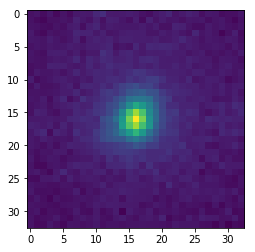